# **1D U-Net for FCS**

---

<font size=4> This 1-dimensional U-Net is capable of segmenting Fluorescence Correlation Spectroscopy (FCS) data and was first published in 2023 by [Seltmann *et al.*](https://www.biorxiv.org/content/10.1101/2023.08.24.554627v1.full). The U-Net architecture was first published by [Ronneberger *et al.*](https://arxiv.org/abs/1505.04597). The first half of the U-Net architecture is a downsampling convolutional neural network which acts as a feature extractor from input images. The other half upsamples these results and restores an image by combining results from downsampling with the upsampled images.

<font size=4> This notebook provides a joined interface for:

- <font size=4> loading published or simulating new FCS datasets with different FCS time-series artifacts ([Section 3](#scrollTo=jKaeBnSuifZn))
- (re-) training published or new 1D U-Nets for artifact segmentation ([Section 4](#scrollTo=GyRjBdClimfK))
- quality control of newly trained or published 1D U-Nets ([Section 5](#scrollTo=1Tm3aimXjZ1B))
- Segmenting FCS time-series, applying correction methods, and saving improved FCS time-series ([Section 6](#scrollTo=fB8QNLekkCyZ))(currently supported for *.csv* and *.ptu* files)

---

<font size = 4>*Disclaimer*:

<font size = 4>This notebook is inspired from the *Zero-Cost Deep-Learning to Enhance Microscopy* project (ZeroCostDL4Mic) (https://github.com/HenriquesLab/DeepLearning_Collab/wiki) and was created by [Alex Seltmann](https://www.github.com/aseltmann) at the Eggeling Lab Jena (https://www.biophysical-imaging.com)

<font size = 4>This notebook is based on the following paper:

<font size = 4>**Neural network informed photon filtering reduces artifacts in Fluorescence Correlation Spectroscopy data**, biorxiv, 2023 by *Alex Seltmann, Pablo Carravilla, Katharina Reglinski, Christian Eggeling, Dominic Waithe* [link to paper](https://www.biorxiv.org/content/10.1101/2023.08.24.554627v1.full) [link to source code](https://github.com/aseltmann/fluotracify/)

<font size = 4>**Connected datasets** (see [Section 2.3](#scrollTo=6zv2yWb5QM4I) for a download helper):


- <font size = 4>Fluorescence correlation spectroscopy time-series data with and without peak artifacts - simulated data - [download from Zenodo](https://zenodo.org/records/8074408)
- Fluorescence correlation spectroscopy TCSPC data with and without peak artifacts - AlexaFluor 488 applied experiment - [download from Zenodo](https://zenodo.org/records/8082558)
- Fluorescence correlation spectroscopy TCSPC data with and without peak artifacts - PEX5 applied experiment - [download from Zenodo](https://zenodo.org/records/8109282)
- Neural network informed photon filtering reduces artifacts in fluorescence correlation spectropscopy data - mlflow records - [download from Zenodo](https://zenodo.org/records/8137129)
- Fluotracify - doctoral research project done in a reproducible way - [download from Zenodo](https://zenodo.org/records/8137220)

<font size = 4>**Please also cite this original paper when using or developing this notebook.**

# **How to use this notebook?**

---

<font size = 4>Video describing how to use ZeroCostDL4Mic notebooks are available on youtube:
  - [**Video 1**](https://www.youtube.com/watch?v=GzD2gamVNHI&feature=youtu.be): Full run through of the workflow to obtain the notebooks and the provided test datasets as well as a common use of the notebook
  - [**Video 2**](https://www.youtube.com/watch?v=PUuQfP5SsqM&feature=youtu.be): Detailed description of the different sections of the notebook


---
###**Structure of a notebook**

<font size = 4>The notebook contains two types of cell:

<font size = 4>**Text cells** provide information and can be modified by douple-clicking the cell. You are currently reading the text cell. You can create a new text by clicking `+ Text`.

<font size = 4>**Code cells** contain code and the code can be modfied by selecting the cell. To execute the cell, move your cursor on the `[ ]`-mark on the left side of the cell (play button appears). Click to execute the cell. After execution is done the animation of play button stops. You can create a new coding cell by clicking `+ Code`.

---
###**Table of contents, Code snippets** and **Files**

<font size = 4>On the top left side of the notebook you find three tabs which contain from top to bottom:

<font size = 4>*Table of contents* = contains structure of the notebook. Click the content to move quickly between sections.

<font size = 4>*Code snippets* = contain examples how to code certain tasks. You can ignore this when using this notebook.

<font size = 4>*Files* = contain all available files. After mounting your google drive (see section 1.) you will find your files and folders here.

<font size = 4>**Remember that all uploaded files are purged after changing the runtime.** All files saved in Google Drive will remain. You do not need to use the Mount Drive-button; your Google Drive is connected in section 1.2.

<font size = 4>**Note:** The "sample data" in "Files" contains default files. Do not upload anything in here!

---
###**Making changes to the notebook**

<font size = 4>**You can make a copy** of the notebook and save it to your Google Drive. To do this click file -> save a copy in drive.

<font size = 4>To **edit a cell**, double click on the text. This will show you either the source code (in code cells) or the source text (in text cells).
You can use the `#`-mark in code cells to comment out parts of the code. This allows you to keep the original code piece in the cell as a comment.

#**0. Before getting started**
---
<font size=4> Before you run the notebook, please ensure that you are logged into your Google account and have the training data, quality control data, and - if needed - prior published U-Net models in your Google Drive.

<font size=4> For a U-Net to train, it needs to have access to a **paired training dataset of fluorescence traces (source) and corresponding masks (target)**. This notebook enables simulating such paired datasets in [Section 3](#scrollTo=jKaeBnSuifZn). Furthermore, the authors published a compatible dataset to train U-Nets for detecting peak artifacts in FCS time-series:

- <font size = 4>Fluorescence correlation spectroscopy time-series data with and without peak artifacts - simulated data - [download from Zenodo](https://zenodo.org/records/8074408)

<font size=4> **We strongly recommend that you generate (or use published) extra paired FCS time-series. These can be used to assess the quality of your trained model (Quality control dataset)**. The quality control assessment can be done directly in [Section 5](#scrollTo=1Tm3aimXjZ1B).

<font size=4> Here is a common data structure that can work:
*   Experiment A
    - **Model training**
      - train_source_and_target
        - .csv, .csv, ...
      - validation_source_and_target
        - .csv, .csv, ...
    - **Quality control dataset**
      - qc_source_and_target
        - .csv, .csv, ...
    - **Data to be predicted**
    - **Results**

<font size=4> Note that in this notebook, both source and target are provided in a single .csv file. **If you want to simulate your own training data, please only use [Section 3](#scrollTo=jKaeBnSuifZn) of this notebook.** This ensures that the created .csv files are compatible with the training and evaluation functions later on (e.g. the correct header with some metadata, the column delimiter being `,` and the decimal character being `.`).

---
<font size = 4>**Important note**


- <font size = 4> If you wish to **Train a network from scratch** using your own dataset (and we encourage everyone to do that), you will need to run [Sections 1 to 4](#scrollTo=NvJvtQQgiVDF) then use [Section 5](#scrollTo=1Tm3aimXjZ1B) to assess the quality of your model and [Section 6](#scrollTo=fB8QNLekkCyZ) to run predictions using the model that you trained.
- If you wish to **Evaluate your model** using a model previously generated and saved on your Google Drive, you will only need to run [Sections 1 and 2](#scrollTo=NvJvtQQgiVDF) to set up the notebook, then use [Section 5](#scrollTo=1Tm3aimXjZ1B) to assess the quality of your model. **Note: this notebook only supports models logged with mlflow, which helps capturing metadata**.
- If you only wish to **run predictions** using a model previously generated and saved on your Google Drive, you will only need to run [Sections 1 and 2](#scrollTo=NvJvtQQgiVDF) to set up the notebook, then use [Section 6](#scrollTo=fB8QNLekkCyZ) to run the predictions on the desired model.
---

# **1. Install 1D U-Net for FCS and dependencies**
---

In [1]:
#@title  { display-mode: "form" }
#Libraries contains information of certain topics.
import sys

# get pre-installed packages for constructing requirements.txt
try:
    before
except NameError:
    before = [str(m) for m in sys.modules]

#Put the imported code and libraries here

!pip install fpdf2
!pip install mlflow
!pip install multipletau
!pip install prettyprinter

import copy
import fpdf
import functools
import glob  # because pathlib.Path.rglob does not suffice
import importlib  # for workaround loading zenodo mlflow models
import io  # only .ptu import
import itertools
import logging
import mlflow
import multipletau  # for time-series correlation (Section 6 onwards)
import os
import requests
import scipy  # using scipy.stats.norm.rvs in simulation and scipy.ndimage.label in TCSPC 'averaging' correction
import shutil
import struct  # only .ptu import
import subprocess
import sys
import time  # only .ptu import
# import tqdm
import uuid  # only simulations

import ipywidgets as widgets  # for plots by pressing a button
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.preprocessing as skp
import tensorflow as tf
import tensorflow.experimental.numpy as tnp

from builtins import any as b_any
from dataclasses import dataclass, replace, field, astuple
from datetime import datetime
from IPython.display import clear_output
from multiprocessing import Pool
from pathlib import Path
# substituted freeze by function freeze_to_path(), because
# this import was not compatible with cython in Section 6.2.
# from pip._internal.operations.freeze import freeze
from prettyprinter import pprint, install_extras
from tqdm.notebook import tqdm
from typing import Union, Optional, List, Literal, Dict, Tuple, Any

install_extras(['dataclasses', 'numpy'])

logging.basicConfig(format='%(asctime)s - build model -  %(message)s')
log = logging.getLogger(__name__)
log.setLevel(logging.DEBUG)
# fix a problem with tf.experimental.numpy
tnp.experimental_enable_numpy_behavior(prefer_float32=False)
# there was the following error during model training: Tensorflow ValueError:
# Unexpected result of `train_function` (Empty logs). Please use
# `Model.compile(..., run_eagerly=True). If it returns, uncomment the following:
# tf.config.run_functions_eagerly(True)

# Fix seeds for reproducible random state
np.random.seed(0)
# TODO: https://stackoverflow.com/questions/16016959/scipy-stats-seed
# either replace scipy.stats.norm.rvs with numpy version
# or use numpy generator for both numpy and scipy seeds
# also: correct_TCSPC uses own seed for random weights currently


# Contact the ZeroCostDL4Mic team to find out about the version number
NOTEBOOK_VERSION = ['2.1.2']

# Build requirements file for local run
# -- the developers should leave this below all the other installations

def freeze_to_path():
    """see https://stackoverflow.com/a/74022456"""
    args = [sys.executable, "-m", "pip", "freeze"]
    p = subprocess.run(args, check=True, capture_output=True)
    return p.stdout.decode().split('\n')

def get_requirements_path():
    # Store requirements file in 'contents' directory
    current_dir = os.getcwd()
    dir_count = current_dir.count('/') - 1
    path = '../' * (dir_count) + 'requirements.txt'
    return path

def filter_files(file_list, filter_list):
    filtered_list = []
    for fname in file_list:
        if b_any(fname.split('==')[0] in s for s in filter_list):
            filtered_list.append(fname)
    return filtered_list

def build_requirements_file(before, after):
    path = get_requirements_path()

    # Exporting requirements.txt for local run
    req_list = freeze_to_path()

    # Get minimum requirements file
    mod_list = [m.split('.')[0] for m in after if not m in before]

    # Replace with package name and handle cases where import name is different
    # to module name
    mod_name_list = [['sklearn', 'scikit-learn'], ['skimage', 'scikit-image']]
    mod_replace_list = [[x[1] for x in mod_name_list]
                        if s in [x[0] for x in mod_name_list]
                        else s for s in mod_list]
    filtered_list = filter_files(req_list, mod_replace_list)

    with open(path, 'w') as f:
        f.write(f'# Requirements for U-Net_for_FCS_1D_ZeroCostDL4Mic.ipynb\n')
        f.writelines(f'{item}\n' for item in filtered_list)

after = [str(m) for m in sys.modules]

build_requirements_file(before, after)


def mlflow_model_fluotracify_package_workaround():
    # set up python package
    path = Path('/content/fluotracify/training/build_model.py')
    pathinit1 = path.parent / '__init__.py'
    pathinit2 = path.parent.parent / '__init__py'
    path.parent.mkdir(parents=True, exist_ok=True)
    path.write_text("def binary_ce_dice_loss_coef():\n    pass", encoding="utf-8")
    pathinit1.touch()
    pathinit2.touch()
    # add to system path and import it
    sys.path.append(path.parent.parent)
    try:
        importlib.import_module('fluotracify.training.build_model')
    except ModuleNotFoundError:
        importlib.reload(fluotracify.training.build_model)

    # clean up
    shutil.rmtree(path.parent.parent)


mlflow_model_fluotracify_package_workaround()


# ---------------------- MODEL BUILDING ----------------------------------
# define custom loss functions
def binary_ce_dice_loss_coef(y_true, y_pred, axis, smooth):
    def dice_loss(y_true, y_pred, axis, smooth):
        """Soft dice coefficient for comparing the similarity of two batches
        of data, usually used for binary image segmentation

        For binary labels, the dice loss will be between 0 and 1 where 1 is a
        total match. Reshaping is needed to combine the global dice loss with
        the local binary_crossentropy

        Notes
        -----
        - This is probably equal to the F1-Score (need to double-check). After
          tensorflow 2.12.-nightly this is implemented in
          tf.keras.metrics.F1Score - might migrate then.
        """
        numerator = 2 * tf.math.reduce_sum(
            input_tensor=y_true * y_pred, axis=axis, keepdims=True)
        denominator = tf.math.reduce_sum(input_tensor=y_true + y_pred,
                                         axis=axis,
                                         keepdims=True)

        return 1 - (numerator + smooth) / (denominator + smooth)

    return tf.keras.backend.binary_crossentropy(y_true, y_pred) + dice_loss(
        y_true, y_pred, axis, smooth)


def binary_ce_dice_loss(axis=-1, smooth=1e-5):
    """Combination of binary crossentropy and dice loss

    Parameters
    -----------
    y_true : Tensor
        A distribution with shape: [batch_size, ....], (any dimensions).
    y_pred : Tensor
        The y_pred distribution, format the same with `y_true`.
    axis : int or tuple of int
        All dimensions are reduced, default ``-1``
    smooth : float, optional
        Will be added to the numerator and denominator of the dice loss.
        - If both y_true and y_pred are empty, it makes sure dice is 1.
        - If either y_true or y_pred are empty (all pixels are background),
        dice = ```smooth/(small_value + smooth)``
        - Smoothing is not really necessary for combined losses (so standard
        value is 0)

    Notes
    -----
    - this function was influenced by code from
        - TensorLayer project
        https://tensorlayer.readthedocs.io/en/latest/modules/cost.html#tensorlayer.cost.dice_coe,
        - Lars Nieradzik
        https://lars76.github.io/neural-networks/object-detection/losses-for-segmentation/
        - Code by Stefan Hoffmann, Applied Systems Biology group,
        Hans-Knöll-Institute Jena
    - To be able to load the custom loss function in Keras, it must only take
      (y_true, y_pred) as parameters - that is why this setup seems so
      complicated.
    - binary crossentropy returns a tensor with loss for each 1D step of a
      trace, bringing local info
    - dice loss returns a scalar for each 1D trace, bringing global info
    """
    def binary_ce_dice(y_true, y_pred):
        return binary_ce_dice_loss_coef(y_true, y_pred, axis, smooth)

    return binary_ce_dice


# define evaluation metrics
class BinaryFBeta(tf.keras.metrics.Metric):
    """A stateless F-beta score implementation by Jolomi Tosanwumi, see
    https://towardsdatascience.com/f-beta-score-in-keras-part-i-86ad190a252f

    Notes
    -----
    - the F1-Score is an implementation of the harmonic mean of precision and
    recall. The goal is to minimize type I and type II errors - and harmonic
    mean penalizes lower values more than higher values, so that we don't get a
    high score when one of precision or recall is low.
    - FBeta makes it possible to give more weight to Precision or Recall. It
    introduces beta_squared, which is the ratio of the weight of Recall to the
    weight of Precision.
      - beta > 1: Recall weighted more than Precision
      - beta < 1: Precision weighted more than Recall
    - from tensorflow 2.12-nightly this metric is in the standard library as
      tf.keras.metrics.FBetaScore (and tf.keras.metrics.F1Score)
    """
    def __init__(self, name='binary_fbeta', beta=1, threshold=0.5,
                 epsilon=1e-7, **kwargs):
        # initializing an object of the super class
        super().__init__(name=name, **kwargs)

        # initializing state variables
        self.tp = self.add_weight(name='tp', initializer='zeros')
        self.actual_positive = self.add_weight(name='fp', initializer='zeros')
        self.predicted_positive = self.add_weight(
            name='fn', initializer='zeros')

        # initializing other atrributes that wouldn't be changed for every
        # object of this class
        self.beta_squared = beta**2
        self.threshold = threshold
        self.epsilon = epsilon

    def update_state(self, ytrue, ypred, sample_weight=None):
        """this method is called at the end of each batch and is used to change
        (update) the state variables."""
        ytrue = tf.cast(ytrue, tf.float32)
        ypred = tf.cast(ypred, tf.float32)

        # setting values of ypred greater than the set threshold to 1 while
        # those lesser to 0
        ypred = tf.cast(tf.greater_equal(ypred, tf.constant(self.threshold)),
                        tf.float32)
        # updating atrributes
        self.tp.assign_add(tf.reduce_sum(ytrue*ypred))
        self.predicted_positive.assign_add(tf.reduce_sum(ypred))
        self.actual_positive.assign_add(tf.reduce_sum(ytrue))

    def result(self):
        """this is called at the end of each batch after states variables are
        updated. It is used to compute and return the metric for each batch."""
        self.precision = self.tp / (self.predicted_positive+self.epsilon)
        self.recall = self.tp / (self.actual_positive+self.epsilon)

        # calculating fbeta
        self.fb = (1+self.beta_squared)*self.precision*self.recall / (
            self.beta_squared*self.precision + self.recall + self.epsilon)
        return self.fb

    def reset_state(self):
        """this is called at the end of each epoch. It is used to clear
        (reinitialize) the state variables."""
        self.tp.assign(0)
        self.predicted_positive.assign(0)
        self.actual_positive.assign(0)


def unet_metrics(metrics_thresholds):
    """Returns a selection of metrics for model training

    Currently these metrics are True Positives, False Positives, True
    Negatives, False Negatives, Preciesion, Recall, Accuracy, AUC

    Parameters
    ----------
    metrics_thresholds: list of float between 0 and 1

    Returns
    -------
    list of metrics
    """
    metrics = []
    for thresh in metrics_thresholds:
        metrics.append(tf.keras.metrics.TruePositives(name=f'tp{thresh}',
                                                      thresholds=thresh))
        metrics.append(tf.keras.metrics.FalsePositives(name=f'fp{thresh}',
                                                       thresholds=thresh))
        metrics.append(tf.keras.metrics.TrueNegatives(name=f'tn{thresh}',
                                                      thresholds=thresh))
        metrics.append(tf.keras.metrics.FalseNegatives(name=f'fn{thresh}',
                                                       thresholds=thresh))
        metrics.append(tf.keras.metrics.Precision(name=f'precision{thresh}',
                                                  thresholds=thresh))
        metrics.append(tf.keras.metrics.Recall(name=f'recall{thresh}',
                                               thresholds=thresh))
    metrics.append(
        tf.keras.metrics.BinaryAccuracy(name='accuracy0.5', threshold=0.5))
    metrics.append(tf.keras.metrics.AUC(name='auc', num_thresholds=100))
    metrics.append(BinaryFBeta(name='f10.5'))
    return metrics


# define model layers
def convtrans(filters, name, kernel_size, strides):
    """Sequential API: Conv1DTranspose, BatchNorm"""
    upsamp = tf.keras.Sequential(name=name)
    upsamp.add(
        tf.keras.layers.Conv1DTranspose(filters=filters,
                                        kernel_size=kernel_size,
                                        strides=strides))
    upsamp.add(tf.keras.layers.BatchNormalization())
    upsamp.add(tf.keras.layers.Activation('relu'))
    return upsamp


def twoconv(filters, name):
    """Sequential API: Conv1D, BatchNorm, Conv1D, BatchNorm"""
    conv = tf.keras.Sequential(name=name)
    conv.add(
        tf.keras.layers.Conv1D(filters=filters, kernel_size=3, padding='same'))
    conv.add(tf.keras.layers.BatchNormalization())
    conv.add(tf.keras.layers.Activation('relu'))

    conv.add(
        tf.keras.layers.Conv1D(filters=filters, kernel_size=3, padding='same'))
    conv.add(tf.keras.layers.BatchNormalization())
    conv.add(tf.keras.layers.Activation('relu'))
    return conv


def encoder(input_tensor, filters, name, pool_size=2):
    """Functional API: Two Conv1D incl BatchNorm, MaxPool1D"""
    encode = twoconv(filters=filters, name=name)(input_tensor)
    encode_pool = tf.keras.layers.MaxPool1D(pool_size=pool_size,
                                            name='mp_{}'.format(name))(encode)
    return encode_pool, encode


def decoder(input_tensor,
            concat_tensor,
            filters,
            name,
            kernel_size=2,
            strides=2):
    """Functional API: Conv1DTrans, BatchNorm, Concat, Two Conv incl BatchNorm
    """
    decode = convtrans(filters=filters,
                       name='conv_transpose_{}'.format(name),
                       kernel_size=kernel_size,
                       strides=strides)(input_tensor)
    decode = tf.keras.layers.concatenate([concat_tensor, decode],
                                         axis=-1,
                                         name=name)
    decode = twoconv(filters=filters, name='two_conv_{}'.format(name))(decode)
    return decode


def unet_1d(input_size: Union[int, None], n_levels: int, first_filters: int,
            pool_size: int, metrics_thresholds: List[float], name: str):
    """Defines compiled U-Net. Includes option to define various hyperparameters
    and the more abstract parameter of unet levels.

    Parameters
    ----------
    input_size : int
        Input vector size
    n_levels : int
        Number of levels or steps in the Unet
    first_filters : int
        The number of filters in the first level. Every deeper level
        will be twice as many filters till a maximum of 512 is reached.
        Filters will be clipped if smaller than 1 or bigger than 512
    pool_size : int, Optional. Default: 2
        Pool size of the MaxPool1D layer, as well as kernel size and
        strides of the Conv1DTranspose layer
    metrics_thresholds : list of float between 0 and 1
        compute metrics with these prediction thresholds

    Returns
    -------
    Compiled Model as described by the tensorflow.keras Functional API

    Notes
    -----
    - Paper: https://arxiv.org/pdf/1505.04597.pdf
    - conceptually different approach than in the paper is the use of
    transposed convolution opposed to a up"-convolution" consisting of
    bed-of-nails upsampling and a 2x2 convolution
    - this implementation was influenced by:
    https://www.tensorflow.org/tutorials/generative/pix2pix
    """
    filters = [first_filters]
    nextfilters = first_filters
    for _ in range(1, n_levels + 1):
        nextfilters *= 2
        filters.append(nextfilters)
    filters = tnp.clip(filters, a_min=1, a_max=512).numpy()
    filters = tf.cast(filters, tf.int32).numpy()

    ldict = {}

    inputs = tf.keras.layers.Input(shape=(input_size, 1))

    # Downsampling through model
    ldict['x0_pool'], ldict['x0'] = encoder(inputs,
                                            filters[0],
                                            name='encode0',
                                            pool_size=pool_size)
    for i in range(1, n_levels):
        ldict['x{}_pool'.format(i)], ldict['x{}'.format(i)] = encoder(
            input_tensor=ldict['x{}_pool'.format(i - 1)],
            filters=filters[i],
            name='encode{}'.format(i),
            pool_size=pool_size)

    # Center
    center = twoconv(2 * filters[n_levels - 1], name='two_conv_center')(
        ldict['x{}_pool'.format(n_levels - 1)])

    # Upsampling through model
    ldict['y{}'.format(n_levels - 1)] = decoder(
        input_tensor=center,
        concat_tensor=ldict['x{}'.format(n_levels - 1)],
        filters=filters[-1],
        name='decoder{}'.format(n_levels - 1),
        kernel_size=pool_size,
        strides=pool_size)

    for j in range(1, n_levels):
        ldict['y{}'.format(n_levels - 1 - j)] = decoder(
            input_tensor=ldict['y{}'.format(n_levels - j)],
            concat_tensor=ldict['x{}'.format(n_levels - 1 - j)],
            filters=filters[-1 - j],
            name='decoder{}'.format(n_levels - 1 - j),
            kernel_size=pool_size,
            strides=pool_size)

    # create 'binary' output vector
    outputs = tf.keras.layers.Conv1D(filters=1,
                                     kernel_size=1,
                                     activation='sigmoid')(ldict['y0'])

    log.debug('unet: input shape: %s, output shape: %s', inputs.shape,
              outputs.shape)

    unet = tf.keras.Model(inputs=inputs,
                          outputs=outputs,
                          name=name)

    optimizer = tf.keras.optimizers.Adam()
    loss = binary_ce_dice_loss()
    metrics = unet_metrics(metrics_thresholds)
    unet.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return unet


# ---------------------- LOADING TRAINING DATA---------------------------------
def read_simulated_csvs(filename: Union[str, Path], header: Union[int, None],
                        dropindex: Union[int, None],
                        dropcolumns: Union[int, None],
                        col_per_example: int):
    try:
        raw_dataset = pd.read_csv(filename, sep=',', header=header)
    except pd.errors.ParserError as exc:
        raise ValueError(
            'Probably the header parameter is too low and points to the'
            ' metadata. Try a higher value.') from exc
    df = raw_dataset.copy()
    try:
        df = df.drop(index=dropindex, columns=dropcolumns)
    except ValueError:
        pass
    # convert from float64 to float32 and from object to float32
    # -> shrinks memory usage of train dataset from 2.4 GB to 1.2GB
    try:
        df = df.apply(pd.to_numeric, downcast='float')
    except ValueError as exc:
        raise ValueError(
            'Probably the header parameter is too low and points to the'
            'metadata. Try a higher value.') from exc
    # save number of examples per file
    nsamples = round(len(df.columns) / col_per_example)
    # save some parameters of the experiment from csv file
    experiment_param = pd.read_csv(filename,
                                    sep=',',
                                    header=None,
                                    index_col=0,
                                    usecols=[0, 1],
                                    skipfooter=len(raw_dataset)+1,
                                    engine='python').squeeze('columns')

    return df, nsamples, experiment_param, filename


def read_simulated_csvs_wrapper(args):
    return read_simulated_csvs(*args)

@functools.lru_cache
def import_from_csv(folder,
                    header,
                    col_per_example,
                    dropindex=None,
                    dropcolumns=None):
    """Import CSV files containing data from fluotracify.simulations

    Import a directory of CSV files created by one of the
    fluotracify.simulations methods and output two pandas DataFrames containing
    test and train data for machine learning pipelines.

    Parameters
    ----------
    folder : str
        Folder which contains .csv files with data
    header : int
        param for `pd.read_csv` = rows to skip at beginning
    col_per_example : int
        Number of columns per example, first column being a trace, and then
        one or multiple labels
    dropindex : int, optional
        Which indeces in the csv file should be dropped
    dropcolumns : str or int, optional
        Which columns in the csv file should be dropped

    Returns
    -------
    train, test : pandas DataFrames
        Contain training and testing data columnwise in the manner data_1,
        label_1, data_2, label_2, ...
    nsamples : int
        list containing no of examples per file
    experiment_param :  pandas DataFrame
        Contains metadata of the files

    Raises
    ------
    FileNotFoundError
        If the path provided does not include any .csv files
    ValueError
        If pandas read_csv fails
    """
    log.debug(f'Creating a list of all .csv files in {folder=} including its '
             'subdirectories...')
    files = list(tqdm(Path(folder).rglob('*.csv')))

    if len(files) == 0:
        raise FileNotFoundError('The path provided does not include any'
                                ' .csv files.')

    files.sort()
    np.random.shuffle(files)

    inputs = zip(files, itertools.repeat(header), itertools.repeat(dropindex),
                 itertools.repeat(dropcolumns), itertools.repeat(col_per_example))

    log.debug('Reading %s files from folder %s', len(files), folder)
    with Pool() as pool:
        results = list(tqdm(pool.imap(read_simulated_csvs_wrapper, inputs),
                                 total=len(files)))

    df_data = pd.concat([r[0] for r in results], axis='columns')
    nsamples = [r[1] for r in results]
    df_metadata = pd.concat([r[2] for r in results], axis='columns',
                            ignore_index=True, sort=False)

    return df_data, nsamples, df_metadata


def separate_data_and_labels(array, col_per_example):
    """Take pandas DataFrame containing feature and label data output a
    dictionary containing them separately

    Parameters
    ----------
    array : pandas DataFrame
        features and labels ordered columnwise in the manner: feature_1,
        label_1, feature_2, label_2, ...
    col_per_example : int
        Number of columns per example, first column being a trace, and then
        one or multiple labels

    Returns
    -------
    array_dict : dict of pandas DataFrames
        Contains one key per column in each simulated example. E.g. if the
        simulated features comes with two labels, the key '0' will be the
        array with the features, '1' will be the array with label A and
        '2' will be the array with label B
    """
    # if not len(set(nsamples)) == 1:
    #     raise Exception(
    #         'Error: The number of examples in each file have to be the same')

    array_dict = {}

    for i in range(col_per_example):
        array_dict[f'{i}'] = array.iloc[:, i::col_per_example]

    if col_per_example == 1:
        given_data = '(source)'
    elif col_per_example == 2:
        given_data = '(source, target)'
    elif col_per_example == 3:
        given_data = '(source, target, target)'
    else:
        raise ValueError(f'{col_per_example=} is not supported.')
    array_dict_shapes = [a.shape for a in array_dict.values()]
    log.debug('The given DataFrame was split into %s parts %s with shapes:'
              ' %s', col_per_example, given_data, array_dict_shapes)

    return array_dict


def load_source_and_target_from_simulations(path: str | Path,
                                            artifact: Literal['peak_artifact',
                                                              'detector_dropout',
                                                              'photobleaching'],
                                            n_targets: Literal[1, 2]):
    """Script to read in source and target data for the U-NET for FCS notebook
    """
    col_per_example = 1 + n_targets

    if artifact == 'peak_artifact':
        LABEL_THRESH = 0.04
        HEADER = 12
    elif artifact == 'detector_dropout':
        LABEL_THRESH = 0
        HEADER = 10
        raise ValueError('Training the model for detector dropout correction '
                         'has not yet been validated properly. Please contact '
                         'the authors if you want to do so, we are happy to '
                         'support you and guide you through the code base.')
    elif artifact == 'photobleaching':
        LABEL_THRESH = 0.04  # TODO: check this threshold value
        HEADER = 11
        raise ValueError('Training the model for photobleaching correction '
                         'has not yet been validated properly. Please contact '
                         'the authors if you want to do so, we are happy to '
                         'support you and guide you through the code base.')
    else:
        raise ValueError('artifact has to be in ["peak_artifact", "detector_dropout"'
                        ', "photobleaching"]')


    data, nsamples, experiment_params = import_from_csv(
        folder=path,
        header=HEADER,
        col_per_example=col_per_example,
        dropindex=None,
        dropcolumns=None)
    no_of_traces = len([t for t in data.columns if 'trace' in t])
    no_of_cols = len(data.columns)
    read_col_per_example = no_of_cols / no_of_traces
    if read_col_per_example != col_per_example:
        raise ValueError(f'{n_targets=} suggests that {col_per_example} columns of '
                        f'data are present in the .csv files, but found '
                        f'{read_col_per_example} in the data. Re-execute the'
                        ' cell with the correct value.')

    read_artifact = []
    params = experiment_params.T
    if np.any(params.get('number of slow clusters')):
        read_artifact.append('peak_artifact')
    if np.any(params.get('number of bleached molecules (50% immobile and 50% mobile)')):
        read_artifact.append('photobleaching')
    if not (np.any(params.get('number of slow clusters')) or
            np.any(params.get('number of bleached molecules (50% immobile and 50% mobile)'))):
        read_artifact.append('detector_dropout')
    if len(set(read_artifact)) != 1:
        raise ValueError('The read .csv files do contain different simulated '
                        f'artifacts (found {read_artifact}).')

    if read_artifact[0] != artifact:
        raise ValueError('The read .csv files contain other artifacts than the '
                        f'user suggested ({artifact=}, but found '
                        f'{read_artifact[0]}. Re-execute cell with the correct value.')

    sep = separate_data_and_labels(array=data,
                                   col_per_example=col_per_example)

    # if n_targets = 2:
    # '0': trace with artifact
    # '1': just the simulated artifact (label for unet)
    # '2': whole trace without artifact (label for vae)

    source = sep['0']
    target = sep['1']

    if artifact == 'detector_dropout':
        target_bool = target < LABEL_THRESH
    else:
        target_bool = target > LABEL_THRESH

    return source, target_bool, set(read_artifact), experiment_params


# -------- DATA PREPROCESSING AND LOGGING FOR TRAINING -----------------------
def tfds_replace_nan_in_traces_and_labels(trace, label):
    """Part of tf.data pipeline. Replaces nan values with zeros"""
    trace = tf.where(tf.math.is_nan(trace), tf.zeros_like(trace), trace)
    label = tf.where(tf.math.is_nan(label), tf.zeros_like(label), label)
    return trace, label


def tfds_from_pddf(features_df: pd.DataFrame, labels_df: pd.DataFrame):
    """TensorFlow Dataset from pandas DataFrame

    This function was created to take pandas DataFrames containing simulated
    fluorescence traces with artifacts (features) and the ground truth about
    the artifacts (labels) as an input and create a tf Dataset

    Parameters
    ----------
    features_df, labels_df : pandas DataFrames
        Contain features / labels ordered columnwise in the manner: feature_1,
        feature_2, ... / label_1, label_2, ...

    Returns
    -------
    dataset : TensorFlow Dataset
        Contains features and labels
    num_examples : int
        Number of test examples
    """
    X_tensor = tf.convert_to_tensor(value=features_df.values)
    X_tensor = tf.transpose(a=X_tensor, perm=[1, 0])

    y_tensor = tf.convert_to_tensor(value=labels_df.values)
    y_tensor = tf.transpose(a=y_tensor, perm=[1, 0])
    y_tensor = tf.cast(y_tensor, tf.float32)

    num_examples = X_tensor.shape[0]
    X_tensor = tf.reshape(tensor=X_tensor, shape=(num_examples, -1, 1))
    y_tensor = tf.reshape(tensor=y_tensor, shape=(num_examples, -1, 1))

    dataset = tf.data.Dataset.from_tensor_slices((X_tensor, y_tensor))
    dataset = dataset.map(tfds_replace_nan_in_traces_and_labels)

    log.debug('number of examples: %s', num_examples)

    return dataset, num_examples


def tfds_crop_trace_and_label(trace, label, length_delimiter):
    """Part of tf.data pipeline. Crop trace and label to a maximum length of
    length_delimiter
    """
    trace = trace[:length_delimiter]
    label = label[:length_delimiter]
    trace_shape = trace.shape
    label_shape = label.shape
    trace.set_shape(trace_shape)
    label.set_shape(label_shape)
    return trace, label


def _scale_trace(trace, scaler):
    """Part of tf.data pipeline. Scale / normalize the input trace.

    Parameters:
    -----------
    trace : np.array, pd.DataFrame or tf.Tensor
        1D-Trace (1 example with 1 feature of length n along axis=0)
    scaler : ('standard', 'robust', 'maxabs', 'quant_g', 'minmax', l1', 'l2')
        Selected scalers from sklearn.preprocessing

    Returns:
    --------
    trace : np.array
        Scaled / normalized trace.

    Raises:
    -------
    ValueError
        If the value for scaler is not in ('standard', 'robust', 'maxabs',
        'quant_g', 'minmax', 'l1', 'l2')
    """
    scaler = tf.convert_to_tensor(scaler)
    if scaler == tf.convert_to_tensor('standard'):
        trace = skp.StandardScaler().fit_transform(trace)
    elif scaler == tf.convert_to_tensor('robust'):
        trace = skp.RobustScaler(quantile_range=(25, 75)).fit_transform(trace)
    elif scaler == tf.convert_to_tensor('maxabs'):
        trace = skp.MaxAbsScaler().fit_transform(trace)
    elif scaler == tf.convert_to_tensor('quant_g'):
        trace = skp.QuantileTransformer(
            output_distribution='normal').fit_transform(trace)
    elif scaler == tf.convert_to_tensor('minmax'):
        trace = skp.MinMaxScaler().fit_transform(trace)
    elif scaler == tf.convert_to_tensor('l1'):
        trace = skp.normalize(X=trace, norm='l1', axis=0)
    elif scaler == tf.convert_to_tensor('l2'):
        trace = skp.normalize(X=trace, norm='l2', axis=0)
    else:
        raise ValueError(
            'scaler has to be a string. currently supported are:'
            '"standard", "robust", "maxabs", "quant_g", "minmax", "l1", "l2"')
    return trace


def tfds_scale_trace_and_label(trace, label, scaler):
    """Part of tf.data pipeline. Wrapper function to be able to .map()
    scale_trace()
    """
    trace_shape = trace.shape
    [trace, ] = tf.py_function(func=_scale_trace,
                               inp=[trace, scaler],
                               Tout=[tf.float32])
    trace.set_shape(trace_shape)
    return trace, label


def _get_pad_size_and_value(trace):
    """Get pad size and pad value. """
    def get_median(v):
        v = tf.reshape(v, [-1])
        mid = v.get_shape()[0] // 2 + 1
        return tf.nn.top_k(v, mid).values[-1]

    trace_size = trace.size
    if trace_size < 1024:
        input_size = 1024
    else:
        # new size is the next biggest power of 2 → this is important for the
        # skip connections of the UNET
        input_size = 2**tnp.ceil(tnp.log2(trace_size))
    input_size = tf.cast(input_size, tf.int32)
    pad_size = input_size - trace_size

    # pad trace
    pad_value = get_median(trace)
    return pad_size, pad_value


def tfds_pad_trace_and_label(trace, label):
    """Part of tf.data pipeline. Pad the end of the trace with the
    median of the trace. Set the label for this pad to 0 (no artifact)

    Notes
    -----
    - at the moment, the implementation of `tf.experimental.numpy.pad` does not
    support the mode `median` (see
    https://www.tensorflow.org/api_docs/python/tf/experimental/numpy/pad)
    - that's why an own pure tf implementation of a median is used (see
    https://stackoverflow.com/questions/43824665/tensorflow-median-value)
    """
    pad_size, pad_median = _get_pad_size_and_value(trace)
    trace = tnp.pad(trace, pad_width=[[0, pad_size], [0, 0]],
                    mode='constant',
                    constant_values=pad_median)
    label = tnp.pad(label, pad_width=[[0, pad_size], [0, 0]],
                    mode='constant',
                    constant_values=0)

    trace_shape = trace.shape
    label_shape = label.shape
    trace.set_shape(trace_shape)
    label.set_shape(label_shape)
    return trace, label


def plot_trace_and_pred_from_tfds(dataset, ntraces, model):
    fig, ax = plt.subplots(ntraces,
                           figsize=(16, ntraces * 2),
                           facecolor='white')
    pred_iterator = dataset.unbatch().take(ntraces).as_numpy_iterator()

    for i in range(ntraces):
        pred_data = pred_iterator.next()
        pred_trace = pred_data[0].reshape(1, -1, 1)
        prediction = model.predict(pred_trace)
        prediction = prediction.flatten()
        pred_trace = pred_trace.flatten()
        pred_label = pred_data[1].flatten()
        ax[i].plot(pred_trace / np.max(pred_trace))
        ax[i].plot(prediction)
        ax[i].plot(pred_label)
    plt.tight_layout()
    return fig


# ---------------------- MODEL TRAINING ----------------------------------
def run_cli(command: str):
    out = subprocess.run(command, stdout=subprocess.PIPE, shell=True)
    out = out.stdout.decode('utf-8')
    return out


def log_cli_to_mlflow(command: str):
    tmp_path = f'/tmp/{command.split(" ")[0]}.txt'
    out = run_cli(command)
    Path(tmp_path).write_text(out)
    mlflow.log_artifact(tmp_path)


def mlflow_run(train_data: pd.DataFrame, train_labels: pd.DataFrame,
               train_experiment_params: pd.DataFrame,
               val_data: pd.DataFrame, val_labels: pd.DataFrame,
               val_experiment_params: pd.DataFrame, batch_size: int,
               crop_size: int, lr_start: Union[float, int], lr_power: int,
               epochs: int, scaler: Literal['standard', 'robust', 'maxabs',
                                            'quant_g', 'minmax', 'l1', 'l2'],
               name: str, model: tf.keras.Model, initial_epoch: int):

    # FIXME (PENDING): at some point, I want to plot metrics vs thresholds
    # from TF side, this is possible by providing the `thresholds`
    # argument as a list of thresholds
    # but currently, mlflow does not support logging lists, so I log the
    # elements of the list one by one
    EXP_PARAM_PATH_TRAIN = '../tmp/experiment_params_train.csv'
    EXP_PARAM_PATH_VAL = '../tmp/experiment_params_val.csv'
    LOG_DIR = "../tmp/tb-" + datetime.now().strftime("%Y%m%d-%H%M%S")

    def run_one(dataset_train, dataset_val, logdir, crop_size, scaler,
                num_train_examples, num_val_examples, name, model,
                initial_epoch):
        """Run a training/validation session.

        Parameters:
        -----------
        dataset_train, dataset_val : tf.Dataset
            Train and validation data as tf.Datasets.
        logdir : str
            The top-level logdir to which to write summary data.
        num_train_examples, num_val_examples : int
            number of train and validation examples

        Returns:
        --------
        """
        ds_train_prep = dataset_train.map(
            lambda trace, label: tfds_crop_trace_and_label(
                trace, label, crop_size), num_parallel_calls=tf.data.AUTOTUNE)
        ds_train_prep = ds_train_prep.map(
            lambda trace, label: tfds_scale_trace_and_label(
                trace, label, scaler), num_parallel_calls=tf.data.AUTOTUNE)
        ds_train_prep = ds_train_prep.map(
            tfds_pad_trace_and_label, num_parallel_calls=tf.data.AUTOTUNE)
        ds_train_prep = ds_train_prep.shuffle(
            buffer_size=num_train_examples).repeat().batch(
                batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

        ds_val_prep = dataset_val.map(
            lambda trace, label: tfds_crop_trace_and_label(
                trace, label, crop_size), num_parallel_calls=tf.data.AUTOTUNE)
        ds_val_prep = ds_val_prep.map(
            lambda trace, label: tfds_scale_trace_and_label(
                trace, label, scaler), num_parallel_calls=tf.data.AUTOTUNE)
        ds_val_prep = ds_val_prep.map(
            tfds_pad_trace_and_label, num_parallel_calls=tf.data.AUTOTUNE)
        ds_val_prep = ds_val_prep.shuffle(
            buffer_size=num_val_examples).repeat().batch(
                batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

        def log_plots(epoch, logs):
            """Image logging function for tf.keras.callbacks.LambdaCallback

            Notes
            -----
            - `tf.keras.callbacks.LambdaCallback` expects two positional
              arguments `epoch` and `logs`, if `on_epoch_end` is being used
            - see https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/LambdaCallback
            """
            figure = plot_trace_and_pred_from_tfds(
                dataset=ds_val_prep, ntraces=5, model=model)
            # Convert matplotlib figure to image
            mlflow.log_figure(
                figure=figure,
                artifact_file=f'predplots/plot{epoch:0>3}.png')

        def lr_schedule(epoch):
            """
            Returns a custom learning rate that decreases as epochs progress.

            Notes
            -----
            - function is supposed to be used with
              `tf.keras.callbacks.LearningRateScheduler`. It takes an epoch
              index as input (integer, indexed from 0) and returns a new
              learning rate as output (float)
            """
            # power: 1 == linear decay, higher, e.g. 5 == polynomial decay
            lr_list = [lr_start * (1 - i / epochs)**lr_power
                       for i in range(epochs)]

            # log in mlflow
            if epoch == 0:
                mlflow.log_param('lr_schedule', value=str(lr_list))
            return lr_list[epoch]

        tensorboard_callback = tf.keras.callbacks.TensorBoard(  # logs metrics
            log_dir=logdir,
            histogram_freq=5,
            write_graph=False,
            write_images=False,
            update_freq='epoch',
            profile_batch=0,  # workaround for issue #2084
        )

        lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule)
        image_callback = tf.keras.callbacks.LambdaCallback(
            on_epoch_end=log_plots)

        steps_train = num_train_examples // batch_size
        steps_val = num_val_examples // batch_size

        history = model.fit(
            x=ds_train_prep,
            epochs=epochs,
            steps_per_epoch=steps_train,
            validation_data=ds_val_prep,
            validation_steps=steps_val,
            callbacks=[tensorboard_callback, lr_callback, image_callback],
            initial_epoch=initial_epoch
        )

        mlflow.tensorflow.log_model(
            model=model,
            artifact_path='model',
            conda_env=mlflow.tensorflow.get_default_conda_env(),
            custom_objects={'binary_ce_dice': binary_ce_dice_loss(),
                            'BinaryFBeta': BinaryFBeta()})
        return history

    dataset_train, num_train_examples = tfds_from_pddf(
        features_df=train_data, labels_df=train_labels)

    dataset_val, num_val_examples = tfds_from_pddf(
        features_df=val_data, labels_df=val_labels)

    name = f'{name}-depth{n_levels}-first_filters{first_filters}-pool_size{pool_size}'
    mlflow.set_experiment(name)
    exp = mlflow.get_experiment_by_name(name)

    with mlflow.start_run(experiment_id=exp.experiment_id) as run:
        mlflow.tensorflow.autolog(every_n_iter=1, log_models=False,
                                log_input_examples=True)
        train_experiment_params.to_csv(EXP_PARAM_PATH_TRAIN)
        val_experiment_params.to_csv(EXP_PARAM_PATH_VAL)
        mlflow.log_artifact(EXP_PARAM_PATH_TRAIN)
        mlflow.log_artifact(EXP_PARAM_PATH_VAL)
        command_list = ['nvcc --version', 'nvidia-smi', 'printenv', 'lscpu',
                        'free -h', 'top -bcn1 -w512 | head -n 15']
        for c in command_list:
            log_cli_to_mlflow(c)
        mlflow.log_params({
            'num_train_examples': num_train_examples,
            'num_val_examples': num_val_examples,
            'scaler': scaler,
            'batch_size': batch_size,
            'crop_size': crop_size,
            'lr_start': lr_start,
            'lr_power': lr_power,
            })

        history = run_one(dataset_train=dataset_train,
                          dataset_val=dataset_val,
                          logdir=LOG_DIR,
                          crop_size=crop_size,
                          scaler=scaler,
                          num_train_examples=num_train_examples,
                          num_val_examples=num_val_examples,
                          name=name,
                          model=model,
                          initial_epoch=initial_epoch
                          )

        for k, v in history.history.items():
            for e in range(epochs):
                mlflow.log_metric(key=k, value=v[e], step=e)
    return exp, run, history


class TrainClick(object):
    def __init__(self, runs=None, models=None, clients=None, mlflow_kwargs=None):
        """
        Train 1D U-Net for FCS model. Offers two ways to train the model:
        either by loading a prior mlflow-logged model or by training from
        scratch.

        mlflow_kwargs : dict
            Holds the following arguments for the mlflow run: train_data,
            train_labels, val_data, val_labels, train_experiment_params,
            val_experiment_params, batch_size, crop_size, lr_start, lr_power,
            epochs, initial_epoch, scaler, name
        """
        self.dropdown = None
        self.button = widgets.Button(description="Use chosen model!")
        self.runs = [] if runs is None else runs
        self.models = {} if models is None else models
        self.clients = {} if clients is None else clients
        self.mlflow_kwargs = {} if mlflow_kwargs is None else mlflow_kwargs
        self.finetuned = False

    def _create_widgets(self):

        drop_opt = [(f'model {model.name} with {scaler=} from {run=}', run) for
                    run, (model, scaler, _)  in self.models.items()]
        default_run = drop_opt[0][1]
        self.dropdown = widgets.Dropdown(
            options=drop_opt,
            value=default_run,
            description='Model:',
            disabled=False,
            layout=widgets.Layout(width='75%')
        )
        self.button.on_click(self._on_button_clicked)

    def _on_button_clicked(self, change):
        clear_output()
        run = [r for r in self.runs if r.info.run_id == self.dropdown.value][0]
        model = self.models[self.dropdown.value][0]
        scaler = self.models[self.dropdown.value][1]
        mlflow_kwargs = self.mlflow_kwargs.copy()
        initial_epoch = int(run.data.params['epochs'])
        mlflow_kwargs['epochs'] = self.mlflow_kwargs['epochs'] + initial_epoch
        mlflow_kwargs.update(dict(initial_epoch=initial_epoch))
        if self.finetuning == 'use_all_layers':
            for l in model.layers:
                l.trainable = True
        elif self.finetuning == 'freeze_decoder_layers':
            for l in model.layers:
                l.trainable = False if 'decode' in l.name else True

        model.compile(loss=binary_ce_dice_loss(),
                      optimizer=tf.keras.optimizers.Adam(),
                      metrics=unet_metrics([0.1, 0.3, 0.5, 0.7, 0.9]))
        mlflow_kwargs.update(dict(model=model))
        # with self.out:
        log.debug('Set %.2f%% of model layers to be trainable.',
                100 * sum([l.trainable for l in model.layers]) / len(model.layers))
        self.exp, self.run, self.history = mlflow_run(**mlflow_kwargs)

    def train_from_scratch(self, model_kwargs: dict):
        """Train a mlflow model from scratch

        Parameters
        ----------
        model_kwargs : dict
            Holds the following arguments for the new model: first_filters,
            pool_size, n_levels, metrics_thresholds
        """
        model = unet_1d(input_size=None, name=self.mlflow_kwargs['name'],
                        **model_kwargs)
        self.mlflow_kwargs.update(dict(model=model))

        self.exp, self.run, self.history = mlflow_run(**self.mlflow_kwargs)

    def finetune_model(self,
                       runs: list[mlflow.entities.Run],
                       models: dict[str, tuple[tf.keras.Model, str, Path]],
                       clients: dict[str, mlflow.MlflowClient],
                       finetuning: Literal[
                           'use_all_layers',
                           'freeze_decoder_layers'
                           ] = 'use_all_layers'):
        """Choose an mlflow model from your files with a widget and fine-tune it.

        Parameters
        ----------
        runs, models, clients : list, dict, dict
            contain mlflow-logged runs, models, and tracking clients
        finetuning : Literal['use_all_layers', 'freeze_decoder_layers'] | None
            'use_all_layers': in fine-tuning, all layers are set to be tunable.
            'freeze_decoder_layers': in fine-tuning, only the encoder layers are
            set to be tunable (freeze the decoder)

        Notes
        -----
        - the fine-tuning option 'freeze_encoder_layers' has shown to be useful
          in a 2D-Unet with ultrasound images
          https://arxiv.org/pdf/2002.08438.pdf

        """
        self.finetuned = True
        self.runs = runs
        self.models = models
        self.clients = clients
        self.finetuning = finetuning

        self._create_widgets()
        ui = widgets.VBox([self.dropdown, self.button])
        display(ui)


# ------------------ DATA PREPROCESSING FOR INFERENCE -------------------------
def tfds_replace_nan(trace):
    """Replaces nan values with zeros"""
    trace = tf.where(tf.math.is_nan(trace), tf.zeros_like(trace), trace)
    return trace


def convert_to_tfds_for_unet(trace):
    trace = tf.convert_to_tensor(value=trace, dtype=tf.float32)
    trace = tf.transpose(a=trace, perm=[1, 0])
    num_total_examples = trace.shape[0]
    trace = tf.reshape(tensor=trace, shape=(num_total_examples, -1, 1))
    dataset = tf.data.Dataset.from_tensor_slices(trace)
    dataset = dataset.map(tfds_replace_nan)
    return dataset


def tfds_scale_trace(trace, scaler):
    """Part of tf.data pipeline. Wrapper function to be able to .map()
    _scale_trace()
    """
    trace_shape = trace.shape
    [trace, ] = tf.py_function(func=_scale_trace,
                               inp=[trace, scaler],
                               Tout=[tf.float32])
    trace.set_shape(trace_shape)
    return trace


def tfds_pad_trace(trace, is_label=False):
    """Pad an arbitrary trace with a median up to a length of the next biggest
    power of 2.

    Parameters
    ----------
    trace : tf.Tensor or np.array
    is_label : bool
        if True, pad with zeros at the end. If False, pad with median.
    """
    pad_size, pad_median = _get_pad_size_and_value(trace)
    if is_label:
        trace = tnp.pad(trace, pad_width=[[0, pad_size], [0, 0]],
                        mode='constant',
                        constant_values=0)
    else:
        trace = tnp.pad(trace, pad_width=[[0, pad_size], [0, 0]],
                        mode='constant',
                        constant_values=pad_median)

    trace_shape = trace.shape
    trace.set_shape(trace_shape)
    return trace


def scale_pad_and_batch_tfds_for_unet(dataset, scaler):
    dataset = dataset.map(lambda trace: tfds_scale_trace(trace, scaler),
                          num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.map(tfds_pad_trace,
                          num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(1)
    return dataset


# ---------------------- SEARCH FOR MLFLOW MODELS ----------------------------
def _get_paths() -> set:

    path = Path("/content/")
    if not path.exists():
        raise OSError(f'{path=} does not exist.')

    # get all non-hidden directories. Currently the glob and rglob methods in
    # pathlib don't support not looking into hidden directories (you have to
    # filter them out afterwards), which makes scanning directories recursively
    # last ages if there are hidden directories, e.g. the automatically added
    # .trash or .ipynb_checkpoints
    pathlist = list(tqdm(glob.iglob(os.path.join(path, '**/'), recursive=True)))

    allpaths = []
    for p in pathlist:
        p = Path(p)
        if not (list(p.parent.parent.glob('meta.yaml')) and
                list(p.parent.glob('meta.yaml'))):
            # properly logged mlflow experiments have a meta.yaml file in the
            # experiments directory and a meta.yaml file in the model run
            # directory inside it. This if clause throws out all folders with a
            # meta.yaml which don't have a parent folder which also has a
            # meta.yaml
            continue
        allpaths.append(p.parent.parent.parent)
    return set(allpaths)


def _get_runs(client: mlflow.MlflowClient,
                 exp: mlflow.entities.Experiment):
    try:
        run = client.search_runs(exp.experiment_id)
    except mlflow.exceptions.MissingConfigException:
        run = []
    return run


def _get_client_and_experiment(path: Path):
    try:
        client = mlflow.MlflowClient(path.as_posix())
        exp = client.search_experiments()
    except (mlflow.MlflowException, OSError, TypeError) as e:
        client, exp = None, []
    return client, exp


def _get_scaler_and_model(run: mlflow.entities.Run,
                          path: Path):
    try:
        scaler = run.data.params['scaler']
    except KeyError:
        try:
            scaler = run.data.params['hp_scaler']
        except FileNotFoundError:
            scaler = None
    artifact_path = Path(run.info.artifact_uri)
    artifact_path = artifact_path / 'model'
    if not artifact_path.exists():
        artifact_path = path / run.info.experiment_id / run.info.run_id / 'artifacts/model'
    if not artifact_path.exists():
        log.debug('Can not find model folder in mlflow run %s', run.info.run_id)
        model = None
    else:
        try:
            model = mlflow.tensorflow.load_model(artifact_path)
        except OSError:
            log.debug('Can not find model folder in mlflow run %s',
                      run.info.run_id)
            model = None
        except (ValueError, ModuleNotFoundError):
            model = mlflow.tensorflow.load_model(
                artifact_path, keras_model_kwargs={'compile' : False})
            model.compile(loss=binary_ce_dice_loss(),
                        optimizer=tf.keras.optimizers.Adam(),
                        metrics = unet_metrics([0.1, 0.3, 0.5, 0.7, 0.9]))
    return model, scaler, artifact_path.parent


def get_all_mlflow_models() -> tuple[set, list, list, dict, dict]:
    log.debug('Start scanning all paths in the "/content/" directory for mlflow'
              ' experiments. Depending on the size of the file system / GDrive, '
              'this may take a while...')

    allpaths = _get_paths()

    log.debug('Finished collecting potential paths. Start collecting '
              'experiments...')

    exps, runs = [], []
    models, clients = {}, {}
    for p in allpaths:
        temp_runs = []
        client, exp = _get_client_and_experiment(p)
        log.debug('found %s experiments', len(exp))
        if not (client or exp):
            continue
        for e in exp:
            exps.append(e)
            log.debug('checking experiment %s for runs', e)
            run = _get_runs(client, e)
            if run:
                temp_runs.extend(run)
        for r in temp_runs:
            log.debug('checking run %s', r.info.run_id)
            model, scaler, artifact_path = _get_scaler_and_model(run=r, path=p)
            if model:
                models[r.info.run_id] = (model, scaler, artifact_path)
                clients[r.info.run_id] = client
                runs.append(r)
        log.debug('found %s runs', len(runs))

    return allpaths, exps, runs, models, clients


def get_current_run_and_model(exp: mlflow.entities.Experiment,
                               run: mlflow.entities.Run):
    if not (isinstance(run, mlflow.entities.Run) and
            isinstance(exp, mlflow.entities.Experiment)):
        raise ValueError('run has to be a valid mlflow.entities.Run, '
                         'exp has to be a valid mlflow.entities.Experiment')

    path = Path(exp.artifact_location).parts[:-1]
    path = Path(*path)
    client = mlflow.MlflowClient(path.as_posix())

    run = client.get_run(run.info.run_id)
    artifact_path = Path(run.info.artifact_uri)
    artifact_path /= 'model'
    model = mlflow.tensorflow.load_model(artifact_path.as_posix())
    scaler = run.data.params['scaler']
    model_dict = {run.info.run_id: (model, scaler, artifact_path.parent)}
    client_dict = {run.info.run_id: client}
    return [path], [exp], [run], model_dict, client_dict


# ------------------------- QUALITY CONTROL -----------------------------------
class EvaluateClick(object):

    def __init__(self, runs: list[mlflow.entities.Run],
                 models: dict[str, tuple[tf.keras.Model, str, Path]],
                 clients: dict[str, mlflow.MlflowClient]):
        self.runs = runs
        self.models = models
        self.clients = clients
        self.thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
        self.out = widgets.Output()

    def _create_widgets_qc_metrics(self):

        drop_opt = [(f'model {model.name} with {scaler=} from {run=}', run) for
                    run, (model, scaler, _)  in self.models.items()]
        default_run = drop_opt[0][1]
        self.dropdown = widgets.Dropdown(
            options=drop_opt,
            value=default_run,
            description='Model:',
            disabled=False,
            layout=widgets.Layout(width='75%')
        )
        self.button = widgets.Button(description="Use chosen model!")
        self.button.on_click(self._on_button_clicked_qc_metrics)

    def _on_button_clicked_qc_metrics(self, change):
        self.out.clear_output()
        run = [r for r in self.runs if r.info.run_id == self.dropdown.value][0]
        model = self.models[self.dropdown.value][0]
        scaler = self.models[self.dropdown.value][1]
        with self.out:
            source_prepro = convert_to_tfds_for_unet(self.source)
            source_prepro = scale_pad_and_batch_tfds_for_unet(source_prepro,
                                                              scaler=scaler)
            log.debug('Predicting artifacts with model %s ...',
                      model.name)
            pred = model.predict(source_prepro, verbose=2)
            pred = pd.DataFrame(pred.squeeze(axis=2)).T
            source_prepro = pd.DataFrame(np.array(list(source_prepro)).squeeze()).T
            (pred.columns, source_prepro.columns
             ) = self.source.columns, self.source.columns
            self.prediction, self.source_prepro = pred, source_prepro
            log.debug('Computing MeanIoU for %s traces and %s thresholds...',
                      len(self.source.columns), len(self.thresholds))
            self._compute_iou()
            self.iou_figure = self._plot_iou()
            self.random_samples_figure = self._plot_samples(6, 'random')
            self.worst_samples_figure = self._plot_samples(6, 'worst')
            if self.with_metrics:
                log.debug('Plotting training metrics for Quality Control PDF...')
                mult_opt = self._get_run_metrics(run)
                if not mult_opt:
                    self.train_metrics_figure = self._no_metrics_plot()
                else:
                    client = self.clients[self.dropdown.value]
                    self.train_metrics_figure = plot_mlflow_metrics(
                        metrics_of_interest=[t[1] for t in mult_opt],
                        client=client, run=run)

    def _compute_iou(self):
        iou = tf.keras.metrics.MeanIoU(num_classes=2)
        p_and_t = zip(self.prediction.items(), self.target.items())
        for rec, ((_, pred), (_, target)) in tqdm(enumerate(p_and_t),
                                                  total=len(self.iou.columns)):
            new_iou = []
            for thresh in self.thresholds:
                iou.reset_state()
                iou.update_state(pred > thresh, target)
                new_iou.append(iou.result().numpy())
            self.iou.iloc[:, rec] = pd.Series(new_iou)
        # compute best iou and best threshold
        self.iou = self.iou.T.reset_index().drop(columns='index').T
        iou_best_thresh = pd.DataFrame(
            self.iou.idxmax(), columns=['best_threshold']).T
        iou_best = pd.DataFrame(
            self.iou.max(), columns=['best_iou']).T
        self.iou = pd.concat([self.iou, iou_best_thresh, iou_best],
                             axis='index')
        self.average_best_threshold = self.iou.T.best_threshold.mean()
        log.debug('The best average threshold is: %s',
                  self.average_best_threshold)

    def _plot_iou(self):
        fig = sns.jointplot(
            data=self.iou.T, x='best_iou', y='best_threshold', kind='hex',
            marginal_kws=dict(bins=9, element='poly')
            ).set_axis_labels(xlabel='Best mean Intersection-over-Union',
                              ylabel='Best Threshold')
        # plt.show()
        return fig.fig

    def _plot_samples(self, n_samples: int, sample: Literal['random', 'worst']):
        if sample == 'worst':
            index_of_interest = self.iou.T.nsmallest(n=n_samples,
                                                     columns='best_iou').index
        elif sample == 'random':
            index_of_interest = self.iou.T.sample(n=n_samples).index
        ncols = 2
        nrows = n_samples // ncols + (ncols % 2)
        fig, axs = plt.subplots(nrows, ncols, figsize=(8.27, 2*nrows+1),
                                dpi=100, sharex=True, sharey=True)
        axs = axs.flatten()
        for i, idx in enumerate(index_of_interest):
            if i < 1:
                legend = 'auto'
            else:
                legend = False
            iou = self.iou.loc['best_iou', idx]
            thresh = self.iou.loc['best_threshold', idx]
            if sample == 'worst':
                title = (f'Top {n_samples} Worst - Trace {idx}\nbest MeanIoU '
                         f'{iou:.2f} with threshold {thresh}')
            elif sample == 'random':
                title = (f'Random trace {idx}\nbest MeanIoU {iou:.2f} with '
                         f'threshold {thresh}')
            source = self.source_prepro.iloc[:, idx]
            target = self.target.iloc[:, idx]
            pred = self.prediction.iloc[:, idx]
            plot_df = pd.DataFrame({'source': source, 'target': target,
                                    'prediction': pred})
            sns.lineplot(data=plot_df.loc[:, 'source'], ax=axs[i]).set(
                title=title, xlabel='time [ms]', ylabel='source [a.u.]')
            sns.lineplot(data=plot_df.loc[:, ['target', 'prediction']],
                        palette=sns.color_palette()[1:3], legend=legend,
                        ax=axs[i].twinx()
                        ).set(ylabel='target | prediction [a.u.]')
        plt.tight_layout()
        # plt.show()
        return fig

    def _create_widgets_train_metrics(self):
        self._get_runs_with_metrics()
        drop_opt = [(f'model {model.name} with {scaler=} from {run=}', run) for
                    run, (model, scaler, _)  in self.models_with_metrics.items()]
        default_run = drop_opt[0][1]
        self.dropdown = widgets.Dropdown(
            options=drop_opt,
            value=default_run,
            description='Model:',
            disabled=False,
            layout=widgets.Layout(width='75%')
        )

        mult_opt = self._get_run_metrics(
            [r for r in self.runs_with_metrics
             if r.info.run_id == default_run][0])

        self.multiple = widgets.SelectMultiple(
            options=mult_opt,
            # value=,
            description='Metric(s):',
            disabled=False
        )

        def update_multiple(*args):
            new_mult_opt = self._get_run_metrics(self.dropdown.value)
            self.multiple.options = new_mult_opt
            # multiple.value =

        self.dropdown.observe(update_multiple, 'value')

        self.button = widgets.Button(description="Plot chosen metrics!")
        self.button.on_click(self._on_button_clicked_train_metrics)

    def _get_runs_with_metrics(self):
        self.runs_with_metrics = [r for r in self.runs if r.data.metrics]
        if not self.runs_with_metrics:
            raise ValueError(f'None of the {len(runs)} runs which were found hold'
                            ' any metrics.')

        run_ids = [r.info.run_id for r in self.runs_with_metrics]
        self.models_with_metrics = {key: val
                               for key, val in self.models.items()
                               if key in run_ids}
        self.clients_with_metrics = {key: val
                                     for key, val in self.clients.items()
                                     if key in run_ids}

        for run, (model, scaler, _) in self.models_with_metrics.items():
            log.debug('Found metrics for model %s with scaler %s from run %s',
                      model.name, scaler, run)

    def _get_run_metrics(self, run: mlflow.entities.Run):
        mult_opt_dict = {'loss': 'Loss',
                         'recall0.5': 'Recall',
                         'precision0.5': 'Precision',
                         'f1': 'F1-Score',
                         'auc': 'AUC',
                         'accuracy': 'Accuracy',
                         'tn0.5': 'True Negatives',
                         'fn0.5': 'False Negatives',
                         'fp0.5': 'False Positives',
                         'tp0.5': 'True Positives'
                         }

        metrics = [(mult_opt_dict.get(m, m), m) for m in run.data.metrics
                if not (m.startswith(('val', 'lr')) or
                        m.endswith(('0.1', '0.3', '0.7', '0.9')))]

        return metrics

    def _on_button_clicked_train_metrics(self, change):
        self.out.clear_output()
        run = [r for r in self.runs_with_metrics
               if r.info.run_id == self.dropdown.value][0]
        client = self.clients_with_metrics[self.dropdown.value]
        with self.out:
            self.train_metrics_figure = plot_mlflow_metrics(
                metrics_of_interest=self.multiple.value, client=client, run=run)

    def _no_metrics_plot(self):
        run = [r for r in self.runs if r.info.run_id == self.dropdown.value][0]
        fig = plt.figure(figsize=(8.27, 1), dpi=100)
        run_end_time = datetime.utcfromtimestamp(run.info.end_time / 1000)
        plt.title(f'Metrics for run {run.info.run_id}, created {run_end_time}')
        plt.annotate('Found no logged training metrics',
            xy=(0.3, 0.5), va='center', ha='left', xycoords='data',
            bbox=dict(boxstyle="round", fc="w"))
        # plt.show()
        return fig

    def display_widgets_qc_metrics(self, source: pd.DataFrame,
                                   target: pd.DataFrame,
                                   experiment_params: pd.DataFrame,
                                   with_metrics: bool = False,
                                   ):
        self.source = source
        self.target = target
        self.with_metrics = with_metrics
        self.experiment_params = experiment_params
        self.iou = pd.DataFrame(index=self.thresholds, columns=source.columns,
                                dtype='float32')
        self._create_widgets_qc_metrics()
        ui = widgets.VBox([self.dropdown, self.button, self.out])
        display(ui)

    def display_widgets_train_metrics(self):
        self._create_widgets_train_metrics()
        self.out = widgets.Output()
        ui = widgets.VBox([self.dropdown, self.multiple, self.button, self.out])
        display(ui)


def plot_mlflow_metrics(metrics_of_interest: list[str],
                        client: mlflow.MlflowClient,
                        run: mlflow.entities.Run):

    mult_opt_dict = {'loss': 'Loss',
                    'recall0.5': 'Recall',
                    'precision0.5': 'Precision',
                    'f1': 'F1-Score',
                    'auc': 'AUC',
                    'accuracy': 'Accuracy',
                    'tn0.5': 'True Negatives',
                    'fn0.5': 'False Negatives',
                    'fp0.5': 'False Positives',
                    'tp0.5': 'True Positives'
                    }
    # metrics_of_interest = ['loss', 'auc', 'precision_0.5', 'recall_0.5']
    ncols = 3
    nrows = (len(metrics_of_interest) // ncols) + 1
    fig, ax = plt.subplots(nrows, ncols, figsize=(8.27, 2*nrows+1), dpi=100,
                           sharex=True, sharey=False)
    ax = ax.flatten()
    for i, (m, valm) in enumerate(zip(metrics_of_interest,
                                    [f'val_{m}' for m in metrics_of_interest])):

        metric = client.get_metric_history(run.info.run_id, m)
        val_metric = client.get_metric_history(run.info.run_id, valm)

        steps = [m.step for m in metric]
        val_steps = [m.step for m in val_metric]
        values = [m.value for m in metric]
        val_values = [m.value for m in val_metric]

        sns.lineplot(x=steps, y=values, ax=ax[i], label='train').set(
            title=mult_opt_dict.get(m, m))
        sns.lineplot(x=val_steps, y=val_values, ax=ax[i], label='val')

        if m == 'loss':
            plt.setp(ax[i], yscale='log')
        elif m.startswith(('tn', 'fn', 'fp', 'tp')):
            pass
        else:
            plt.setp(ax[i], ylim=[0, 1])
    run_end_time = datetime.utcfromtimestamp(run.info.end_time / 1000)
    plt.suptitle(f'Metrics for run {run.info.run_id}, created {run_end_time}')
    plt.setp(ax[len(metrics_of_interest):], visible=False)
    plt.tight_layout()
    plt.show()
    return fig

# ------------------------- PDF REPORTS ------------------------------------
class PDF(fpdf.FPDF):
    def get_colorcode(self, color: Literal['blue', 'yellow', 'lightblue']):
        colorcodes = {
            'blue': (0, 80, 180),
            'yellow': (230, 230, 0),
            'lightblue': (200, 220, 255)
        }
        return colorcodes[color]

    def header(self):
        self.set_font("helvetica", "B", 15)
        with self.local_context(draw_color=self.get_colorcode('blue'),
                                fill_color=self.get_colorcode('yellow'),
                                line_width=1):
            self.cell(self.epw * 0.9, 9, self.title, border=1, new_x="LMARGIN",
                    new_y="NEXT", align="C", fill=True)
        self.ln(10)

    def footer(self):
        self.set_y(-15)  # footer position 1.5cm from bottom
        self.set_font("helvetica", "I", 8)
        with self.local_context(text_color=128):
            self.cell(self.epw * 0.9, 10, f"Page {self.page_no()}", align="C")

    def chapter_title(self, num, label):
        self.set_font("helvetica", "", 12)
        with self.local_context(fill_color=self.get_colorcode('lightblue')):
            self.cell(self.epw * 0.9, 6, f"Chapter {num} : {label}",
                      new_x="LMARGIN", new_y="NEXT", align="L", fill=True)
        self.ln(4)

    def add_table_from_dataframe(self, df: pd.DataFrame,
                                 col_width: tuple[int] | None):
        df = df.applymap(str)  # Convert all data inside dataframe into string type

        columns = [list(df)]  # Get list of dataframe columns
        rows = df.values.tolist()  # Get list of dataframe rows
        data = columns + rows  # Combine columns and rows in one list

        with self.table(rows=data,
                        borders_layout="MINIMAL",
                        cell_fill_color=200,  # grey
                        cell_fill_mode="ROWS",
                        line_height=self.font_size * 2.5,
                        text_align="CENTER",
                        col_widths=col_width) as table:
            pass


def train_pdf_export(train_click: TrainClick, out_path: Path):
    # save FPDF() class into a  variable pdf
    def _sort_train_plots(train_plots):

        train_plots_dict = {}
        for p in train_plots:
            for_sort = list(
                p.parts[:-1]) + [f'plot{p.stem.strip("plot"):0>3}{p.suffix}']
            train_plots_dict[p] = for_sort
        train_plots_dict = {k: Path(*v) for k, v in sorted(
            train_plots_dict.items(), key=lambda item: Path(*item[1]),
            reverse=True)}
        return list(train_plots_dict)

    def _get_four_plots_during_training(path: Path):
        path = Path(path.as_posix().strip('file:'))
        train_plots = list(path.glob('*.png'))
        train_plots = _sort_train_plots(train_plots)
        skipplots = len(train_plots) // 4 + 1
        try:
            train_plots = train_plots[::skipplots]
        except ValueError:
            skipplots = 2
            train_plots = train_plots[::skipplots]
        train_plots = [(f"{p.stem.strip('plot'):0>3}",
                        mlflow.artifacts.load_image(p.as_posix()))
                       for p in train_plots]
        return sorted(train_plots)

    def _load_simulations_metadata(path: Path):
        path = Path(path.as_posix().strip('file:'))
        md = pd.read_csv(path, skipfooter=1, index_col=0, engine='python')
        new_col = {f'{c}': f'Record {i+1}' for i, c in enumerate(md.columns)}
        md = md.rename(columns=new_col).T.reset_index()
        try:
            col = 'path and file name'
            md.loc[:, col] = md.loc[:, col].apply(lambda txt: txt.split('/')[-1])
        except:
            pass
        return md

    def _scaler_dict(scaler: str):
        scaler_dict = {
            'standard': 'standard scaler',
            'robust': 'robust scaler',
            'maxabs': 'max-abs scaler',
            'quant_g': 'quantile transformer (Gaussian output)',
            'minmax': 'min-max scaler',
            'l1': 'sample-wise L1 normalizer',
            'l2': 'sample-wise L2 normalizer'
        }
        return scaler_dict.get('scaler')

    network = "1D U-Net for FCS"

    (new_paths, new_exps, new_runs, new_models, new_clients
     ) = get_current_run_and_model(train_click.exp, train_click.run)

    new_run = new_runs[0]
    lr = new_clients[new_run.info.run_id].get_metric_history(new_run.info.run_id, 'lr')
    lr = str([m.value for m in lr])

    # first load metadata which has additional metadata if pretraining is involved
    new_start_time = datetime.utcfromtimestamp(new_run.info.start_time / 1000)
    new_end_time = datetime.utcfromtimestamp(new_run.info.end_time / 1000)
    new_train_time = new_end_time - new_start_time

    new_params = pd.DataFrame.from_dict(
        new_run.data.params, orient='index').reset_index()
    new_params = new_params.rename(
        columns={'index': 'Logged mlflow params', 0: 'values'})
    new_epochs = int(new_run.data.params['epochs'])
    initial_epoch = 0
    new_train_nexamples = new_run.data.params.get('num_train_examples')
    new_val_nexamples = new_run.data.params.get('num_val_examples')
    new_crop_size = new_run.data.params.get('crop_size')
    new_batch_size = new_run.data.params.get('batch_size')
    new_lr_power = new_run.data.params.get('lr_power')
    if new_lr_power is not None:
        new_lr_power = ('linear' if int(new_lr_power) == 1
                        else f'polynmial (power={new_lr_power})')
    new_lr_start = new_run.data.params.get('lr_start')

    new_tags = pd.DataFrame.from_dict(
        new_run.data.tags, orient='index').reset_index()
    new_tags = new_tags.rename(
        columns={'index': 'Logged mlflow tags', 0: 'values'})

    new_model = new_models[new_run.info.run_id]
    new_model_name = new_model[0].name
    new_scaler = new_model[1]
    new_scaler = _scaler_dict(new_scaler)

    if train_click.finetuned:
        initial_epoch = int(new_run.data.params['initial_epoch'])
        new_epochs -= initial_epoch

        old_run = [r for r in train_click.runs
               if r.info.run_id == train_click.dropdown.value][0]
        old_start_time = datetime.utcfromtimestamp(old_run.info.start_time / 1000)

        old_params = pd.DataFrame.from_dict(
            old_run.data.params, orient='index').reset_index()
        old_params = old_params.rename(
            columns={'index': 'Logged mlflow params (Pretraining)', 0: 'values'})
        old_epochs = old_run.data.params['epochs']
        old_train_nexamples = old_run.data.params['num_train_examples']
        old_batch_size = old_run.data.params['batch_size']
        try:
            old_lr = old_run.data.params['lr schedule']
            lr = f'Pretraining:{old_lr}\nFine-tuning:{lr}'
        except:
            pass

        old_tags = pd.DataFrame.from_dict(
            old_run.data.tags, orient='index').reset_index()
        old_tags = old_tags.rename(
            columns={'index': 'Logged mlflow tags (Pretraining)', 0: 'values'})

        old_model = train_click.models[train_click.dropdown.value]
        old_model_name = old_model[0].name
        old_scaler = old_model[1]
        old_scaler = _scaler_dict(old_scaler)
        old_artifact_path = old_model[2]
        old_train_metadata = _load_simulations_metadata(
            old_artifact_path / 'experiment_params_train.csv')
        old_val_metadata = _load_simulations_metadata(
            old_artifact_path / 'experiment_params_val.csv')
    # load metadata, which only is relevant in the new run

    artifact_path = new_model[2]
    cuda = mlflow.artifacts.load_text((artifact_path / 'nvcc.txt').as_posix())
    cuda_version = cuda[cuda.find(', V')+3:cuda.find(', V')+10]
    gpu = mlflow.artifacts.load_text((artifact_path / 'nvidia-smi.txt').as_posix())
    gpu_name = gpu[gpu.find('Tesla'):gpu.find('Tesla')+10]
    printenv = mlflow.artifacts.load_text((artifact_path / 'printenv.txt').as_posix())
    lscpu = mlflow.artifacts.load_text((artifact_path / 'lscpu.txt').as_posix())
    free = mlflow.artifacts.load_text((artifact_path / 'free.txt').as_posix())
    top = mlflow.artifacts.load_text((artifact_path / 'top.txt').as_posix())
    train_plots = _get_four_plots_during_training(artifact_path / 'predplots')
    new_train_metadata = _load_simulations_metadata(
        artifact_path / 'experiment_params_train.csv')
    new_val_metadata = _load_simulations_metadata(
        artifact_path / 'experiment_params_val.csv')
    train_source = train_click.mlflow_kwargs['train_data']
    train_source_length = len(train_source)
    train_experiment_params = train_click.mlflow_kwargs['train_experiment_params']

    all_packages = pd.read_table('/content/requirements.txt')
    all_p_dict = [tuple(v[0].split('==')) for v in all_packages.values]
    all_p_dict = {p[0]: p[1] for p in all_p_dict}
    all_packages = f'{all_packages.values}'.replace('[', '').replace(
        ']', '').replace("'", '').replace('\n', '  | ')

    pdf = PDF()
    pdf.set_title(f'Model training report: {network}')

    # -------------------- MLFLOW RUN INFOS -------------------------------
    pdf.add_page()
    pdf.set_right_margin(-1)
    if gpu:
        gpu_text = f'The training was accelerated using a {gpu_name} GPU.'
    else:
        gpu_text = 'No GPU acceleration was used.'
    if train_click.finetuned:
        ft_text = (f'The model {old_model_name} was re-trained from a '
                   f'pretrained model trained on {old_start_time.date()} in '
                   f'mlflow run {old_run.info.run_id}. In this report, metadata'
                   f' for both models are shown. The pretrained'
                   f' model was built with {old_epochs} epochs, '
                   f'{old_train_nexamples} paired FCS time-series for training,'
                   f' {old_scaler} scaling, a batch size of {old_batch_size}.')
    else:
        ft_text = 'No pretraining was used.'
    text = (f'The {network} model was trained for {new_epochs} epochs on '
            f'{new_train_nexamples} paired FCS time-series with a trace length '
            f'of {train_source_length} (for validation additional '
            f'{new_val_nexamples} were used). The traces were set to 0 after '
            f'time step {new_crop_size} to train the U-Net to correctly segment '
            'arbitrary-length time-series (for technical reasons of this U-Net '
            f'architecture). The traces were scaled using a {new_scaler}. '
            f'The batch size was {new_batch_size}, the loss function was the sum'
            f' of dice loss (global loss) and binary crossentropy (local loss)'
            f'. The Adam optimizer was used with a scheduled learning rate '
            f'starting at {new_lr_start} with a {new_lr_power} decay per '
            f'epoch. The model was trained using the {network} ZeroCostDL4Mic '
            f'notebook (v {NOTEBOOK_VERSION[0]}) (Seltmann et al 2023, von '
            f'Chamier & Laine et al., 2020). Key python packages used include '
            f'tensorflow (v {all_p_dict["tensorflow"]}), numpy (v '
            f'{all_p_dict["numpy"]}), cuda (v {cuda_version}), and mlflow (v '
            f'{all_p_dict["mlflow"]}). {gpu_text} {ft_text}')

    header = (f'Model: {new_model_name}, trained {new_start_time.date()} in '
              f'mlflow run {new_run.info.run_id}\nModel training start: '
              f'{new_start_time}, training end: {new_end_time}\nTotal training '
              f'time: {new_train_time}')

    pdf.set_font("helvetica", size=11, style='B')
    pdf.multi_cell(180, 5, text=header, align='L', new_x='LMARGIN', new_y='NEXT')
    pdf.ln()
    pdf.set_font(style='')
    pdf.multi_cell(180, 5, text=text, align='L', new_x='LMARGIN', new_y='NEXT')
    pdf.ln()

    # --------------------------------- MLFLOW METADATA ------------------------
    pdf.chapter_title(1, 'Logged mlflow metadata')
    pdf.set_font(size=8)
    pdf.add_table_from_dataframe(new_params, col_width=(40, 130))
    pdf.ln(10)
    pdf.add_table_from_dataframe(new_tags, col_width=(40, 130))
    pdf.ln(10)
    if train_click.finetuned:
        pdf.add_table_from_dataframe(old_params, col_width=(40, 130))
        pdf.ln(10)
        pdf.add_table_from_dataframe(old_tags, col_width=(40, 130))
        pdf.ln(10)

    with pdf.local_context(font_size=11, font_style='B'):
        pdf.cell(180, 5, text='Learning rate schedule',
                 new_x='LMARGIN', new_y='NEXT')
    pdf.multi_cell(180, 5, text=lr, align='L', new_x='LMARGIN', new_y='NEXT')
    pdf.ln()

    with pdf.local_context(font_size=11, font_style='B'):
        pdf.cell(180, 5, text='Logged Python package requirements',
                 new_x='LMARGIN', new_y='NEXT')
    pdf.multi_cell(180, 5, text=all_packages, align='L', new_x='LMARGIN',
                new_y='NEXT')

    pdf.add_page()
    pdf.chapter_title(2, 'Model architecture')
    pdf.ln()
    tf.keras.utils.plot_model(model=new_model[0],
                              to_file='/tmp/architecture.png',
                              show_shapes=True)
    pdf.image('/tmp/architecture.png', x=11, y=None, h=pdf.eph*0.8)

    # --------------------- COMPUTATION ENVIRONMENT ------------------------
    pdf.add_page()
    pdf.chapter_title(3, 'Computation environment')
    pdf.set_font('helvetica', "", size=8)

    with pdf.local_context(font_size=11, font_style='B'):
        pdf.cell(180, 5, text='GPU environment (nvcc, nvidia-smi)',
                 new_x='LMARGIN', new_y='NEXT')
    pdf.multi_cell(190, 5, text=cuda, align='L', new_x='LMARGIN', new_y='NEXT')
    pdf.ln()
    pdf.multi_cell(190, 5, text=gpu, align='L', new_x='LMARGIN', new_y='NEXT')
    pdf.ln()

    with pdf.local_context(font_size=11, font_style='B'):
        pdf.cell(180, 5, text='System information (lscpu, free)',
                 new_x='LMARGIN', new_y='NEXT')
    pdf.multi_cell(190, 5, text=lscpu, align='L', new_x='LMARGIN', new_y='NEXT')
    pdf.ln()
    pdf.multi_cell(190, 5, text=free, align='L', new_x='LMARGIN', new_y='NEXT')
    pdf.ln()

    with pdf.local_context(font_size=11, font_style='B'):
        pdf.cell(180, 5, text='System information (top)',
                 new_x='LMARGIN', new_y='NEXT')
    pdf.multi_cell(190, 5, text=top, align='L', new_x='LMARGIN', new_y='NEXT')
    pdf.ln()

    with pdf.local_context(font_size=11, font_style='B'):
        pdf.cell(180, 5, text='Environment variables (printenv)',
                 new_x='LMARGIN', new_y='NEXT')
    pdf.multi_cell(190, 5, text=printenv, align='L', new_x='LMARGIN', new_y='NEXT')
    pdf.ln()

    # --------------------- TRAINING METRICS -------------------------------

    pdf.add_page()
    pdf.chapter_title(4, "Model progress during training")

    for tp in train_plots:
        title = ('Model predictions after epoch '
                 f'{int(tp[0]) + 1}/{new_epochs + initial_epoch}')
        pdf.cell(100, 5, text=title, align='L', new_x='LMARGIN', new_y='NEXT')
        pdf.image(tp[1], x=11, y=None, w=pdf.epw*0.9)

    # ---------------------- SIMULATION METADATA --------------------------
    pdf.add_page(orientation='L')
    pdf.chapter_title(8, 'Simulated data used for training and validation')
    pdf.set_font('helvetica', "", size=8)
    with pdf.local_context(font_size=11, font_style='B'):
        pdf.cell(180, 5, text='Train data simulations - metadata',
                 new_x='LMARGIN', new_y='NEXT')
    pdf.ln()
    pdf.add_table_from_dataframe(new_train_metadata, col_width=22)
    pdf.add_page(orientation='L')
    with pdf.local_context(font_size=11, font_style='B'):
        pdf.cell(180, 5, text='Validation data simulations - metadata',
                 new_x='LMARGIN', new_y='NEXT')
    pdf.ln()
    pdf.add_table_from_dataframe(new_val_metadata, col_width=22)

    if train_click.finetuned:
        pdf.add_page(orientation='L')
        with pdf.local_context(font_size=11, font_style='B'):
            pdf.cell(180, 5, new_x='LMARGIN', new_y='NEXT',
                     text='Train data simulations - metadata (Pretraining)')
        pdf.ln()
        pdf.add_table_from_dataframe(old_train_metadata, col_width=22)
        pdf.add_page(orientation='L')
        with pdf.local_context(font_size=11, font_style='B'):
            pdf.cell(180, 5, new_x='LMARGIN', new_y='NEXT',
                     text='Validation data simulations - metadata (Pretraining)')
        pdf.ln()
        pdf.add_table_from_dataframe(old_val_metadata, col_width=22)

    # ------------------------ REFERENCES ----------------------------------
    pdf.add_page()
    pdf.chapter_title(9, "References")
    pdf.set_font_size(10.)
    ref_1 = ('References:\n - ZeroCostDL4Mic: von Chamier, Lucas & Laine, '
             'Romain, et al. "Democratising deep learning for microscopy with '
             'ZeroCostDL4Mic." Nature Communications (2021).')

    ref_2 = ('- 1D U-Net for FCS: Seltmann et al. "Neural Network Informed '
             'Photon Filtering Reduces Artifacts in Fluorescence Correlation '
             'Spectroscopy Data", biorxiv, 2023')
    pdf.multi_cell(190, 5, text= ref_1, align='L', new_x='LMARGIN', new_y='NEXT')
    pdf.multi_cell(190, 5, text= ref_2, align='L', new_x='LMARGIN', new_y='NEXT')

    pdf.ln(3)
    reminder = ('Important:\nRemember to perform the quality control step on all'
               ' newly trained models\nPlease consider depositing your training'
               ' dataset on Zenodo')

    pdf.set_font('helvetica', size = 11, style='B')
    pdf.multi_cell(190, 5, text=reminder, align='C')

    out_path = out_path / f'{new_run.info.run_id}_train_report.pdf'
    pdf.output(out_path)


def qc_pdf_export(evaluate_click: EvaluateClick, out_path: Path):

    def _sort_train_plots(train_plots):

        train_plots_dict = {}
        for p in train_plots:
            for_sort = list(
                p.parts[:-1]) + [f'plot{p.stem.strip("plot"):0>3}{p.suffix}']
            train_plots_dict[p] = for_sort
        train_plots_dict = {k: Path(*v) for k, v in sorted(
            train_plots_dict.items(), key=lambda item: Path(*item[1]),
            reverse=True)}
        return list(train_plots_dict)

    def _get_four_plots_during_training(path: Path):
        train_plots = list(path.glob('*.png'))
        train_plots = _sort_train_plots(train_plots)
        skipplots = len(train_plots) // 4 + 1
        try:
            train_plots = train_plots[::skipplots]
        except ValueError:
            skipplots = 2
            train_plots = train_plots[::skipplots]
        train_plots = [(f"{p.stem.strip('plot'):0>3}",
                        mlflow.artifacts.load_image(p.as_uri()))
                       for p in train_plots]
        return sorted(train_plots)

    def _load_simulations_metadata(md: pd.DataFrame):
        new_col = {f'{c}': f'Record {i+1}' for i, c in enumerate(md.columns)}
        md = md.rename(columns=new_col).T.reset_index()
        try:
            col = 'path and file name'
            md.loc[:, col] = md.loc[:, col].apply(lambda txt: txt.split('/')[-1])
        except:
            pass
        return md

    network = "1D U-Net for FCS"

    run = [r for r in evaluate_click.runs
            if r.info.run_id == evaluate_click.dropdown.value][0]
    # client = evaluate_click.clients[evaluate_click.dropdown.value]
    start_time = datetime.utcfromtimestamp(run.info.start_time / 1000)
    end_time = datetime.utcfromtimestamp(run.info.end_time / 1000)
    train_time = end_time - start_time
    params = pd.DataFrame.from_dict(run.data.params, orient='index').reset_index()
    params = params.rename(columns={'index': 'Logged mlflow params', 0: 'values'})
    epochs = run.data.params['epochs']
    tags = pd.DataFrame.from_dict(run.data.tags, orient='index').reset_index()
    tags = tags.rename(columns={'index': 'Logged mlflow tags', 0: 'values'})
    model = evaluate_click.models[evaluate_click.dropdown.value]
    model_name = model[0].name
    artifact_path = model[2]
    try:
        test_metadata = _load_simulations_metadata(
            evaluate_click.experiment_params)
    except (UnicodeDecodeError, FileNotFoundError, IsADirectoryError):
        message = 'No logged metadata of training data'
        test_metadata = pd.DataFrame([message], columns=[message])

    all_packages = ''
    if use_the_current_trained_model:
        all_packages = pd.read_table('/content/requirements.txt')
        all_packages = f'{all_packages.values}'.replace('[', '').replace(
            ']', '').replace("'", '').replace('\n', '  | ')
        all_packages = f'Package information from Jupyter / Colab runtime:\n {all_packages}'

    else:
        condayaml = artifact_path / 'model/conda.yaml'
        all_packages += 'Package information from mlflow-logged conda.yaml:\n'
        all_packages += mlflow.artifacts.load_text(condayaml.as_uri())

    pdf = PDF()
    pdf.set_title(f'Quality Control report: {network}')

    # -------------------- MLFLOW RUN INFOS -------------------------------
    pdf.add_page()
    pdf.set_right_margin(-1)
    pdf.set_font("helvetica", size=11, style='B')
    header = (f'Model: {model_name}, trained {start_time.date()} in mlflow run '
              f'{run.info.run_id}\nQC Date: {datetime.now().date()}\n'
              f'Model training start: {start_time}, training end: {end_time}\n'
              f'Total training time: {train_time}')
    pdf.multi_cell(180, 5, text=header, align='L', new_x='LMARGIN', new_y='NEXT')
    pdf.ln()

    pdf.chapter_title(1, 'Logged mlflow metadata')
    pdf.set_font('helvetica', "", size=8)
    pdf.add_table_from_dataframe(params, col_width=(40, 130))
    pdf.ln(10)
    pdf.add_table_from_dataframe(tags, col_width=(40, 130))
    pdf.ln(10)
    with pdf.local_context(font_size=11, font_style='B'):
        pdf.cell(180, 5, text='Logged Python package requirements',
                 new_x='LMARGIN', new_y='NEXT')
    pdf.multi_cell(180, 5, text=all_packages, align='L', new_x='LMARGIN',
                new_y='NEXT')

    pdf.add_page()
    pdf.chapter_title(2, 'Model architecture')
    pdf.ln()
    tf.keras.utils.plot_model(model=model[0], to_file='/tmp/architecture.png',
                              show_shapes=True)
    pdf.image('/tmp/architecture.png', x=11, y=None, h=pdf.eph*0.8)

    # ------------------------ TRAINING METRICS ----------------------------
    pdf.add_page()
    pdf.chapter_title(3, "Training metrics")
    evaluate_click.train_metrics_figure.savefig('/tmp/train_metrics.png')
    pdf.image('/tmp/train_metrics.png', x=11, y=None, w=pdf.epw*0.9)


    # ------------------------ QUALITY METRICS -------------------------------
    pdf.add_page()
    pdf.chapter_title(5, "Quality control metrics")
    txt = ('The best average threshold is: '
           f'{evaluate_click.average_best_threshold}')
    with pdf.local_context(font_size=11, font_style='B'):
        pdf.cell(180, 5, text=txt, new_x='LMARGIN', new_y='NEXT')
    evaluate_click.iou_figure.savefig('/tmp/iou.png')
    pdf.image('/tmp/iou.png', x=11, y=None, w=pdf.epw*0.9)

    # ---------------------- QUALITY CONTROL PLOTS ---------------------------
    pdf.add_page()
    pdf.chapter_title(6, "Quality control - Plot random samples")
    evaluate_click.random_samples_figure.savefig('/tmp/random-samples.png')
    pdf.image('/tmp/random-samples.png', x=11, y=None, w=pdf.epw*0.9)

    pdf.add_page()
    pdf.chapter_title(7, "Quality control - Plot worst samples")
    evaluate_click.worst_samples_figure.savefig('/tmp/worst-samples.png')
    pdf.image('/tmp/worst-samples.png', x=11, y=None, w=pdf.epw*0.9)

   # ---------------------- SIMULATION METADATA ---------------------
    pdf.add_page(orientation='L')
    pdf.chapter_title(8, 'Simulated data used for model evalutation')
    pdf.set_font('helvetica', "", size=8)
    with pdf.local_context(font_size=11, font_style='B'):
        pdf.cell(180, 5, text='Test data simulations - metadata',
                 new_x='LMARGIN', new_y='NEXT')
    pdf.ln()
    pdf.add_table_from_dataframe(test_metadata, col_width=22)

    # -------------------------- REFERENCES -----------------------------------
    pdf.add_page()
    pdf.chapter_title(9, "References")
    pdf.set_font_size(10.)
    ref_1 = ('References:\n - ZeroCostDL4Mic: von Chamier, Lucas & Laine, '
             'Romain, et al. "Democratising deep learning for microscopy with '
             'ZeroCostDL4Mic." Nature Communications (2021).')

    ref_2 = ('- 1D U-Net for FCS: Seltmann et al. "Title of publication" '
             'Journal, year')
    pdf.multi_cell(190, 5, text= ref_1, align='L', new_x='LMARGIN', new_y='NEXT')
    pdf.multi_cell(190, 5, text= ref_2, align='L', new_x='LMARGIN', new_y='NEXT')

    pdf.ln(3)
    reminder = ('If the model was trained in this notebook, more information on'
                ' model training is available in the training_report.pdf. For '
                'the models presented in the publication by Seltmann et al, see'
                ' the methods section there.')

    pdf.set_font('helvetica', size = 11, style='B')
    pdf.multi_cell(190, 5, text=reminder, align='C')

    out_path = out_path / f'{run.info.run_id}_QC_report.pdf'
    pdf.output(out_path)

# Below are templates for the function definitions for the export
# of pdf summaries for training and qc. You will need to adjust these functions
# with the variables and other parameters as necessary to make them
# work for your project


print("Depencies installed and imported.")



Depencies installed and imported.


# **2. Initialise the Colab session**
---







## **2.1. Check for GPU access**
---

By default, the session should be using Python 3 and GPU acceleration, but it is possible to ensure that these are set properly by doing the following:

<font size = 4>Go to **Runtime -> Change the Runtime type**

<font size = 4>**Runtime type: Python 3** *(Python 3 is programming language in which this program is written)*

<font size = 4>**Accelerator: GPU** *(Graphics processing unit)*


In [ ]:
#@markdown ##Run this cell to check if you have GPU access
# %tensorflow_version 1.x

if tf.test.gpu_device_name()=='':
  print('You do not have GPU access.')
  print('Did you change your runtime ?')
  print('If the runtime settings are correct then Google did not allocate GPU to your session')
  print('Expect slow performance. To access GPU try reconnecting later')

else:
  print('You have GPU access')
  !nvidia-smi

from tensorflow.python.client import device_lib
device_lib.list_local_devices()
# print the tensorflow version
print('Tensorflow version is ' + str(tf.__version__))


You have GPU access
Sun Nov 12 15:54:57 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    26W /  70W |    309MiB / 15360MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                    

## **2.2. Mount your Google Drive**
---
<font size = 4> To use this notebook on the data present in your Google Drive, you need to mount your Google Drive to this notebook.

<font size = 4> Play the cell below to mount your Google Drive and follow the link. In the new browser window, select your drive and select 'Allow', copy the code, paste into the cell and press enter. This will give Colab access to the data on the drive.

<font size = 4> Once this is done, your data are available in the **Files** tab on the top left of notebook.

In [ ]:
#@markdown ##Run this cell to connect your Google Drive to Colab

#@markdown * Click on the URL.

#@markdown * Sign in your Google Account.

#@markdown * Copy the authorization code.

#@markdown * Enter the authorization code.

#@markdown * Click on "Files" site on the right. Refresh the site. Your Google Drive folder should now be available here as "drive".

#mounts user's Google Drive to Google Colab.

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## **2.3. (Optional) Download connected Datasets to your Google Drive**
---
<font size = 4> The following 4 datasets are connected to this notebook. Click on the checkbox and execute the cell to download the data to Google Drive (the top directory).

<font size = 4> **Please check that you have enough disk space available!**. Note that you need around double the disk space in your Google Drive as the size estimates below, since the `.zip` archives need to be unpacked. They are automatically deleted, but if disk space fills up, it is wise to double-check that the `.zip` archives are permanently deleted.




In [ ]:
# @title  { display-mode: "form" }
#@markdown Fluorescence correlation spectroscopy time-series data with and
#@markdown without peak artifacts - simulated training and validation data -
#@markdown **7.4 GB** ([link](https://zenodo.org/records/8074408))
download_train_and_validation_data = True # @param {type:"boolean"}
save_train_and_validation_to = "/content/gdrive/MyDrive/unet-for-fcs/data" # @param {type:"string"}
#@markdown Fluorescence correlation spectroscopy time-series data with and
#@markdown without peak artifacts - simulated test data - **3.7 GB** -
#@markdown ([link](https://zenodo.org/records/8074408))
download_test_data = True # @param {type:"boolean"}
save_test_to = "/content/gdrive/MyDrive/unet-for-fcs/data" # @param {type:"string"}
#@markdown Fluorescence correlation spectroscopy TCSPC data with and without
#@markdown peak artifacts - AlexaFluor 488 applied experiment
#@markdown ([link](https://zenodo.org/records/8082558)) - **12.1 GB** - for
#@markdown applying a trained model in [Section 6](#scrollTo=fB8QNLekkCyZ)
download_af488_data = False # @param {type:"boolean"}
save_af488_to = "/content/gdrive/MyDrive/unet-for-fcs/data" # @param {type:"string"}
#@markdown Fluorescence correlation spectroscopy TCSPC data with and without
#@markdown peak artifacts - PEX5 applied experiment
#@markdown ([link](https://zenodo.org/records/8109282)) - **0.6 GB** - for
#@markdown applying a trained model in [Section 6](#scrollTo=fB8QNLekkCyZ)
download_pex5_data = True # @param {type:"boolean"}
save_pex5_to = "/content/gdrive/MyDrive/unet-for-fcs/data" # @param {type:"string"}
#@markdown Neural network informed photon filtering reduces artifacts in
#@markdown fluorescence correlation spectropscopy data - mlflow records
#@markdown ([link](https://zenodo.org/records/8137129)) - **0.7 GB** - **These
#@markdown are the published, already trained U-Net models. The best performing
#@markdown model (which is displayed in the connected publication) has the ID
#@markdown `0cd2023eeaf745aca0d3e8ad5e1fc653` or `0cd20` for short.**
download_mlflow_models = True # @param {type:"boolean"}
save_mlflow_models_to = "/content/gdrive/MyDrive/unet-for-fcs/" # @param {type:"string"}


def download_unzip_tidy_up(url, filename):
    """See https://stackoverflow.com/a/63831344"""

    r = requests.get(url, stream=True)
    if r.status_code != 200:
        r.raise_for_status()  # Will only raise for 4xx codes, so...
        raise RuntimeError(f"Request to {url} returned status code {r.status_code}")
    file_size = int(r.headers.get('Content-Length', 0))

    path = Path(filename).expanduser().resolve()
    path.parent.mkdir(parents=True, exist_ok=True)

    desc = "(Unknown total file size)" if file_size == 0 else ""
    r.raw.read = functools.partial(r.raw.read, decode_content=True)  # Decompress if needed
    with tqdm.wrapattr(r.raw, "read", total=file_size, desc=desc) as r_raw:
        with path.open("wb") as f:
            shutil.copyfileobj(r_raw, f)
    log.debug('Unpacking zip file...')
    shutil.unpack_archive(filename=path, extract_dir=path.parent)
    log.debug('Cleaning up...')
    with path.open('wb') as f:
        # dirty hack to circumvent large .zip files accumulating in the Gdrive bin
        f.write(b'')
    if path.is_file():
        os.remove(path)
    elif path.is_dir():
        shutil.rmtree(path)
    return path

paths = []
if download_train_and_validation_data:
    paths.extend([
        ('simulated train data', f'{save_train_and_validation_to}', 'https://ze'
        'nodo.org/records/8074408/files/2020-11-FCS-peak-artifacts-dataset-trai'
        'n-split.zip'),
        ('simulated validation data', f'{save_train_and_validation_to}', 'https'
        '://zenodo.org/records/8074408/files/2020-11-FCS-peak-artifacts-dataset'
        '-validation-split' '.zip')
        ])

if download_test_data:
    paths.extend([
        ('simulated test data', f'{save_test_to}', 'https://zenodo.org/records/'
        '8074408/files/2020-11-FCS-peak-artifacts-dataset-test-split.zip'),
        ])

if download_af488_data:
    paths.extend([
        ('TCSPC records without artifacts (AF488)', f'{save_af488_to}', 'https:'
        '//zenodo.org/records/8082558/files/2019-11-FCS-TCSPC-no-artifacts-AF48'
        '8-primary-data.zip'),
        ('TCSPC records with peak artifacts (AF488 + DiO-LUVs)',
         f'{save_af488_to}', 'https://zenodo.org/records/8082558/files/2019-11-'
         'FCS-TCSPC-peak-artifacts-AF488-and-DiO-LUVs-primary-data.zip')
    ])

if download_pex5_data:
    paths.extend([
        ('TCSPC records without artifacts (Hs-PEX5-eGFP)', f'{save_pex5_to}',
         'https://zenodo.org/records/8109282/files/2019-11-FCS-TCSPC-no-artifac'
         'ts-PEX5-primary-data.zip'),
        ('TCSPC records with peak artifacts (Tb-PEX5-eGFP)', f'{save_pex5_to}',
         'https://zenodo.org/records/8109282/files/2019-11-FCS-TCSPC-peak-artif'
         'acts-PEX5-primary-data.zip')
    ])

if download_mlflow_models:
    paths.extend([
        ('mlflow models', f'{save_mlflow_models_to}', 'https://zenodo.org/recor'
        'ds/8137129/files/mlruns.zip')
    ])

for p in paths:
    filename = Path(p[1]) / Path(p[2]).name
    folder = Path(p[1]) / Path(p[2]).stem
    if folder.exists():
        log.debug('Downloading %s from Zenodo... Target directory %s already '
                  'exists. Skipping Download', p[0], folder)
        continue

    log.debug('Downloading %s from Zenodo to %s', p[0], filename)
    download_unzip_tidy_up(url=p[2], filename=filename)


DEBUG:__main__:Downloading simulated train data from Zenodo... Target directory /content/gdrive/MyDrive/unet-for-fcs/data/2020-11-FCS-peak-artifacts-dataset-train-split already exists. Skipping Download
DEBUG:__main__:Downloading simulated validation data from Zenodo... Target directory /content/gdrive/MyDrive/unet-for-fcs/data/2020-11-FCS-peak-artifacts-dataset-validation-split already exists. Skipping Download
DEBUG:__main__:Downloading simulated test data from Zenodo... Target directory /content/gdrive/MyDrive/unet-for-fcs/data/2020-11-FCS-peak-artifacts-dataset-test-split already exists. Skipping Download
DEBUG:__main__:Downloading TCSPC records without artifacts (Hs-PEX5-eGFP) from Zenodo... Target directory /content/gdrive/MyDrive/unet-for-fcs/data/2019-11-FCS-TCSPC-no-artifacts-PEX5-primary-data already exists. Skipping Download
DEBUG:__main__:Downloading TCSPC records with peak artifacts (Tb-PEX5-eGFP) from Zenodo... Target directory /content/gdrive/MyDrive/unet-for-fcs/data/20

## **2.4. (Optional) Search /content/ directory for mlflow experiments**
---
<font size=4> This notebooks logs all trained models with mlflow (https://mlflow.org). This ensures that all models are saved in a structured way together with all important metadata. Each model belongs to a *mlflow run*, which in turn belongs to a *mlflow experiment*. They are saved with the following folder structure:

- **mlruns/** → folder name, given by you
    - **0/** → `experiment_id`, given by mlflow
      - *meta.yaml* → experiment metadata file
      - **0cd2023eeaf745aca0d3e8ad5e1fc653/** → `run_id`, given by mlflow
        - *meta.yaml* → run metadata file
        - **artifacts/** → here, your model, performance plots, and other miscellaneous metadata are stored
        - **metrics/** → training and validation metrics
        - **params/** → model and training (hyper-)parameters
      - **ff67be0b68e540a9a29a36a2d0c7a5be** → another run
        - ...

<font size=4> **All models which you want to use in this notebook should be valid mlflow models**. If you use prior published models, make sure that you copy the whole folder to your Google Drive (here: `mlruns/`, it is also important that all *meta.yaml* files are present!).

<font size=4> **Note: Re-Execute this cell to search for newly-added models, if they do not show up in other sections.**

In [ ]:
#@title { display-mode: "form" }
#@markdown ## Run this cell to search the `/content/` directory, including your
#@markdown ## Google Drive if mounted, for mlflow models
#@markdown It will print all valid experiments, runs, and models. If at least
#@markdown one is found, you can use them in later sections for finetuning
#@markdown ([Section 4](#scrollTo=GyRjBdClimfK)), model evaluation
#@markdown ([Section 5](#scrollTo=1Tm3aimXjZ1B)), or model application
#@markdown ([Section 6](#scrollTo=fB8QNLekkCyZ))


paths, exps, runs, models, clients = get_all_mlflow_models()
clear_output()
print('--------------- Found experiments: ------------------------')
pprint(exps)

print('--------------- Found runs: --------------------------------')
for name, mtime in zip([r.info.run_id for r in runs],
                      [datetime.utcfromtimestamp(r.info.end_time / 1000) for r in runs]):
    print(f'Found run {name}, created {mtime}')

print('\n--------------- Found runs with logged models: ---------------')
for run, (model, scaler, artifact_path) in models.items():
    print(f'Found model {model.name} with scaler {scaler} from run {run}'
          f' at {artifact_path=}')

print('\n--------------- Found runs with logged metrics: ---------------')
for run in [r for r in runs if r.data.metrics]:
    print(f'Found metrics for run {run.info.run_id}')


--------------- Found experiments: ------------------------
[
    <Experiment: artifact_location='file:./data/mlruns/10', creation_time=None, experiment_id='10', last_update_time=None, lifecycle_stage='active', name='exp-220227-unet', tags={}>
]
--------------- Found runs: --------------------------------
Found run 34a6d207ac594035b1009c330fb67a65, created 2022-03-03 14:16:13.734000
Found run 347669d050f344ad9fb9e480c814f727, created 2022-03-01 19:46:47.199000
Found run ff67be0b68e540a9a29a36a2d0c7a5be, created 2022-03-01 00:40:21.379000
Found run 0cd2023eeaf745aca0d3e8ad5e1fc653, created 2022-02-28 14:49:23.179000

--------------- Found runs with logged models: ---------------
Found model unet_depth3 with scaler l2 from run 34a6d207ac594035b1009c330fb67a65 at artifact_path=PosixPath('/content/gdrive/MyDrive/unet-for-fcs/mlruns/10/34a6d207ac594035b1009c330fb67a65/artifacts')
Found model unet_depth5 with scaler robust from run 347669d050f344ad9fb9e480c814f727 at artifact_path=PosixPath(

# **3. Prepare training data**

---

<font size=4> For 1D U-Net for FCS the training data can be obtained in two ways:

- <font size=4> a) Simulating new training data ([Section 3.0.](#scrollTo=hMZpkgEDKA5n))
- b) Download a published training dataset to your Google Drive ([Section 2.3.](#scrollTo=6zv2yWb5QM4I))

<font size=4> Then, load the dataset into memory ([Section 3.1.](#scrollTo=UlZbSxToDlnM))

<font size=4> Multiple paired FCS time-series can be simulated with the same base simulation parameters. These are saved together in one `.csv` file. Each `.csv` file has the following structure:

|                 |                      |                  |                 |                      |                  |     |
|-----------------|----------------------|------------------|-----------------|----------------------|------------------|-----|
| < header >      | 10-12 lines          |                  |                 |                      |                  |     |
|                 | contains metadata    |                  |                 |                      |                  |     |
| < source 1 >    | < target 1a >        | < target 1b >    | < source 2 >    | < target 2a >        | < target 2b >    | ... |
| FCS time-series | Artifact time-series | FCS time-series  | FCS time-series | Artifact time-series | FCS time-series  | ... |
| with artifact   |                      | without artifact | with artifact   |                      | without artifact | ... |
| ...             | ...                  | ...              | ...             | ...                  | ...              | ... |

<font size=4> The code in this notebook automatically scans for all `.csv` files in a directory and its sub-directories. It loads them, and separates `<header>`, `<sources>`, and `<targets>`. **Note: for this notebook, only `< target #a >` (the artifact time-series) is relevant - it is converted into the segmentation mask**. The other targets are discarded.

## **(Optional) 3.0. Simulate new training data**
---

<font size = 4> **The 2 most important simulation parameters are the diffusion constant D and the number of molecules**. For the correction to work on as much data as possible, the model has to be trained on diverse diffusion constants and molecule numbers.
**This is why at least partially pre-training with the already published dataset is encouraged**. If you do not use the published dataset, make sure to populate a `training` and a `validation` folder with your simulations.

In [ ]:
#@title { display-mode: "form" }
# ---------------------- SIMULATING TRAINING DATA------------------------------
def brownian_only_numpy(total_sim_time, time_step, num_of_mol, D, width,
                        height):
    """Simulate brownian motion / random walk of a given number of molecules

    Parameters
    ----------
    total_simulation_time : int
        Total simulation time in ms.
    time_step : int
        The duration of each time step ms.
    num_mol : int
        The number of molecules in the simulation.
    D : float
        The diffusion rate in {mu m^2}{s}
    width : int
        The width of the simulation area
    height : int
        The height of the simulation area

    Returns
    -------
    track_arr : dict of list of numpy arrays
        A dictionary where each track number (e.g. track_arr[0]) contains the
        track data with y-coordinates [0,:] and x-coordinates [1,:]

    Notes
    -----
    - This code copies functions of Dominic Waithe's nanosimpy module
      https://github.com/dwaithe/nanosimpy
    """

    # Number of steps.
    num_of_steps = int(round(float(total_sim_time) / float(time_step), 0))

    print('num_of_steps', num_of_steps)
    # Calculates length scales
    scale_in = np.sqrt(2.0 * (float(D) * 1e3) * float(time_step))

    # Randomly generates start locations
    start_coord_x = (np.random.uniform(0.0, 1.0, num_of_mol)) * width
    start_coord_y = (np.random.uniform(0.0, 1.0, num_of_mol)) * height

    track_arr = {}
    # This can be done as one big matrix, but can crash system if large so
    # I break it up by molecule.
    for b in range(0, num_of_mol):
        per = int((float(b) / float(num_of_mol)) * 100)
        sys.stdout.write("\rProcessing tracks: [{:20}] {}% complete".format(
            '=' * int(per / 5), per))
        sys.stdout.flush()
        track = np.zeros((2, num_of_steps))
        track[0, 0] = start_coord_y[b]
        track[1, 0] = start_coord_x[b]
        rand_in = scipy.stats.norm.rvs(size=[2, num_of_steps]) * scale_in
        track[:, 1:] += rand_in[:, 1:]
        track = np.cumsum(track, 1)
        out = track
        mod = np.zeros((out.shape))
        mod[0, :] = np.floor(track[0, :].astype(np.float64) / height)
        mod[1, :] = np.floor(track[1, :].astype(np.float64) / width)
        track_arr[b] = np.array(out - ([mod[0, :] * height, mod[1, :] * width]))

        # We go through and make sure our particles wrap around.
        # for b in range(0,num_of_mol):
        # print 'wrapping tracks: ', (float(b) / float(num_of_mol)) * 100, '%'
        # bool_to_adapt = (track_arr[b][0, :] -
        #                  offset)**2 + (track_arr[b][1, :] - offset)**2 >= R2
        # while np.sum(bool_to_adapt) > 0:
        #     ind = np.argmax(bool_to_adapt > 0)
        #     phi = np.arctan2((track_arr[b][0, ind] - offset),
        #                      (track_arr[b][1, ind] - offset))
        #     track_arr[b][1, ind:] = np.round(
        #         ((track_arr[b][1, ind:] - offset) -
        #          (2.0 * (R - 2) * np.cos(phi))) + offset, 0).astype(np.int32)
        #     track_arr[b][0, ind:] = np.round(
        #         ((track_arr[b][0, ind:] - offset) -
        #          (2.0 * (R - 2) * np.sin(phi))) + offset, 0).astype(np.int32)
        #     bool_to_adapt = (track_arr[b][0, :] - offset)**2 + (
        #         track_arr[b][1, :] - offset)**2 >= R2
    return track_arr


def integrate_over_psf(psf, track_arr, num_of_mol, psy, psx):
    """Pass an array of Brownian motion tracks through the PSF function

    Parameters
    ----------
    psf : dict
        'FWHMs' : list of ints
        'pixel_size' : 1.0
        'ri' : dict of lists of ints
            Length values of simulated PSF
        'number_FWHMs' : int
        'V' : dict of lists of float
            Intensity values of simulated PSF at length 'ri'
    track_arr : dict of lists of numpy arrays
        A dictionary where each track number (e.g. track_arr[0]) contains the
        track data with y-coordinates [0,:] and x-coordinates [1,:]
    num_of_mol : int
        The number of molecules in the simulation.
    psy, psx : int
        The location of the focal volume in the simulated area.

    Returns
    -------
    psf : dict
        'FWHMs' : list of ints
        'pixel_size' : 1.0
        'ri' : dict of lists of ints
            Length values of simulated PSF
        'number_FWHMs' : int
        'V' : dict of lists of float
            Intensity values of simulated PSF at length 'ri'
        'trace' : dict of lists of floats
            Gives non-physical relative intensity values (= emitted photons)
            for each molecule during its track through the simulated area.

    Notes
    -----
    - basic algorithm for each molecule:
      1. Get Euclidian distances from each position of the molecule to the
         location of the focal volume
      2. Choose relative intensity value for each position of the molecule
         according to the simulated psf from `calculate_psf`
    - This code copies functions of Dominic Waithe's nanosimpy module
      https://github.com/dwaithe/nanosimpy
    """
    psf['trace'] = {}
    sys.stdout.write('\n')
    for ki in range(0, psf['number_FWHMs']):
        sys.stdout.write("\rProcessing FWHM {}, ".format(psf['FWHMs'][ki]))
        sys.stdout.flush()
        trace = 0
        for b in range(0, num_of_mol):
            b_dist = np.round(
                np.sqrt((track_arr[b][1] - psx)**2 +
                        (track_arr[b][0] - psy)**2), 0).astype(np.int32)
            b_trace = psf['V'][ki][b_dist]
            trace += b_trace
        psf['trace'][ki] = copy.deepcopy(trace)
    return psf


def calculate_psf(fwhms, distance):
    """Calculates Gaussian of particular FWHM

    Parameters
    ----------
    fwhms : list of ints
        List of Full Width Half Maximum (FWHMs) of Point Spread Functions
        (PSFs) of excitation laser to simulate particles under a fluorescence
        microscope
    distance : int
        Length of simulated PSF (from maximum radially outwards).

    Returns
    -------
    psf : dict
        'FWHMs' : list of ints
        'pixel_size' : 1.0
        'ri' : dict of lists of ints
            Length values of simulated PSF
        'number_FWHMs' : int
        'V' : dict of lists of floats
            Intensity values of simulated PSF at length 'ri'

    Notes
    -----
    - This code copies functions of Dominic Waithe's nanosimpy module
      https://github.com/dwaithe/nanosimpy
    - derivation of G:
      # FWHM to sigma conversion
      FWHM = 2*np.sqrt(2*np.log(2))*sigma

      # Sigma from FWHM
      sigma = FWHM/(2*np.sqrt(2*np.log(2)))

      # is conventional Gaussian
      G = np.exp(-x**2/(2*sigma**2))

      # substitute FWHM for sigma
      G = np.exp(-x**2/(2*(FWHM/(2*np.sqrt(2*np.log(2))))**2))

      # open the brackets and square contents
      G = np.exp(-x**2/(2*(FWHM**2/(4*2*np.log(2)))))

      # decompose fraction
      G = np.exp((-x**2/(2*(FWHM**2)/8.))*(np.log(2)))

      # power law decomposition
      G = np.exp((np.log(2.)))**(-x**2/((FWHM**2)/4.0))

      # e^(ln2) = 2 indentity.
      G = 2.**(-x**2/(FWHM/2.0)**2)
    """

    psf = {}
    psf['FWHMs'] = fwhms
    psf['pixel_size'] = 1.0
    psf['ri'] = np.meshgrid(np.arange(0, distance, psf['pixel_size']))[0]
    psf['number_FWHMs'] = psf['FWHMs'].__len__()
    psf['V'] = {}
    for ki in range(0, psf['number_FWHMs']):
        psf['V'][ki] = 2.0**(-psf['ri']**2 / (psf['FWHMs'][ki] / 2.0)**2)
    return psf


def simulate_trace_array(artifact,
                         nsamples,
                         foci_array,
                         foci_distance,
                         total_sim_time,
                         time_step,
                         nmol,
                         d_mol,
                         width,
                         height,
                         nclust=None,
                         d_clust=None,
                         label_for='none'):
    """Simulate a fluorescence trace using the nanosimpy package and
    introduce artifacts

    Parameters
    ----------
    artifact : {'none', 'peak_artifact', 'detector_dropout', 'photobleaching'}
        Artifact to simulate.
    nsamples : int
        Number of training examples to generate
    foci_array : np.array
        Array of FWHMs in nm of the excitation PSFs used for the foci detection
    foci_distance : int
        Extent of simulated PSF (distance to center of Gaussian)
    total_sim_time : int
        Total simulation time in ms
    time_step : int
        Duration of each time step in ms
    nmol : int
        Number of fastly diffusing molecules
    d_mol : float
        Diffusion rate of fastly diffusing molecules
    width : int
        Width of the simulation in ...
    height : int
        Height of the simulation in ...
    nclust : int, optional
        Number of bright slowly diffusing clusters (only for artifact = 1)
    d_clust float, optional
        Diffusion rate of slowly diffusing clusters (only for artifact = 1)
    label_for : {'none', 'unet', 'vae', 'both'}, optional
        'none' = no label is saved out
        'unet' = classification or segmentation (only artifact is
            label, standard)
        'vae' = variational autoencoder (only clean trace is label)
        'both' = artifact trace and clean trace will both be saved (see
            Returns)

    Returns
    -------
    out_array : np.array
        if label_for is 'none':
            fluorescence traces as clumns (trace A, trace B, ...)
        if label_for is 'unet' OR 'vae':
            fluorescence traces and labels as columns (trace A,
            label A, trace B, label B, ...)
        if label_for is 'both':
            fluorescence traces and labesl as columns (trace A, label A1,
            label A2, trace B, label B1, label B2)

    Notes
    -----
    - CC-BY Alex Seltmann https://aseltmann.github.io
    """
    def _simulate_bright_clusters(psf,
                                  pos_x,
                                  pos_y,
                                  total_sim_time=total_sim_time,
                                  time_step=time_step,
                                  nclust=nclust,
                                  d_clust=d_clust,
                                  width=width,
                                  height=height):
        clust_brightness = rng.integers(5, 10) * 1000
        # simulate brownian motion of slow clusters
        track_clust = brownian_only_numpy(
            total_sim_time=total_sim_time,
            time_step=time_step,
            num_of_mol=nclust,
            D=d_clust,
            width=width,
            height=height,
        )
        out_clust = integrate_over_psf(
            psf=copy.deepcopy(psf),
            track_arr=track_clust,
            num_of_mol=nclust,
            psy=pos_y,
            psx=pos_x,
        )
        clust_trace = out_clust["trace"][0]
        return clust_trace, clust_brightness

    def _simulate_detector_dropout(clean_trace):
        num_of_dropouts = rng.integers(50)
        # simulate detector dropout
        detdrop_mask = np.zeros(clean_trace.shape[0])
        for _ in range(num_of_dropouts):
            length_of_dropout = rng.integers(25)
            start = int(rng.random() * clean_trace.shape[0])
            end = int(start + length_of_dropout)
            for mid in range(end - start):
                depth_of_dropout = rng.random()
                detdrop_mask[start + mid:start + mid +
                             1] = (-np.mean(clean_trace)) * depth_of_dropout

        return detdrop_mask

    def _simulate_photobleaching(track_arr,
                                 psf,
                                 pos_x,
                                 pos_y,
                                 total_sim_time=total_sim_time,
                                 time_step=time_step,
                                 nmol=nmol,
                                 width=width,
                                 height=height):
        d_immobile = 0.001
        exp_scale_rand = rng.integers(20) * 0.01
        # scales between 0.01 and 0.2 seem to work nicely for a distribution
        # of total_sim_time=20000. if other simulation times are used, this
        # number has to be reevaluated lower scale means faster bleaching,
        # higher scale means slower bleaching
        bleach_dist = rng.exponential(scale=exp_scale_rand, size=nmol)
        bleach_times = bleach_dist * total_sim_time
        bleach_times = np.clip(bleach_times, a_min=0, a_max=total_sim_time)
        # simulate brownian motion of mobilized and immobilized molecules
        track_arr_immob = brownian_only_numpy(total_sim_time=total_sim_time,
                                              time_step=time_step,
                                              num_of_mol=nmol,
                                              D=d_immobile,
                                              width=width,
                                              height=height)
        track_arr_mob = copy.deepcopy(track_arr)

        # do photobleaching
        for idx, dropout_idx in zip(range(nmol), bleach_times):
            # set fluorescence of each molecule to zero starting from bleach
            # time for each respective molecule
            track_tmp_mob = track_arr_mob[idx]
            track_tmp_immob = track_arr_immob[idx]
            track_tmp_mob[:, int(dropout_idx):] = 0
            track_tmp_immob[:, int(dropout_idx):] = 0
        ibleach_trace = integrate_over_psf(psf=copy.deepcopy(psf),
                                           track_arr=track_arr_immob,
                                           num_of_mol=nmol,
                                           psy=pos_y,
                                           psx=pos_x)
        mbleach_trace = integrate_over_psf(psf=copy.deepcopy(psf),
                                           track_arr=track_arr_mob,
                                           num_of_mol=nmol,
                                           psy=pos_y,
                                           psx=pos_x)
        ibleach_trace = ibleach_trace['trace'][0]
        mbleach_trace = mbleach_trace['trace'][0]
        return ibleach_trace, mbleach_trace, exp_scale_rand

    rng = np.random.default_rng()

    psf = calculate_psf(foci_array, foci_distance)

    pos_x = width // 2
    pos_y = height // 2

    num_of_steps = int(round(float(total_sim_time) / float(time_step), 0))

    if label_for == 'none':
        nrows = 1
    elif label_for in ('unet', 'vae'):
        nrows = 2
    elif label_for == 'both':
        nrows = 3
    else:
        raise ValueError('label_for must be in ["none", "unet", "vae", "both"]')

    out_array = np.zeros((num_of_steps, nsamples * nrows))

    for i in range(nsamples):
        # simulate brownian motion of fast molecules
        track_arr = brownian_only_numpy(
            total_sim_time=total_sim_time,
            time_step=time_step,
            num_of_mol=nmol,
            D=d_mol,
            width=width,
            height=height,
        )
        out_clean = integrate_over_psf(
            psf=copy.deepcopy(psf),
            track_arr=track_arr,
            num_of_mol=nmol,
            psy=pos_y,
            psx=pos_x,
        )
        clean_trace = out_clean["trace"][0] * 100
        # add random noise
        clean_trace += rng.random(clean_trace.shape[0]) * 10
        if artifact == 'none':
            out_array[:, i * nrows] = clean_trace
            if label_for == 'unet':
                out_array[:, i * nrows + 1] = np.zeros(clean_trace.shape[0])
            elif label_for == 'vae':
                out_array[:, i * nrows + 1] = clean_trace
            elif label_for == 'both':
                out_array[:, i * nrows + 1] = np.zeros(clean_trace.shape[0])
                out_array[:, i * nrows + 2] = clean_trace
            log.debug('\nTrace %s: Nmol: %s d_mol: %s', i+1, nmol, d_mol)
        elif artifact == 'peak_artifact':
            clust_trace, clust_brightness = _simulate_bright_clusters(
                psf=psf, pos_x=pos_x, pos_y=pos_y)
            # combine fast and slow molecules
            out_array[:, i * nrows] = (clean_trace +
                                       clust_trace * clust_brightness)
            # Save labels
            if label_for == 'unet':
                out_array[:, i * nrows + 1] = clust_trace
            elif label_for == 'vae':
                out_array[:, i * nrows + 1] = clean_trace
            elif label_for == 'both':
                out_array[:, i * nrows + 1] = clust_trace
                out_array[:, i * nrows + 2] = clean_trace
            log.debug('\nTrace %s: Nmol: %s d_mol: %s Cluster multiplier: '
                  '%s', i + 1, nmol, d_mol, clust_brightness)
        elif artifact == 'detector_dropout':
            detdrop_mask = _simulate_detector_dropout(clean_trace=clean_trace)
            # combine
            out_array[:, i * nrows] = np.clip((clean_trace + detdrop_mask),
                                              a_min=0, a_max=None)
            # save labels
            if label_for == 'unet':
                out_array[:, i * nrows + 1] = detdrop_mask
            elif label_for == 'vae':
                out_array[:, i * nrows + 1] = clean_trace
            elif label_for == 'both':
                out_array[:, i * nrows + 1] = detdrop_mask
                out_array[:, i * nrows + 2] = clean_trace
            log.debug('\nTrace %s: Nmol: %s d_mol: %s max. drop: %.2f',
                i + 1, nmol, d_mol, -np.mean(clean_trace))
        elif artifact == 'photobleaching':
            ibleach_trace, mbleach_trace, exp_scale = _simulate_photobleaching(
                track_arr=track_arr, psf=psf, pos_x=pos_x, pos_y=pos_y)
            # combine all traces for features
            out_array[:, i * nrows] = clean_trace + (ibleach_trace +
                                                     mbleach_trace) * 100
            # combine artefact traces for labels
            if label_for == 'unet':
                out_array[:, i * nrows + 1] = ibleach_trace + mbleach_trace
            elif label_for == 'vae':
                out_array[:, i * nrows + 1] = clean_trace
            elif label_for == 'both':
                out_array[:, i * nrows + 1] = ibleach_trace + mbleach_trace
                out_array[:, i * nrows + 2] = clean_trace
            log.debug('\nTrace %s: Nmol: %s d_mol: %s scale parameter: %.2f',
                  i + 1, nmol, d_mol, exp_scale)
        else:
            raise ValueError('artifact must be in ["none", "peak_artifact",'
                             ' "detector_dropout", "photobleaching"]')
    return out_array


def savetrace_csv(artifact,
                  path_and_file_name,
                  traces_array,
                  col_per_example,
                  foci_array,
                  foci_distance,
                  total_sim_time,
                  time_step,
                  nmol,
                  d_mol,
                  width,
                  height,
                  nclust=None,
                  d_clust=None):
    """save out a series of simulated fluorescence traces and labels indluding
    metadata of the simulations

    Parameters
    ----------
    artifact : {'none', 'peak_artifact', 'detector_dropout', 'photobleaching'}
        For 'peak_artifact' and 'photobleaching', additional metadata is saved out.
        If 'peak_artifact' is chosen, the parameters nclust and d_clust have to be given.
    path_and_file_name : str
        Destination path and file name
    traces_array : np.array
        fluorescence traces and labels as columns (trace A, (label A1,
        label A2,) trace B, (label B1, label B2,) ...)
    col_per_example : int
        Number of columns per example, first column being a trace, and then
        one or multiple labels
    ...

    Returns
    -------
    Saves a .csv file
    """
    path_and_file_name = Path(path_and_file_name)
    unique = uuid.uuid4()

    header = ''

    for idx, _ in enumerate(traces_array[0, ::col_per_example], start=1):
        header += '{}_trace_{:0>3},'.format(unique, idx)
        for jdx in range(1, col_per_example):
            header += '{}_label{}_{:0>3},'.format(unique, jdx, idx)
    # Remove trailing comma
    header = header.strip(',')

    with open(path_and_file_name, 'w') as my_file:
        my_file.write(f'unique identifier,{unique}\n')
        my_file.write(f'path and file name,{path_and_file_name}\n')
        my_file.write(f'FWHMs of excitation PSFs used in nm,{foci_array}\n')
        my_file.write('Extent of simulated PSF (distance to center of '
                      f'Gaussian) in nm,{foci_distance}\n')
        my_file.write(f'total simulation time in ms,{total_sim_time}\n')
        my_file.write(f'time step in ms,{time_step}\n')
        my_file.write(f'number of fast molecules,{nmol}\n')
        my_file.write('diffusion rate of molecules in micrometer^2 / s,'
                      f'{d_mol}\n')
        my_file.write(f'width of the simulation in nm,{width}\n')
        my_file.write(f'height of the simulation in nm,{height}\n')
        if artifact == 'peak_artifact':
            my_file.write(f'number of slow clusters,{nclust}\n')
            my_file.write('diffusion rate of clusters in micrometer^2 / s,'
                          f'{d_clust}\n')
        elif artifact == 'photobleaching':
            my_file.write('number of bleached molecules (50% immobile and '
                          f'50% mobile),{nmol * 2}\n')
        # comments expects a str. Otherwise it printed a '# ' in first column
        # header and importing that to pandas made it an 'object' dtype which
        # uses a lot of memory
        np.savetxt(my_file,
                   traces_array,
                   delimiter=',',
                   header=header,
                   comments='')


def example_sim_plot_on_button_clicked(traces):
    button = widgets.Button(description="Show new example!")
    output = widgets.Output()

    df = pd.DataFrame(traces)
    df_gen = df.items()  # generator without cycle
    df_gen = itertools.cycle(df_gen)  # generator with cycle

    def make_example_plot(traces_generator=df_gen,
                          col_per_example=col_per_example):
        plt.close('all')
        fig, ax = plt.subplots(col_per_example, 1, tight_layout=True,
                               figsize=(12,col_per_example*2.5), sharex=True)

        _, trace = next(traces_generator)
        plt.suptitle(f'Trace number {int(np.ceil(trace.name // col_per_example) + 1)}',
                     fontsize=22)
        if col_per_example == 1:
            sns.lineplot(x=trace.index, y=trace.values, ax=ax
                         ).set(title='simulated trace')
        else:
            sns.lineplot(x=trace.index, y=trace.values, ax=ax[0]
                         ).set(title='simulated trace')
        for i in range(col_per_example - 1):
            _, label = next(traces_generator)
            if label_for in ['unet', 'vae']:
                title = f'{label_for=}'
            elif label_for == 'both':
                title_dict = {0 : 'label_for="both" - unet label',
                              1 : 'label_for="both" - vae label'}
                title = title_dict[i]
            sns.lineplot(x=label.index, y=label.values, ax=ax[i+1]
                         ).set(title=title)
        plt.setp(ax, xlabel='time in ms', ylabel='intensity in a.u.')
        plt.show()


    def on_button_clicked(b):
        # Display the message within the output widget.
        output.clear_output()
        with output:
            make_example_plot()

    button.on_click(on_button_clicked)
    display(button, output)


#@markdown ## Output parameters:
#@markdown Define number of traces to generate. Untick `save_traces_as_csv` to
#@markdown only view the traces in this notebook, otherwise they will be saved
#@markdown to `out_path`.
number_of_traces = 2 #@param {type:"number"}
save_traces_as_csv = True #@param {type:"boolean"}
file_name = "testtraces" #@param {type:"string"}
out_path = "/content/" #@param {type:"string"}


#@markdown ---
#@markdown ## General simulation parameters

#@markdown Duration of each time step in ms. Usually, `time_step = 1`.
time_step = 1. #@param {type:"number"}
#@markdown Total simulation time  in ms. Together with `time_step` this defines the trace length.
total_sim_time = 16384 #@param {type:"integer"}

#@markdown Diffusion coefficients in $\mu m^2 / s$. This defines the fitted FCS
#@markdown transit times for parts labeled as non-artifactual. common diffusion
#@markdown constants for point FCS range from $10^{-3}$ to $10^{2} \mu m^2 / s$
d_molecules = 0.5 #@param {type:"number"}
#@markdown Number of molecules. This defines the FCS correlation amplitude height
#@markdown and thus fitted number of particles for parts labeled as non-artifactual.
#@markdown From experimence, good values are between `500` and `3000`.
#@markdown Note that higher `n_molecules` are the main source for longer simulation times.
n_molecules = 600 #@param {type:"integer"}

# Currently commented out to reduce complexity. Will be re-introduced for a
# dedicated simulation notebook
# #@markdown Choose which label to save out. `'none'` = no label. Only traces are simulated.
# #@markdown `'unet'` = for classification or segmentation (only artifact is label).
# #@markdown `'vae'` = for variational autoencoder (only clean trace is label).
# #@markdown `'both'` = save out both labels.
# #@markdown **Note that currently only U-Net training is available in Section 4.
# #@markdown This training needs simulated data with label `'unet'` or `'both'`.**
# label_for = "both" #@param ["none", "unet", "vae", "both"]
label_for = 'both'

#@markdown ---
#@markdown ## Peak artifact simulation parameters
# #@markdown Choose artifact. If `artifact` in `['none', 'detector_dropout', 'photobleaching']`,
# #@markdown you don't have to set other artifact-specific parameters
# artifact = "peak_artifact" #@param ["none", "peak_artifact", "detector_dropout", "photobleaching"]
artifact = 'peak_artifact'

# #@markdown Only set these values if `artifact = 'peak_artifact'`.
#@markdown The parameters
#@markdown are analogous to `d_molecules` and `n_molecules`, but define the
#@markdown behaviour of slow clusters and thus parts of the trace labeled as
#@markdown artifactual. Thresholding these cluster traces yields the label information.
#@markdown The following combinations have worked well so far (`d` and `n`):
#@markdown `0.01` and `10` | `0.1` and `7` | `1` and `3`.

d_clusters = 1 #@param {type:"number"}
n_clusters = 3 #@param {type:"integer"}


# hard-code the following simulation parameters
FOCI_ARRAY = np.array([250])
FOCI_DISTANCE = 4000
WIDTH = 3000.0
HEIGHT = 3000.0

if label_for == 'none':
    col_per_example = 1
elif label_for in ['unet', 'vae']:
    col_per_example = 2
elif label_for == 'both':
    col_per_example = 3
else:
    raise ValueError('label_for has to be in ["none", "unet", "vae", "both"')

pdir = Path(out_path) / f'{artifact}-d{d_molecules}-n{n_molecules}'

try:
    os.makedirs(pdir, exist_ok = True)
    log.debug("Successfully created the directory %s", pdir)
except OSError as exc:
    log.debug("Trying to create directory %s cause the error %s", pdir, exc)

timestamp = datetime.today().isoformat(sep='-', timespec="seconds").replace(':', '')
path_and_file_name = pdir / f'{timestamp}-{file_name}.csv'

if artifact == 'peak_artifact':
    traces = simulate_trace_array(artifact=artifact,
                                  nsamples=number_of_traces,
                                  foci_array=FOCI_ARRAY,
                                  foci_distance=FOCI_DISTANCE,
                                  total_sim_time=total_sim_time,
                                  time_step=time_step,
                                  nmol=n_molecules,
                                  d_mol=d_molecules,
                                  width=WIDTH,
                                  height=HEIGHT,
                                  nclust=n_clusters,
                                  d_clust=d_clusters,
                                  label_for=label_for)
    if save_traces_as_csv:
        savetrace_csv(artifact=artifact,
                      path_and_file_name=path_and_file_name,
                      traces_array=traces,
                      col_per_example=col_per_example,
                      foci_array=FOCI_ARRAY,
                      foci_distance=FOCI_DISTANCE,
                      total_sim_time=total_sim_time,
                      time_step=time_step,
                      nmol=n_molecules,
                      d_mol=d_molecules,
                      width=WIDTH,
                      height=HEIGHT,
                      nclust=n_clusters,
                      d_clust=d_clusters)

elif artifact in ('none', 'detector_dropout', 'photobleaching'):
    traces = simulate_trace_array(artifact=artifact,
                                  nsamples=number_of_traces,
                                  foci_array=FOCI_ARRAY,
                                  foci_distance=FOCI_DISTANCE,
                                  total_sim_time=total_sim_time,
                                  time_step=time_step,
                                  nmol=n_molecules,
                                  d_mol=d_molecules,
                                  width=WIDTH,
                                  height=HEIGHT,
                                  label_for=label_for)
    if save_traces_as_csv:
        savetrace_csv(artifact=artifact,
                      path_and_file_name=path_and_file_name,
                      traces_array=traces,
                      col_per_example=col_per_example,
                      foci_array=FOCI_ARRAY,
                      foci_distance=FOCI_DISTANCE,
                      total_sim_time=total_sim_time,
                      time_step=time_step,
                      nmol=n_molecules,
                      d_mol=d_molecules,
                      width=WIDTH,
                      height=HEIGHT)
else:
    raise ValueError('artifact must be in ["none", "peak_artifact",'
                     ' "detector_dropout", "photobleaching"]')

DEBUG:__main__:Successfully created the directory /content/peak_artifact-d0.5-n600


num_of_steps 16384
Processing tracks: [=================== ] 99% complete
Processing FWHM 250, num_of_steps 16384
Processing tracks: [=============       ] 66% complete
Processing FWHM 250, 

DEBUG:__main__:
Trace 1: Nmol: 600 d_mol: 0.5 Cluster multiplier: 5000


num_of_steps 16384
Processing tracks: [=================== ] 99% complete
Processing FWHM 250, num_of_steps 16384
Processing tracks: [=============       ] 66% complete
Processing FWHM 250, 

DEBUG:__main__:
Trace 2: Nmol: 600 d_mol: 0.5 Cluster multiplier: 6000


In [ ]:
#@title { display-mode: "form" }
#@markdown ## Run this cell to inspect plots of the simulations
example_sim_plot_on_button_clicked(traces)


Button(description='Show new example!', style=ButtonStyle())

Output()

## **3.1 Load training and validation data**
---
For training, we need **training data** to adjust the model weights and **validation data** to check for overfitting of the model.

After executing the cell below, the following 4 variables contain the training and validation data as pandas DataFrames, all ordered columnwise:
- `train_source`, `train_target` $\to$ during training, the model acts as a transformation function from train source (FCS time-series) to the `train_target` (the binary segmentation). The difference between the actual predicted values and the `train_target` is used to update model weights, and to log training metrics
- `val_source`, `val_target` $\to$ after each epoch during training, the model is applied to `val_source` (FCS time-series) and tries to predict `val_target` (binary segmentation). The difference between the the predicted values and the `val_target` is used to log validation metrics, which are used together with the training metrics to check for effects such as *overfitting* (see [Section 5.1.](#scrollTo=ULMuc37njkXM&line=1&uniqifier=1)).

**Note: validation is not equal to testing, which has to be done seperately in [Section 5](#scrollTo=1Tm3aimXjZ1B)**

In [ ]:
#@title { display-mode: "form" }
# ------------------------ GET USER INPUT --------------------------------
#@markdown ## Path to training data:
#@markdown The paths to your folders containing the simulated training and
#@markdown validation data respectively. To find the paths of the folders
#@markdown containing the respective datasets, go to your Files on the left of
#@markdown the notebook, navigate to the folder containing your files and copy
#@markdown the path by right-clicking on the folder, **Copy path** and pasting
#@markdown it into the right box below.
path_to_source_and_target_train = "/content/gdrive/MyDrive/unet-for-fcs/data/2020-11-FCS-peak-artifacts-dataset-train-split" #@param {type:"string"}

# Ground truth images
path_to_source_and_target_val = "/content/gdrive/MyDrive/unet-for-fcs/data/2020-11-FCS-peak-artifacts-dataset-validation-split" #@param {type:"string"}

# #@markdown ## State artifact and label information
# #@markdown **Note: all .csv files in the folders need to be simulated with the
# #@markdown same `artifact` parameter**
# artifact = "peak_artifact" #@param ["peak_artifact", "detector_dropout", "photobleaching"]
artifact = 'peak_artifact'
# # #@markdown * `n_targets`: Which label information is given. This influences the
# # #@markdown number of columns in the .csv files and thus how they are read in.
# # #@markdown `unet` means 1 label, `both` means 2 labels
# # n_targets = 2 #@param ["1", "2"] {type:"raw"}
# n_targets = 2
n_targets = 2

# -------------------------- COMPUTE STUFF --------------------------------


(train_source, train_target_bool, read_artifact_train,
 experiment_params_train) = load_source_and_target_from_simulations(
    path=path_to_source_and_target_train, artifact=artifact, n_targets=n_targets
)

(val_source, val_target_bool, read_artifact_val,
 experiment_params_val) = load_source_and_target_from_simulations(
    path=path_to_source_and_target_val, artifact=artifact, n_targets=n_targets
)

if read_artifact_train != read_artifact_val:
    raise ValueError('The training data was simulated with different artifacts'
                     f' than the validation data. ({read_artifact_train=}, '
                     f'{read_artifact_val=}). Both have to be the same.')

print('---')
print('Example of training data - source:')
display(train_source)
print('---')
print('Example of training data - target:')
display(train_target_bool)

DEBUG:__main__:Creating a list of all .csv files in folder='/content/gdrive/MyDrive/unet-for-fcs/data/2020-11-FCS-peak-artifacts-dataset-train-split' including its subdirectories...


0it [00:00, ?it/s]

DEBUG:__main__:Reading 44 files from folder /content/gdrive/MyDrive/unet-for-fcs/data/2020-11-FCS-peak-artifacts-dataset-train-split


  0%|          | 0/44 [00:00<?, ?it/s]

DEBUG:__main__:The given DataFrame was split into 3 parts (source, target, target) with shapes: [(16384, 4400), (16384, 4400), (16384, 4400)]
DEBUG:__main__:Creating a list of all .csv files in folder='/content/gdrive/MyDrive/unet-for-fcs/data/2020-11-FCS-peak-artifacts-dataset-validation-split' including its subdirectories...


0it [00:00, ?it/s]

DEBUG:__main__:Reading 12 files from folder /content/gdrive/MyDrive/unet-for-fcs/data/2020-11-FCS-peak-artifacts-dataset-validation-split


  0%|          | 0/12 [00:00<?, ?it/s]

DEBUG:__main__:The given DataFrame was split into 3 parts (source, target, target) with shapes: [(16384, 1200), (16384, 1200), (16384, 1200)]


---
Example of training data - source:


,trace001,trace002,trace003,trace004,trace005,trace006,trace007,trace008,trace009,trace010,...,trace091,trace092,trace093,trace094,trace095,trace096,trace097,trace098,trace099,trace100
0,2010.336548,3523.488281,1683.941772,2642.669922,2029.063477,2061.496338,2344.741211,1699.679992,1842.261353,1947.767334,...,2006.384399,1278.790649,2073.924805,1375.344238,1435.072388,1767.594360,1259.000977,1070.467651,1232.547485,1871.512573
1,1515.006226,2937.281982,1892.385620,2295.284668,1938.385620,1382.785767,2076.180420,1774.709057,1602.915894,1946.543945,...,2503.215820,1775.993652,1932.967529,1669.748413,1974.914673,2112.862549,1319.819702,1309.577271,1497.152954,1868.600830
2,1386.564819,3466.651367,1793.143066,2526.089600,1918.849731,1403.568726,1596.760132,1737.540646,1804.216675,2486.826172,...,1633.875366,1384.495605,2120.175537,1826.162964,1324.376099,1653.782104,1480.111084,1657.704468,1082.808960,1372.288330
3,1985.460571,3284.405762,1642.572021,2895.536865,1867.048584,1326.650391,2046.673462,1461.048438,2010.133789,2060.560791,...,2169.180908,1668.795288,1463.042236,1706.759277,1316.671753,1704.992554,1540.330322,1524.102417,2091.396973,1464.175171
4,1625.416382,3472.994873,1912.189209,2676.726074,1966.150757,1574.467407,2215.973389,2073.932167,2082.082275,2187.960693,...,2343.435059,1806.866455,2005.611572,1527.218872,1099.649780,1717.921753,1569.638916,1491.442627,2035.862915,1568.815186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16379,2340.071045,2097.823242,4368.090820,1985.013428,3595.876465,1927.384033,2239.291748,1959.589786,3905.975830,2951.972412,...,1811.878174,3292.467773,1760.921509,5276.882812,1544.057495,1133.474243,1212.865112,1610.426880,1251.767822,1880.902466
16380,2052.614014,2040.026367,4385.883301,1926.303589,3979.504150,1870.381592,1931.218750,1802.128536,3464.570312,3130.303955,...,1397.966309,3389.795654,1985.258545,5642.807129,1467.363281,1743.726807,1110.796265,1245.963013,1493.933838,1954.145386
16381,2186.739990,1892.299927,3480.666260,2055.325195,3692.667969,1747.788940,2158.563965,2285.552044,3361.333984,2558.874756,...,2123.843262,3247.333984,1222.174927,5101.153809,1556.633545,1934.636230,1378.509277,1759.375122,1082.312744,1961.337280
16382,2241.916016,1774.716309,3186.708496,2040.279419,3558.548096,2555.995605,2147.204102,1885.783182,3489.205566,2751.858887,...,1555.755127,3672.425049,1604.506104,5384.885742,1135.446289,2023.552490,1756.483398,1969.726074,1219.253540,1549.280762


---
Example of training data - target:


,label001_1,label002_1,label003_1,label004_1,label005_1,label006_1,label007_1,label008_1,label009_1,label010_1,...,label091_1,label092_1,label093_1,label094_1,label095_1,label096_1,label097_1,label098_1,label099_1,label100_1
0,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,True,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
2,False,True,False,True,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
3,False,True,False,True,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
4,False,True,False,True,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16379,False,False,True,False,True,False,False,False,True,True,...,False,True,False,True,False,False,False,False,False,True
16380,False,False,True,False,True,False,False,False,True,True,...,False,True,False,True,False,False,False,False,False,False
16381,False,False,True,False,True,False,False,False,True,True,...,False,True,False,True,False,False,False,False,False,True
16382,False,False,True,False,True,False,False,False,True,True,...,False,True,False,True,False,False,False,False,False,True


# **4. Train the network**
---
<font size = 4>When playing the cell below you should see updates after each epoch (round). Network training can take some time.

- <font size=4> **CRITICAL NOTE:** Google Colab has a time limit for processing (to prevent using GPU power for datamining). Training time must be less than 12 hours! If training takes longer than 12 hours, please decrease the number of epochs or number of patches.
- **Before starting training, execute [Section 3.1.](#scrollTo=UlZbSxToDlnM) to load all training data (`train_source`, `train_target`, `validation_source`, and `validation_target`). They are assigned to your model training automatically.**
- After training, an `mlruns` directory in your `out_path` will contain all model data and metadata, and a automatic training report will be generated and saved as`<run_id>_train_report.pdf`.
- Expand the following section for an overview of the `scaler` hyperparameter:

<details>
<summary>An overview of the effect of different `scalers`</summary>

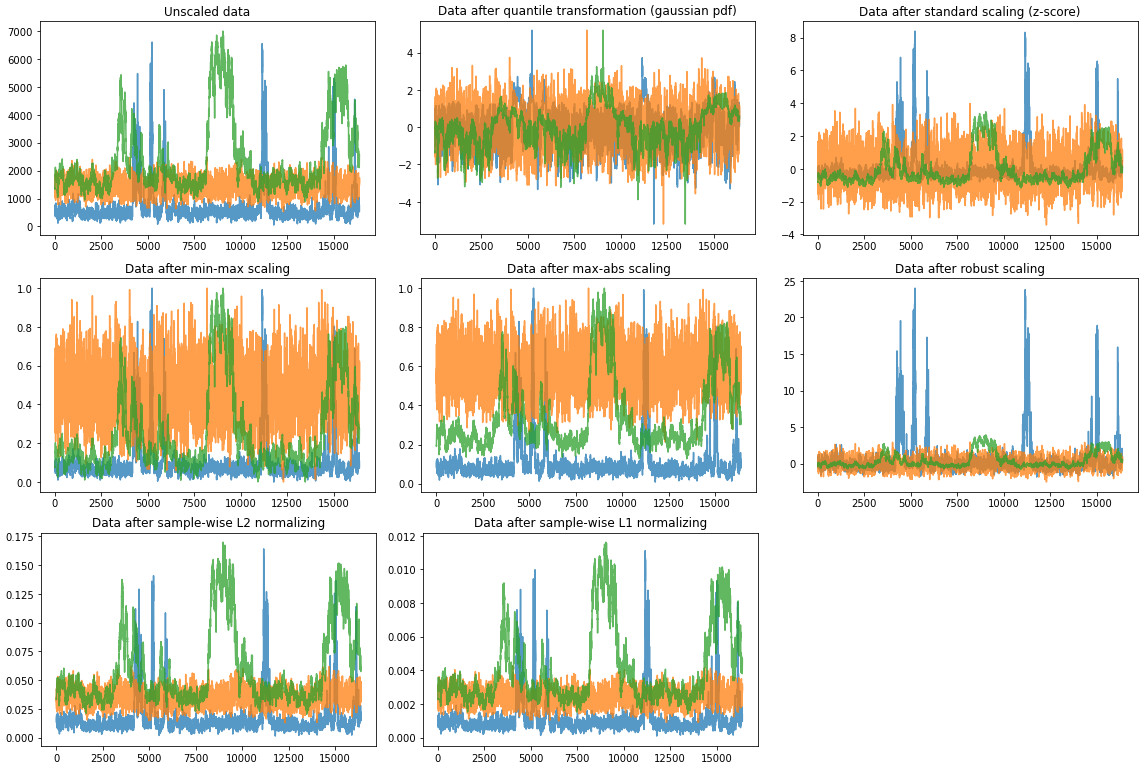
</details>


INFO:__main__:Default advanced parameters enabled
DEBUG:__main__:unet: input shape: (None, None, 1), output shape: (None, None, 1)
DEBUG:__main__:number of examples: 4400
DEBUG:__main__:number of examples: 1200
2023/11/13 16:44:53 INFO mlflow.tracking.fluent: Experiment with name 'test_model-depth6-first_filters23-pool_size4' does not exist. Creating a new experiment.


Epoch 1/2
293/293 [==============================] - 220s 474ms/step - loss: 0.7114 - tp0.1: 8757495.0000 - fp0.1: 12300959.0000 - tn0.1: 49616536.0000 - fn0.1: 1332687.0000 - precision0.1: 0.4159 - recall0.1: 0.8679 - tp0.3: 7600999.0000 - fp0.3: 6424773.0000 - tn0.3: 55492716.0000 - fn0.3: 2489183.0000 - precision0.3: 0.5419 - recall0.3: 0.7533 - tp0.5: 6094145.0000 - fp0.5: 3079954.0000 - tn0.5: 58837556.0000 - fn0.5: 3996037.0000 - precision0.5: 0.6643 - recall0.5: 0.6040 - tp0.7: 4392604.0000 - fp0.7: 1157420.0000 - tn0.7: 60760072.0000 - fn0.7: 5697578.0000 - precision0.7: 0.7915 - recall0.7: 0.4353 - tp0.9: 1842460.0000 - fp0.9: 174905.0000 - tn0.9: 61742616.0000 - fn0.9: 8247722.0000 - precision0.9: 0.9133 - recall0.9: 0.1826 - accuracy0.5: 0.9017 - auc: 0.8897 - f10.5: 0.6327 - val_loss: 1.4243 - val_tp0.1: 2317614.0000 - val_fp0.1: 3866322.0000 - val_tn0.1: 12932332.0000 - val_fn0.1: 544532.0000 - val_precision0.1: 0.3748 - val_recall0.1: 0.8097 - val_tp0.3: 2300013.0000 - va

2023/11/13 16:50:54 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: Changing param values is not allowed. Param with key='batch_size' was already logged with value='15' for run ID='4ffe3304ad9941deb01823f099f69da2'. Attempted logging new value 'None'.
/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
2023/11/13 16:50:54 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


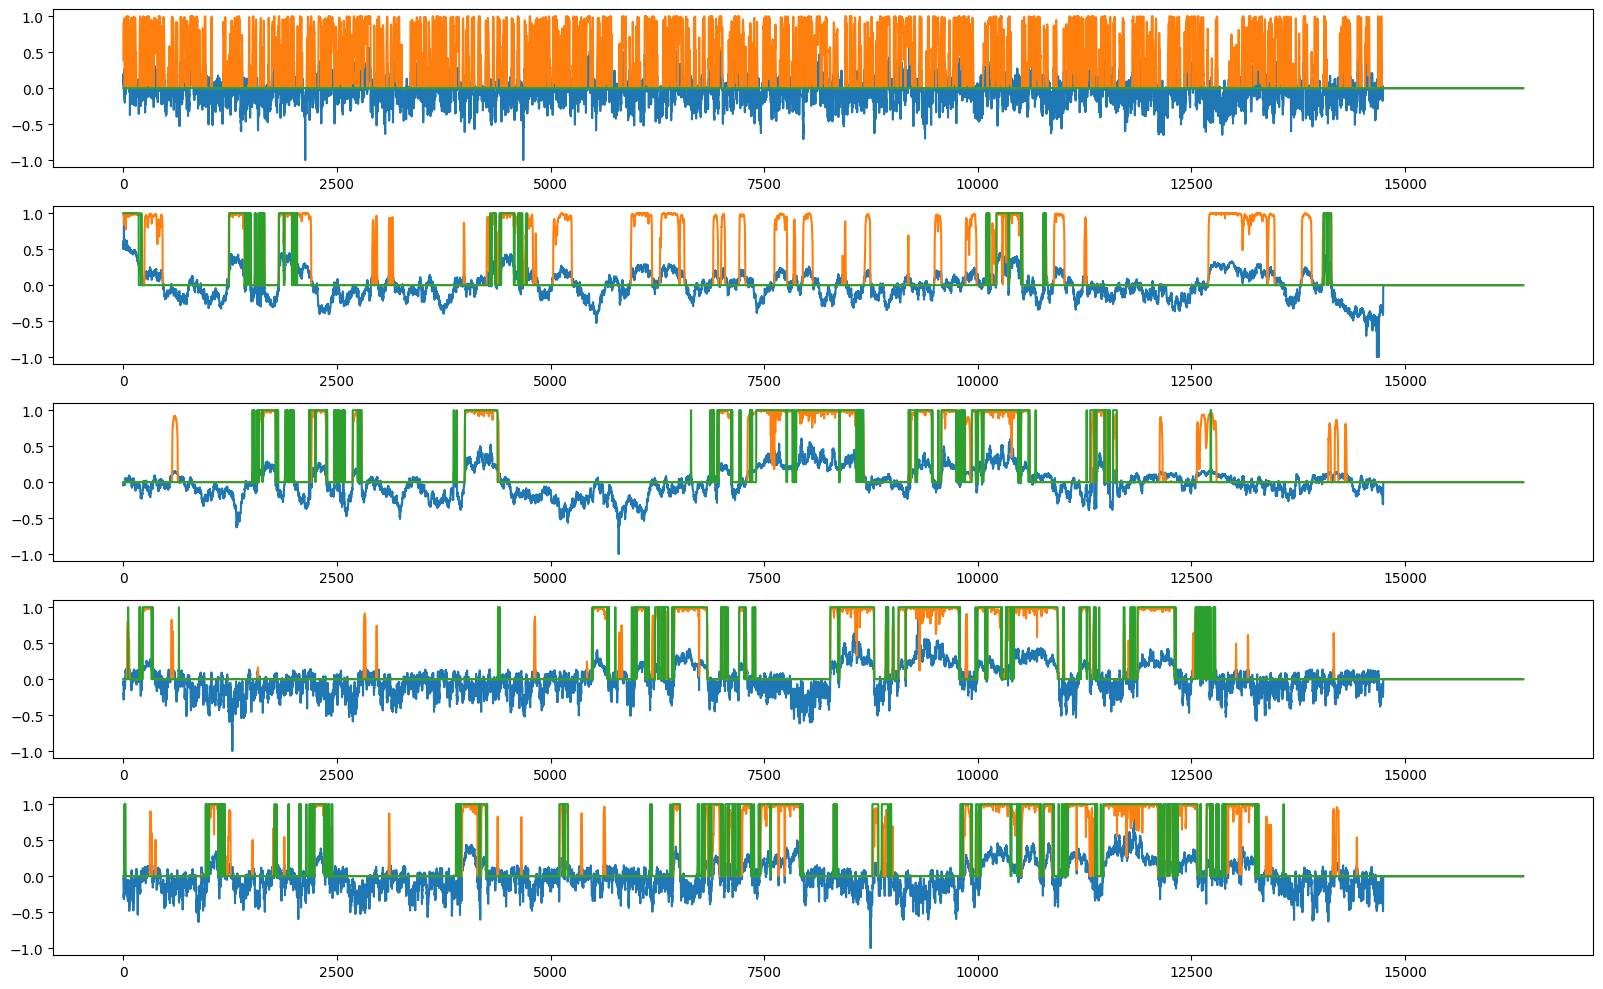

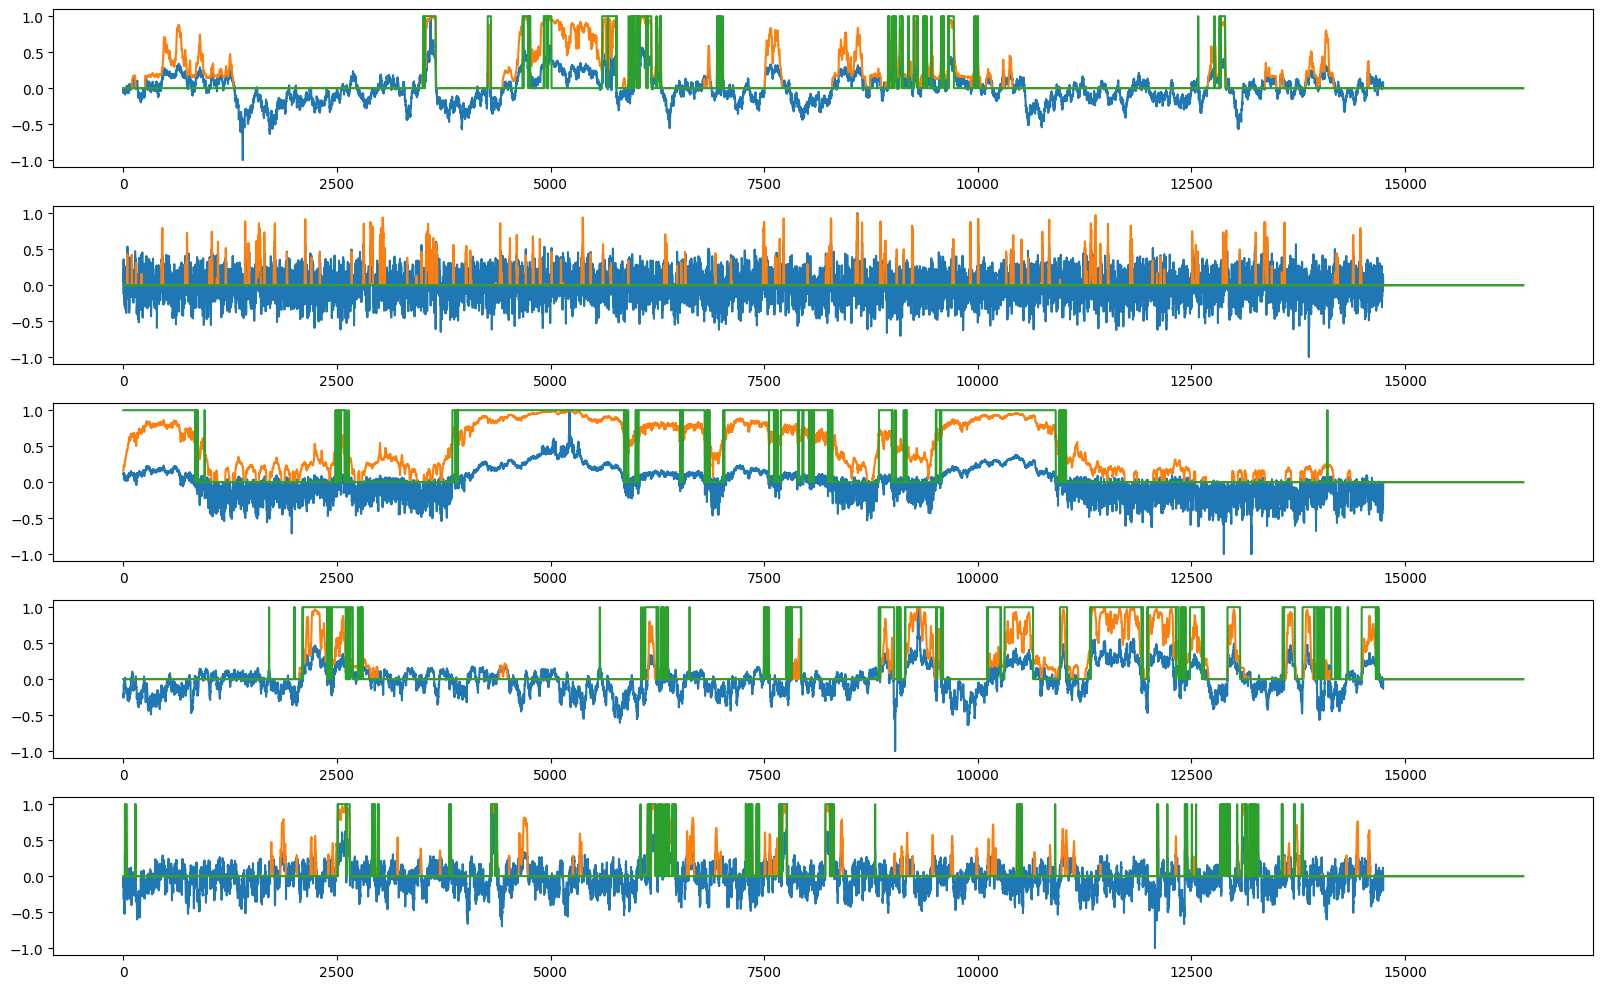

In [ ]:
#@title  { display-mode: "form" }
# ---------------------------- GET USER INPUT --------------------------------
#@markdown ## Basic Training Parameters
#@markdown * `model_name`: Choose any name you wish. Mlflow logging ensures that
#@markdown two models with the same name are still logged seperately.
model_name = "test_model" #@param {type:"string"}
#@markdown * `out_path`: Path to create a mlflow tracking URI. See
#@markdown [Section 2.4.](#scrollTo=jVGckx7ojEP2) on how mlflow stores model data and metadata
out_path = "/content/" #@param {type:"string"}
out_path = Path(out_path)
model_path = out_path / 'mlruns'
mlflow.set_tracking_uri(model_path)

#@markdown * `use_pretrained_model`: Enables re-training a model loaded prior in
#@markdown [Section 2.4.](#scrollTo=jVGckx7ojEP2). Either `use_all_layers` to resume training
#@markdown of the entire model. Alternatively, `freeze_decoder_layers` to only
#@markdown the U-Net encoder (An experimental option which has shown to be useful
#@markdown in [segmenting ultrasound images with a 2D-Unet](https://arxiv.org/pdf/2002.08438.pdf)
use_pretrained_model = "no - train from scratch" #@param ["no - train from scratch", "yes - use all layers", "yes - freeze decoder layers"]
upm_dict = {
    'no - train from scratch': False,
    'yes - use all layers': 'use_all_layers',
    'yes - freeze decoder layers': 'freeze_decoder_layers'
}
use_pretrained_model = upm_dict.get(use_pretrained_model)
#@markdown * `epochs`: An epoch is a whole iteration through the training data.
#@markdown For FCS artifact segmentation, good results can already be observed
#@markdown with only 20 epochs, a more secure number is 100 epochs.
epochs =  2 #@param {type:"integer"}

#@markdown ## Advanced Parameters
#@markdown * You can either define the advanced parameters below, or tick the
#@markdown following box. Then the parameters which performed best in the
#@markdown accompanying paper are chosen.
use_default_advanced_parameters = True #@param {type:"boolean"}

#@markdown ### If not, please input:
#@markdown * `batch_size` defines the number of traces seen in each training
#@markdown step. Smaller batch sizes may improve training performance slightly,
#@markdown but may increase training time. **Default: 15**
batch_size =  5#@param {type:"integer"}
#@markdown * `scaler` is a feature normalizer applied to all FCS time-series for
#@markdown training and evaluation. **Default: quant_g**
scaler = "standard" #@param ['standard', 'robust', 'maxabs', 'quant_g', 'minmax', 'l1', 'l2']
#@markdown * `lr_start` and `lr_power` allow to create a learning rate schedule
#@markdown according to:
#@markdown ```python
#@markdown lr_start * (1 - current_epoch / epochs)**lr_power
#@markdown ```
#@markdown  **Defaults: lr_start=0.03, lr_power=7**
lr_start = 1e-5 #@param {type:"number"}
lr_power = 1 #@param {type:"integer"}
#@markdown * `n_levels`, `first_filters`, and `pool_size` are hyperparameters
#@markdown defining the U-Net architecture. If a pretrained model is used, these
#@markdown parameters are inferred from the pretrained model, no matter which
#@markdown values are chosen here. **Defaults: n_levels=6, first_filters=23,
#@markdown pool_size=4**
n_levels = 5 #@param {type:"integer"}
first_filters = 64 #@param {type:"integer"}
pool_size = 2 #@param {type:"integer"}

# ------------------------ SET DEFAULT VALUES ---------------------------------

METRICS_THRESHOLDS = [0.1, 0.3, 0.5, 0.7, 0.9]
INITIAL_EPOCH = 0

if use_default_advanced_parameters:

    log.info("Default advanced parameters enabled")
    batch_size = 15
    first_filters = 23
    lr_start = 0.03
    lr_power = 7
    scaler = 'quant_g'
    n_levels = 6
    pool_size = 4

# The U-Net is trained to accept arbitrary input sizes, even though the
# architecture demands the size to be >= 1024 and a power of two (2**11, 2**12, ...).
# To achieve this, the arbitrary-length user input is padded with the median
# of the trace to such a power of 2 or at least 1024. For training, we simulate
# this padding by shortening the 16384-length traces (exactly 2**14) by 10%
# with the variable `crop_size`
crop_size = int(len(train_source) - np.ceil(0.1 * len(train_source)))

model_kwargs = dict(n_levels=n_levels,
                    first_filters=first_filters,
                    pool_size=pool_size,
                    metrics_thresholds=METRICS_THRESHOLDS)

mlflow_kwargs = dict(train_data=train_source,
                     train_labels=train_target_bool,
                     val_data=val_source,
                     val_labels=val_target_bool,
                     train_experiment_params=experiment_params_train,
                     val_experiment_params=experiment_params_val,
                     batch_size=batch_size,
                     crop_size=crop_size,
                     lr_start=lr_start,
                     lr_power=lr_power,
                     epochs=epochs,
                     initial_epoch=INITIAL_EPOCH,
                     scaler=scaler,
                     name=model_name)

# --------------------------- PRELOAD MODEL ---------------------------------
if use_pretrained_model:
    try:
        if all([paths, exps, runs, models, clients]):
            pass
        else:
            paths, exps, runs, models, clients = get_all_mlflow_models()
    except NameError:
        paths, exps, runs, models, clients = get_all_mlflow_models()

    if not all([paths, exps, runs, models, clients]):
        log.debug('No valid mlflow-logged model found. No '
                  'pretrained network will be used.')
        use_pretrained_model = False


# --------------------- Download the a model provided in the XXX ------------------------


train_click = TrainClick(mlflow_kwargs=mlflow_kwargs)
if use_pretrained_model:
    train_click.finetune_model(runs=runs, models=models, clients=clients,
                               finetuning=use_pretrained_model)
    def train_pdf_export_wrapper(change):
        return train_pdf_export(train_click, out_path=out_path)
    train_click.button.on_click(train_pdf_export_wrapper)
else:
    train_click.train_from_scratch(model_kwargs=model_kwargs)
    train_pdf_export(train_click, out_path)

# **5. Evaluate your model**
---

<font size = 4>This section allows the user to perform important quality checks on the validity and generalisability of the trained model.

<font size = 4>**We highly recommend to perform quality control on all newly trained models.**



## **5.1. Inspection of training metrics**
---
### **a) loss function**
<font size = 4>First, it is good practice to evaluate the training progress by comparing the training loss with the validation loss. The latter is a metric which shows how well the network performs on a subset of unseen data which is set aside from the training dataset. For more information on this, see for example [this review](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6381354/) by Nichols *et al.*

<font size = 4>**Training loss** describes an error value after each epoch for the difference between the model's prediction and its ground-truth target.

<font size = 4>**Validation loss** describes the same error value between the model's prediction on a validation image and compared to it's target.

<font size = 4>During training both values should decrease before reaching a minimal value which does not decrease further even after more training. Comparing the development of the validation loss with the training loss can give insights into the model's performance.

<font size = 4>Decreasing **Training loss** and **Validation loss** indicates that training is still necessary and increasing the number of `epochs` is recommended. Note that the curves can look flat towards the right side, just because of the y-axis scaling. The network has reached convergence once the curves flatten out. After this point no further training is required. If the **Validation loss** suddenly increases again an the **Training loss** simultaneously goes towards zero, it means that the network is overfitting to the training data. In other words the network is remembering the exact patterns from the training data and no longer generalizes well to unseen data. In this case the training dataset has to be increased.

### **b) other metrics**
<font size = 4>The following other metrics are logged here:
- <font size = 4>**True Negatives**, **False Negatives**, **False Positives**, **True Positives**, **Accuracy**, **Precision**, **Recall** (all at a prediction threshold of 0.5) $\to$ for a good breakdown see [here](https://en.wikipedia.org/wiki/Precision_and_recall)
- <font size = 4>**Area und the ROC curve (AUC)** $\to$ for a good breakdown see [here](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)

In [9]:
#@title  { run: "auto" }
#@title  { display-mode: "form" }

#@markdown ## Run this cell to check metrics of the current run
#@markdown **NOTE: the published models do not include training metrics
#@markdown and can not be analyzed here**

# ----------------------- GET USER INPUT ---------------------------------
# #@markdown ## Input
# #@markdown * Choose if you want to use the last trained model from
# #@markdown [Section 4](#scrollTo=GyRjBdClimfK).
# #@markdown If not ticked, this will scan the /content/ directory for mlflow
# #@markdown models (as in [Section 2.4.](#scrollTo=C2-nD03olfmq&line=1&uniqifier=1)).
# #@markdown You can then choose a valid run below
# use_the_current_trained_model = False #@param {type:"boolean"}

use_the_current_trained_model = True
#---------------------------- DO THE THING ------------------------------

if use_the_current_trained_model:
    try:
        run = mlflow.get_run(train_click.run.info.run_id)
        exp = train_click.exp
        paths, exps, runs, models, clients = get_current_run_and_model(exp, run)
    except (AttributeError, NameError):
        print('Please first execute Section 4 to train a model. Note: the '
              'published models do not include training metrics and can not be '
              'analyzed here.')
else:
    try:
        if all([paths, exps, runs, models, clients]):
            pass
        else:
            paths, exps, runs, models, clients = get_all_mlflow_models()
    except NameError:
        paths, exps, runs, models, clients = get_all_mlflow_models()


try:
    evaluate_click.display_widgets_train_metrics()
except NameError:
    evaluate_click = EvaluateClick(runs=runs, models=models, clients=clients)
    evaluate_click.display_widgets_train_metrics()


DEBUG:__main__:Found metrics for model test_model with scaler quant_g from run 4ffe3304ad9941deb01823f099f69da2


Please first execute Section 4 to train a model. Note: the published models do not include training metrics and can not be analyzed here.


## **5.2. Quality metrics estimation**
---
<font size = 4>This section will calculate the Intersection over Union score for the quality control dataset provided below in `path_to_source_and_target`.

<font size = 4> The **Intersection over Union** metric is a method that can be used to quantify the percent overlap between the target mask and your prediction output. **Therefore, the closer to 1, the better the performance.** This metric can be used to assess the quality of your model to accurately predict FCS artifacts.

<font size = 4> Two further plots will showcase the input, ground truth, and prediction together with the IoU-Value:
- <font size=4> 6 Random examples
- 6 Examples with the worst IoU-Values

### **Thresholds for image masks**

<font size = 4> Since the output from Unet is not a binary mask, the output images are converted to binary masks using thresholding. This section will test different thresholds (from 0.1 to 0.9 in 0.1-steps) to find the one yielding the best IoU score compared with the ground truth. The best threshold for each image and the average of these thresholds will be displayed below. **These values can be a guideline when creating masks for unseen data in [Section 6](#scrollTo=fB8QNLekkCyZ).**

In [2]:
# @title  { display-mode: "form" }

# ------------- User input ------------
#@markdown ## Load test data / quality control data
#@markdown * Paste the path to the folder containing the simulated FCS test data
#@markdown (see download helper for published dataset in [Section 2.3](#scrollTo=6zv2yWb5QM4I)).
#@markdown This should be data which was NOT seen before by the model during
#@markdown training or validation. To find the paths of the folders
#@markdown containing the respective dataset, go to your Files on the left of
#@markdown the notebook, navigate to the folder containing your files and copy
#@markdown the path by right-clicking on the folder, **Copy path** and pasting
#@markdown it into the right box below.
path_to_source_and_target = "/content/gdrive/MyDrive/unet-for-fcs/data/2020-11-FCS-peak-artifacts-dataset-test-split" #@param{type:"string"}
# #@markdown * The simulated data from [Section 3.0](#scrollTo=hMZpkgEDKA5n)
# #@markdown contains test source (FCS time-series) and 1 or 2 targets (labels for
# #@markdown either training a unet, a variational autoencoder, or both). Provide
# #@markdown the number of targets below so that the data is read in correctly:
# n_targets = 2 #@param ["1", "2"] {type:"raw"}
n_targets = 2
# #@markdown * The simulated data from [Section 3.0](#scrollTo=hMZpkgEDKA5n)
# #@markdown supports training the detection of 3 different artifacts, please state
# #@markdown which one should be read in:
# artifact = "peak_artifact" #@param ["peak_artifact", "detector_dropout", "photobleaching"]
artifact = 'peak_artifact'
#@markdown ## Load model
#@markdown * Tick the following, if you want to use the last trained model from
#@markdown [Section 4.](#scrollTo=GyRjBdClimfK)
#@markdown If not ticked, this will scan the `/content/` directory for mlflow
#@markdown models (as in [Section 2.4.](#scrollTo=jVGckx7ojEP2)).
#@markdown Afterwards, you can choose a valid run below.
use_the_current_trained_model = False #@param {type:"boolean"}
#@markdown ## Save training metrics and quality control to PDF
#@markdown * If ticked, provide an output path
save_qc = True #@param {type:"boolean"}
output_path = '/content/' #@param {type:"string"}
output_path = Path(output_path)

if save_qc:
    if not output_path.exists():
        raise OSError(f'{output_path=} does not exist.')

#---------------------------- LOAD MODEL -----------------------------
if use_the_current_trained_model:
    run = mlflow.get_run(train_click.run.info.run_id)
    exp = train_click.exp
    paths, exps, runs, models, clients = get_current_run_and_model(exp, run)
else:
    try:
        if all([paths, exps, runs, models, clients]):
            pass
        else:
            paths, exps, runs, models, clients = get_all_mlflow_models()
    except NameError:
        paths, exps, runs, models, clients = get_all_mlflow_models()

# -------------------------- COMPUTE STUFF --------------------------------


source, target_bool, _, ep_test = load_source_and_target_from_simulations(
    path=path_to_source_and_target, artifact=artifact, n_targets=n_targets)

evaluate_click = EvaluateClick(runs=runs, models=models, clients=clients)
evaluate_click.display_widgets_qc_metrics(source=source,
                                          target=target_bool,
                                          with_metrics=save_qc,
                                          experiment_params=ep_test)

if save_qc:
    def qc_pdf_export_wrapper(change):
        return qc_pdf_export(evaluate_click, out_path=output_path)
    evaluate_click.button.on_click(qc_pdf_export_wrapper)

DEBUG:__main__:Start scanning all paths in the "/content/" directory for mlflow experiments. Depending on the size of the file system / GDrive, this may take a while...


0it [00:00, ?it/s]

DEBUG:__main__:Finished collecting potential paths. Start collecting experiments...
DEBUG:__main__:found 2 experiments
DEBUG:__main__:checking experiment <Experiment: artifact_location='file:///content/mlruns/117203100010862861', creation_time=1699893893750, experiment_id='117203100010862861', last_update_time=1699893893750, lifecycle_stage='active', name='test_model-depth6-first_filters23-pool_size4', tags={}> for runs
DEBUG:__main__:checking experiment <Experiment: artifact_location='file:///content/mlruns/0', creation_time=1699893893739, experiment_id='0', last_update_time=1699893893739, lifecycle_stage='active', name='Default', tags={}> for runs
DEBUG:__main__:checking run 4ffe3304ad9941deb01823f099f69da2
DEBUG:__main__:found 1 runs
DEBUG:__main__:found 1 experiments
DEBUG:__main__:checking experiment <Experiment: artifact_location='file:./data/mlruns/10', creation_time=None, experiment_id='10', last_update_time=None, lifecycle_stage='active', name='exp-220227-unet', tags={}> for r

0it [00:00, ?it/s]

DEBUG:__main__:Reading 30 files from folder /content/gdrive/MyDrive/unet-for-fcs/data/2020-11-FCS-peak-artifacts-dataset-test-split


  0%|          | 0/30 [00:00<?, ?it/s]

DEBUG:__main__:The given DataFrame was split into 3 parts (source, target, target) with shapes: [(16384, 3000), (16384, 3000), (16384, 3000)]


# **6. Using the trained model**

---

<font size=4> Fill the below code to perform predictions using **1D U-Net for FCS**. In this section the unseen data is processed using your trained model from [Section 4.](#scrollTo=GyRjBdClimfK) or a loaded model from [Section 2.4.](#scrollTo=jVGckx7ojEP2).

## **6.1a. Apply at TCSPC dataset (.ptu data)**
---
<font size=4> Time-Correlated Single Photon Counting (TCSPC) measurements are an important type of data record in microscopy. For each photon that hits the detector after an excitation laser pulse, it logs two properties:
1. <font size=4> **macrotime**: the time after the begin of the measurement. In FCS, macrotimes are correlated to get FCS correlation curves, which are later fitted by theoretical models to extract physical properties such as the diffusion time or molecule number.
2. **microtime**: the time after the laser pulse. This property is important for e.g. lifetime measurements. Here, it is discarded.

<font size=4> Correcting FCS data in TCSPC format, the following steps are important:
1. <font size=4>Execute the *Setup* cells, because a fast Cython algorithm is used to improve the computation time for TCSPC correlations.
2. Load the *.ptu* data in [Step 1](#scrollTo=w17NWhLjuzBX). A helper function will plot a binned time-series, the photon count decay function, and an autocorrelation function.
3. Process the loaded file in [Step 2](#scrollTo=dyI-XR5iGyJq). Here, the magic happens:
  - <font size=4> choose a segmentation method (either U-Net for FCS or simple thresholding as a comparison)
  - choose a correction method (**cut_and_stitch** has proven to be the best in the accompanying paper, but the other options described there are available as well).
  - if further input is needed, you can provide it after executing the cell.

<font size=4> **Note: With this GUI, only 1 trace can be processed at a time. The underlying functions easily allow batch processing, as shown in [Seltmann et al (link TBD)]().**


In [3]:
#@title { display-mode: "form" }
#@markdown ## Setup 1: Load Cython for fast TCSPC correlation algorithm

%load_ext cython


In [4]:
#@title { display-mode: "form" }
#@markdown ## Setup 2: Load divide and conquer fast intersection algorithm for TCSPC correlation

%%cython
import cython
cimport cython

import numpy as np
cimport numpy as np

DTYPE = np.float64
ctypedef np.float64_t DTYPE_t

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.nonecheck(False)
def dividAndConquer(arr1b,arr2b,arrLength):
    """divide and conquer fast intersection algorithm. Waithe D 2014"""

    cdef np.ndarray[DTYPE_t, ndim=1] arr1bool = np.zeros((arrLength-1))
    cdef np.ndarray[DTYPE_t, ndim=1] arr2bool = np.zeros((arrLength-1))
    cdef np.ndarray[DTYPE_t, ndim=1] arr1 = arr1b
    cdef np.ndarray[DTYPE_t, ndim=1] arr2 = arr2b

    cdef int arrLen
    arrLen = arrLength;
    cdef int i
    i = 0;
    cdef int j
    j = 0;

    while(i <arrLen-1 and j< arrLen-1):
        if(arr1[i] < arr2[j]):
          i+=1;
        elif(arr2[j] < arr1[i]):
          j+=1;
        elif (arr1[i] == arr2[j]):
          arr1bool[i] = 1;
          arr2bool[j] = 1;
          i+=1;
    return arr1bool,arr2bool


Content of stderr:
In file included from /usr/local/lib/python3.10/dist-packages/numpy/core/include/numpy/ndarraytypes.h:1948,
                 from /usr/local/lib/python3.10/dist-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /usr/local/lib/python3.10/dist-packages/numpy/core/include/numpy/arrayobject.h:5,
                 from /root/.cache/ipython/cython/_cython_magic_386dfd0d81e156967f328d5672ebbbf53379c88a.c:1215:
/usr/local/lib/python3.10/dist-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
   17 | #warning "Using deprecated NumPy API, disable it with " \
      |  ^~~~~~~

In [5]:
#@title { run: "auto", display-mode: "form" }
#@markdown ## Step 1: Load and inspect TCSPC file
# --------------------------- READING PTU DATA ---------------------
def import_ptu(inputfilepath, outputfilepath=None, verbose=True):
    """imports PicoQuant ptu files and returns the contents as numpy arrays.

    Parameters
    ----------
    inputfilepath : str
        Path to PTU file to read
    outputfilepath : str, optional
        If outputfilepath is given, the metadata is printed in the given file.
    verbose : bool
        if True, prints out information while processing

    Returns
    -------
    outdict : dict of np.arrays
        outdict['trueTimeArr']: the macro time in ns (absolute time when each
        photon arrived)
        outdict['dTimeArr']: the micro time in ns (lifetime of each photon)
        outdict['chanArr']: number of channel where photon was detected
    tagDataList : list of tuples of tag name and tag value
        metadata from ptu header
    numRecords : int
        number of detected photons
    globRes : float
        resolution in seconds

    Notes
    -----
    - Code is adopted from:
    https://github.com/PicoQuant/PicoQuant-Time-Tagged-File-Format-Demos/blob/master/PTU/Python/Read_PTU.py
    - original doc:
    # Read_PTU.py    Read PicoQuant Unified Histogram Files
    # This is demo code. Use at your own risk. No warranties.
    # Keno Goertz, PicoQUant GmbH, February 2018

    # Note that marker events have a lower time resolution and may therefore
    # appear in the file slightly out of order with respect to regular (photon)
    # event records. This is by design. Markers are designed only for
    # relatively coarse synchronization requirements such as image scanning.

    # T Mode data are written to an output file [filename]
    # We do not keep it in memory because of the huge amout of memory
    # this would take in case of large files. Of course you can change this,
    # e.g. if your files are not too big. Otherwise it is best process the
    # data on the fly and keep only the results.
    """
    # Tag Types
    tyEmpty8 = struct.unpack(">i", bytes.fromhex("FFFF0008"))[0]
    tyBool8 = struct.unpack(">i", bytes.fromhex("00000008"))[0]
    tyInt8 = struct.unpack(">i", bytes.fromhex("10000008"))[0]
    tyBitSet64 = struct.unpack(">i", bytes.fromhex("11000008"))[0]
    tyColor8 = struct.unpack(">i", bytes.fromhex("12000008"))[0]
    tyFloat8 = struct.unpack(">i", bytes.fromhex("20000008"))[0]
    tyTDateTime = struct.unpack(">i", bytes.fromhex("21000008"))[0]
    tyFloat8Array = struct.unpack(">i", bytes.fromhex("2001FFFF"))[0]
    tyAnsiString = struct.unpack(">i", bytes.fromhex("4001FFFF"))[0]
    tyWideString = struct.unpack(">i", bytes.fromhex("4002FFFF"))[0]
    tyBinaryBlob = struct.unpack(">i", bytes.fromhex("FFFFFFFF"))[0]

    # Record types
    # SubID: $00, RecFmt: $01 (V1) - or - SubID: $01, RecFmt: $01 (V2)
    # T-Mode: $02 (T2) - or - $03 (T3)
    # HW = $03 (PicoHarp), HW: $04 (HydraHarp), HW: $05 (TimeHarp260N)
    # HW: $06 (TimeHarp260P), HW: $07 (MultiHarp)
    rtPicoHarpT3 = struct.unpack(">i", bytes.fromhex('00010303'))[0]
    rtPicoHarpT2 = struct.unpack(">i", bytes.fromhex('00010203'))[0]
    rtHydraHarpT3 = struct.unpack(">i", bytes.fromhex('00010304'))[0]
    rtHydraHarpT2 = struct.unpack(">i", bytes.fromhex('00010204'))[0]
    rtHydraHarp2T3 = struct.unpack(">i", bytes.fromhex('01010304'))[0]
    rtHydraHarp2T2 = struct.unpack(">i", bytes.fromhex('01010204'))[0]
    rtTimeHarp260NT3 = struct.unpack(">i", bytes.fromhex('00010305'))[0]
    rtTimeHarp260NT2 = struct.unpack(">i", bytes.fromhex('00010205'))[0]
    rtTimeHarp260PT3 = struct.unpack(">i", bytes.fromhex('00010306'))[0]
    rtTimeHarp260PT2 = struct.unpack(">i", bytes.fromhex('00010206'))[0]
    rtMultiHarpT3 = struct.unpack(">i", bytes.fromhex('00010307'))[0]
    rtMultiHarpT2 = struct.unpack(">i", bytes.fromhex('00010207'))[0]

    # if len(sys.argv) != 3:
    #    print("USAGE: Read_PTU.py inputfile.PTU outputfile.txt")
    #    exit(0)

    if outputfilepath is not None:
        # The following is needed for support of wide strings
        outputfile = io.open(outputfilepath, "w+", encoding="utf-16le")

    with open(inputfilepath, "rb") as f:
        # Check if inputfile is a valid PTU file
        # Python strings don't have terminating NULL characters, so they're
        # stripped
        magic = f.read(8).decode("utf-8").strip('\0')
        if magic != "PQTTTR":
            f.close()
            raise ValueError("ERROR: Magic invalid, this is not a PTU file.")

        version = f.read(8).decode("utf-8").strip('\0')
        if outputfilepath is not None:
            outputfile.write("Tag version: %s\n" % version)

        # Write the header data to outputfile and also save it in memory.
        # There's no do ... while in Python, so an if statement inside the
        # while loop breaks out of it
        tagDataList = []  # Contains tuples of (tagName, tagValue)
        while True:
            tagIdent = f.read(32).decode("utf-8").strip('\0')
            tagIdx = struct.unpack("<i", f.read(4))[0]
            tagTyp = struct.unpack("<i", f.read(4))[0]
            if tagIdx > -1:
                evalName = tagIdent + '(' + str(tagIdx) + ')'
            else:
                evalName = tagIdent
            if outputfilepath is not None:
                outputfile.write("\n%-40s" % evalName)
            if tagTyp == tyEmpty8:
                f.read(8)
                if outputfilepath is not None:
                    outputfile.write("<empty Tag>")
                tagDataList.append((evalName, "<empty Tag>"))
            elif tagTyp == tyBool8:
                tagInt = struct.unpack("<q", f.read(8))[0]
                if tagInt == 0:
                    if outputfilepath is not None:
                        outputfile.write("False")
                    tagDataList.append((evalName, "False"))
                else:
                    if outputfilepath is not None:
                        outputfile.write("True")
                    tagDataList.append((evalName, "True"))
            elif tagTyp == tyInt8:
                tagInt = struct.unpack("<q", f.read(8))[0]
                if outputfilepath is not None:
                    outputfile.write("%d" % tagInt)
                tagDataList.append((evalName, tagInt))
            elif tagTyp == tyBitSet64:
                tagInt = struct.unpack("<q", f.read(8))[0]
                if outputfilepath is not None:
                    outputfile.write("{0:#0{1}x}".format(tagInt, 18))
                tagDataList.append((evalName, tagInt))
            elif tagTyp == tyColor8:
                tagInt = struct.unpack("<q", f.read(8))[0]
                if outputfilepath is not None:
                    outputfile.write("{0:#0{1}x}".format(tagInt, 18))
                tagDataList.append((evalName, tagInt))
            elif tagTyp == tyFloat8:
                tagFloat = struct.unpack("<d", f.read(8))[0]
                if outputfilepath is not None:
                    outputfile.write("%-3E" % tagFloat)
                tagDataList.append((evalName, tagFloat))
            elif tagTyp == tyFloat8Array:
                tagInt = struct.unpack("<q", f.read(8))[0]
                if outputfilepath is not None:
                    outputfile.write("<Float array with %d entries>" % tagInt /
                                     8)
                tagDataList.append((evalName, tagInt))
            elif tagTyp == tyTDateTime:
                tagFloat = struct.unpack("<d", f.read(8))[0]
                tagTime = int((tagFloat - 25569) * 86400)
                tagTime = time.gmtime(tagTime)
                if outputfilepath is not None:
                    outputfile.write(
                        time.strftime("%a %b %d %H:%M:%S %Y", tagTime))
                tagDataList.append((evalName, tagTime))
            elif tagTyp == tyAnsiString:
                tagInt = struct.unpack("<q", f.read(8))[0]
                tagString = f.read(tagInt).decode("utf-8").strip("\0")
                # Alternative: I found a weird character in the ANSI once,
                # which was solved by changeing to windows.
                # TagString = str.replace(TagString.decode('windows-1252'),
                #                        '\x00', '')
                if outputfilepath is not None:
                    outputfile.write("%s" % tagString)
                tagDataList.append((evalName, tagString))
            elif tagTyp == tyWideString:
                tagInt = struct.unpack("<q", f.read(8))[0]
                tagString = f.read(tagInt).decode("utf-16le",
                                                  errors="ignore").strip("\0")
                if outputfilepath is not None:
                    outputfile.write(tagString)
                tagDataList.append((evalName, tagString))
            elif tagTyp == tyBinaryBlob:
                tagInt = struct.unpack("<q", f.read(8))[0]
                if outputfilepath is not None:
                    outputfile.write("<Binary blob with %d bytes>" % tagInt)
                tagDataList.append((evalName, tagInt))
            else:
                raise ValueError("ERROR: Unknown tag type")
            if tagIdent == "Header_End":
                break

        # Reformat the saved data for easier access
        tagNames = [tagDataList[i][0] for i in range(0, len(tagDataList))]
        tagValues = [tagDataList[i][1] for i in range(0, len(tagDataList))]

        # get important variables from headers
        numRecords = tagValues[tagNames.index("TTResult_NumberOfRecords")]
        globRes = tagValues[tagNames.index("MeasDesc_GlobalResolution")]
        resolution = tagValues[tagNames.index("MeasDesc_Resolution")]

        if verbose:
            log.debug("import_ptu: Writing %d records, this may take a while.",
                      numRecords)

        # prepare dictionary as output of function, if no outputfile is given
        if outputfilepath is None:
            outdict = {}
            outdict['trueTimeArr'] = np.zeros(numRecords, dtype=object)
            outdict['dTimeArr'] = np.zeros(numRecords, dtype=object)
            outdict['chanArr'] = np.zeros(numRecords, dtype=object)
            outdict['resolution'] = None
            out = outdict
        else:
            out = False

        if outputfilepath is not None:
            outputfile.write("\n-----------------------\n")
        recordType = tagValues[tagNames.index("TTResultFormat_TTTRRecType")]
        if recordType == rtPicoHarpT2:
            if verbose:
                log.debug("import_ptu: PicoHarp T2 data")
            if outputfilepath is not None:
                outputfile.write("PicoHarp T2 data\n")
                outputfile.write("\nrecord# chan   nsync truetime/ps\n")
                readPT2(f, numRecords, globRes, isT2=True, verbose=verbose,
                        outputfile=outputfile)
            else:
                readPT2(f, numRecords, globRes, isT2=True, verbose=verbose,
                        outdict=outdict)
        elif recordType == rtPicoHarpT3:
            if verbose:
                log.debug("import_ptu: PicoHarp T3 data")
            if outputfilepath is not None:
                outputfile.write("PicoHarp T3 data\n")
                outputfile.write("\nrecord# chan   nsync truetime/ns dtime\n")
                readPT3(f, numRecords, globRes, resolution, isT2=False,
                        verbose=verbose, outputfile=outputfile)
            else:
                readPT3(f, numRecords, globRes, resolution, isT2=False,
                        verbose=verbose, outdict=outdict)
        elif recordType == rtHydraHarpT2:
            if verbose:
                log.debug("import_ptu: HydraHarp V1 T2 data")
            if outputfilepath is not None:
                outputfile.write("HydraHarp V1 T2 data\n")
                outputfile.write("\nrecord# chan   nsync truetime/ps\n")
                readHT2(1, f, numRecords, globRes, isT2=True, verbose=verbose,
                        outputfile=outputfile)
            else:
                readHT2(1, f, numRecords, globRes, isT2=True, verbose=verbose,
                        outdict=outdict)
        elif recordType == rtHydraHarpT3:
            if verbose:
                log.debug("import_ptu: HydraHarp V1 T3 data")
            if outputfilepath is not None:
                outputfile.write("HydraHarp V1 T3 data\n")
                outputfile.write("\nrecord# chan   nsync truetime/ns dtime\n")
                readHT3(1, f, numRecords, globRes, resolution, isT2=False,
                        verbose=verbose, outputfile=outputfile)
            else:
                readHT3(1, f, numRecords, globRes, resolution, isT2=False,
                        verbose=verbose, outdict=outdict)
        elif recordType in (rtHydraHarp2T2,  rtTimeHarp260NT2,
                            rtTimeHarp260PT2, rtMultiHarpT2):
            printdict = {rtHydraHarp2T2: "HydraHarp V2 T2 data",
                         rtTimeHarp260NT2: "TimeHarp260N T2 data",
                         rtTimeHarp260PT2: "TimeHarp260P T2 data",
                         rtMultiHarpT2: "MultiHarp T2 data"}
            if verbose:
                log.debug("import_ptu: %s", printdict[recordType])
            if outputfilepath is not None:
                outputfile.write("{}\n".format(printdict[recordType]))
                outputfile.write("\nrecord# chan   nsync truetime/ps\n")
                readHT2(2, f, numRecords, globRes, isT2=True, verbose=verbose,
                        outputfile=outputfile)
            else:
                readHT2(2, f, numRecords, globRes, isT2=True, verbose=verbose,
                        outdict=outdict)
        elif recordType in (rtHydraHarp2T3, rtTimeHarp260NT3,
                            rtTimeHarp260PT3, rtMultiHarpT3):
            printdict = {rtHydraHarp2T3: "HydraHarp V2 T3 data",
                         rtTimeHarp260NT3: "TimeHarp260N T3 data",
                         rtTimeHarp260PT3: "TimeHarp260P T3 data",
                         rtMultiHarpT3: "MultiHarp T3 data"}
            if verbose:
                log.debug("import_ptu: %s", printdict[recordType])
            if outputfilepath is not None:
                outputfile.write("{}\n".format(printdict[recordType]))
                outputfile.write("\nrecord# chan   nsync truetime/ns dtime\n")
                readHT3(2, f, numRecords, globRes, resolution, isT2=False,
                        verbose=verbose, outputfile=outputfile)
            else:
                readHT3(2, f, numRecords, globRes, resolution, isT2=False,
                        verbose=verbose, outdict=outdict)
        else:
            raise ValueError('ERROR: Unknown record type')

        if outputfilepath is not None:
            outputfile.close()
    return out, tagDataList, numRecords, globRes


def gotOverflow(count, recNum, outdict=None, outputfile=None):
    if outputfile is not None:
        outputfile.write('{} OFL * {:2x}\n'.format(recNum, count))
    else:
        outdict['trueTimeArr'][recNum] = ('OFL', count)
        outdict['dTimeArr'][recNum] = ('OFL', count)
        outdict['chanArr'][recNum] = ('OFL', count)


def gotMarker(timeTag, markers, recNum, outdict=None, outputfile=None):
    if outputfile is not None:
        outputfile.write('{} MAR {:2x} {}\n'.format(recNum, markers, timeTag))
    else:
        outdict['trueTimeArr'][recNum] = ('MAR', markers, timeTag)
        outdict['dTimeArr'][recNum] = ('MAR', markers, timeTag)
        outdict['chanArr'][recNum] = ('MAR', markers, timeTag)


def gotPhoton(timeTag,
              channel,
              dtime,
              isT2,
              recNum,
              globRes,
              outdict=None,
              outputfile=None):
    if isT2:
        truetime = timeTag * globRes * 1e12
        if outputfile is not None:
            outputfile.write('{} CHN {:1x} {} {:8.0f}\n'.format(
                             recNum, channel, timeTag, truetime))
        else:
            outdict['trueTimeArr'][recNum] = truetime
            # picoquant demo code does not save out dtime
            # - but for lifetime analysis, it is needed
            outdict['dTimeArr'][recNum] = dtime
            outdict['chanArr'][recNum] = channel
    else:
        truetime = timeTag * globRes * 1e9
        if outputfile is not None:
            outputfile.write('{} CHN {:1x} {} {:8.0f} {:10}\n'.format(
                             recNum, channel, timeTag, truetime, dtime))
        else:
            outdict['trueTimeArr'][recNum] = truetime
            outdict['dTimeArr'][recNum] = dtime
            outdict['chanArr'][recNum] = channel


def readPT2(f,
            numRecords,
            globRes,
            isT2,
            outdict=None,
            outputfile=None,
            verbose=False):
    T2WRAPAROUND = 210698240
    oflcorrection = 0
    for recNum in range(0, numRecords):
        try:
            recordData = "{0:0{1}b}".format(
                struct.unpack("<I", f.read(4))[0], 32)
        except Exception as exc:
            raise ValueError('The file ended earlier than expected, at'
                             f'record {recNum}/{numRecords}.') from exc

        channel = int(recordData[0:4], base=2)
        dtime = int(recordData[4:32], base=2)
        if channel == 0xF:  # Special record
            # lower 4 bits of time are marker bits
            markers = int(recordData[28:32], base=2)
            if markers == 0:  # Not a marker, so overflow
                gotOverflow(1, recNum, outdict, outputfile)
                oflcorrection += T2WRAPAROUND
            else:
                # Actually, the lower 4 bits for the time aren't valid
                # because they belong to the marker. But the error caused
                # by them is so small that we can just ignore it.
                truetime = oflcorrection + dtime
                gotMarker(timeTag=truetime,
                          markers=markers,
                          recNum=recNum,
                          outdict=outdict,
                          outputfile=outputfile)
        else:
            if channel > 4:  # Should not occur
                log.debug("import_ptu: Illegal Channel: #%1d %1u",
                          recNum, channel)
                if outputfile is not None:
                    outputfile.write("\nIllegal channel ")
            truetime = oflcorrection + dtime
            gotPhoton(truetime, channel, dtime, isT2, recNum, globRes, outdict,
                      outputfile)
        if recNum % 1_000_000 == 0:
            if verbose:
                log.debug("import_ptu: Progress: %.1f%%",
                          float(recNum) * 100 / float(numRecords))

    # FIXME: Not sure why globRes is the output here, and resolution in other
    # functions. Should be double-checked later.
    outdict["resolution"] = globRes * 1e6


def readPT3(f,
            numRecords,
            globRes,
            resolution,
            isT2,
            outdict=None,
            outputfile=None,
            verbose=False):
    oflcorrection = 0
    dlen = 0
    T3WRAPAROUND = 65536
    for recNum in range(0, numRecords):
        # The data is stored in 32 bits that need to be divided into
        # smaller groups of bits, with each group of bits representing a
        # different variable. In this case, channel, dtime and nsync. This
        # can easily be achieved by converting the 32 bits to a string,
        # dividing the groups with simple array slicing, and then
        # converting back into the integers.
        try:
            recordData = "{0:0{1}b}".format(
                struct.unpack("<I", f.read(4))[0], 32)
        except Exception as exc:
            raise ValueError('The file ended earlier than expected, at'
                             'record %d/%d.' % (recNum, numRecords)) from exc

        channel = int(recordData[0:4], base=2)
        dtime = int(recordData[4:16], base=2)
        nsync = int(recordData[16:32], base=2)
        if channel == 0xF:  # Special record
            if dtime == 0:  # Not a marker, so overflow
                gotOverflow(1, recNum, outdict, outputfile)
                oflcorrection += T3WRAPAROUND
            else:
                truensync = oflcorrection + nsync
                gotMarker(timeTag=truensync,
                          markers=dtime,
                          recNum=recNum,
                          outdict=outdict,
                          outputfile=outputfile)
        else:
            if channel == 0 or channel > 4:  # Should not occur
                log.debug("import_ptu: Illegal Channel: #%1d %1u",
                          dlen, channel)
                if outputfile is not None:
                    outputfile.write("\nIllegal channel ")
            truensync = oflcorrection + nsync
            gotPhoton(truensync, channel, dtime, isT2, recNum, globRes,
                      outdict, outputfile)
            dlen += 1
        if recNum % 1_000_000 == 0:
            if verbose:
                log.debug("import_ptu: Progress: %.1f%%",
                          float(recNum) * 100 / float(numRecords))
    outdict["resolution"] = resolution * 1e9


def readHT2(version,
            f,
            numRecords,
            globRes,
            isT2,
            outdict=None,
            outputfile=None,
            verbose=False):
    T2WRAPAROUND_V1 = 33552000
    T2WRAPAROUND_V2 = 33554432
    oflcorrection = 0
    for recNum in range(0, numRecords):
        try:
            recordData = "{0:0{1}b}".format(
                struct.unpack("<I", f.read(4))[0], 32)
        except Exception as e:
            raise ValueError('The file ended earlier than expected, at'
                             'record %d/%d.' % (recNum, numRecords)) from e

        special = int(recordData[0:1], base=2)
        channel = int(recordData[1:7], base=2)
        timetag = int(recordData[7:32], base=2)
        if special == 1:
            if channel == 0x3F:  # Overflow
                # Number of overflows in nsync. If old version, it's an
                # old style single overflow
                if version == 1:
                    oflcorrection += T2WRAPAROUND_V1
                    gotOverflow(1, recNum, outdict, outputfile)
                else:
                    # old style overflow, shouldn't happen
                    if timetag == 0:
                        oflcorrection += T2WRAPAROUND_V2
                        gotOverflow(1, recNum, outdict, outputfile)
                    else:
                        oflcorrection += T2WRAPAROUND_V2 * timetag
            if 1 <= channel <= 15:  # markers
                truetime = oflcorrection + timetag
                gotMarker(timeTag=truetime,
                          markers=channel,
                          recNum=recNum,
                          outdict=outdict,
                          outputfile=outputfile)
            if channel == 0:  # sync
                truetime = oflcorrection + timetag
                gotPhoton(truetime, channel, 0, isT2, recNum, globRes, outdict,
                          outputfile)
        else:  # regular input channel
            truetime = oflcorrection + timetag
            gotPhoton(truetime, channel + 1, 0, isT2, recNum, globRes, outdict,
                      outputfile)
        if recNum % 1_000_000 == 0:
            if verbose:
                log.debug("import_ptu: Progress: %.1f%%",
                          float(recNum) * 100 / float(numRecords))
    # FIXME: add correct value for outdict["resolution"]
    outdict["resolution"] = None


def readHT3(version,
            f,
            numRecords,
            globRes,
            resolution,
            isT2,
            outdict=None,
            outputfile=None,
            verbose=False):
    oflcorrection = 0
    T3WRAPAROUND = 1024

    for recNum in range(0, numRecords):
        try:
            recordData = "{0:0{1}b}".format(
                struct.unpack("<I", f.read(4))[0], 32)
        except Exception as e:
            raise ValueError('The file ended earlier than expected, at'
                             'record %d/%d.' % (recNum, numRecords)) from e

        special = int(recordData[0:1], base=2)
        channel = int(recordData[1:7], base=2)
        dtime = int(recordData[7:22], base=2)
        nsync = int(recordData[22:32], base=2)
        if special == 1:
            if channel == 0x3F:  # 0x3F = 63 = Overflow
                # Number of overflows in nsync. If 0 or old version, it's
                # an old style single overflow
                if nsync == 0 or version == 1:
                    oflcorrection += T3WRAPAROUND
                    gotOverflow(1, recNum, outdict, outputfile)
                else:
                    oflcorrection += T3WRAPAROUND * nsync
                    gotOverflow(count=nsync,
                                recNum=recNum,
                                outdict=outdict,
                                outputfile=outputfile)
            if 1 <= channel <= 15:  # markers
                truensync = oflcorrection + nsync
                gotMarker(timeTag=truensync,
                          markers=channel,
                          recNum=recNum,
                          outdict=outdict,
                          outputfile=outputfile)
        else:  # regular input channel
            truensync = oflcorrection + nsync
            gotPhoton(truensync, channel + 1, dtime, isT2, recNum, globRes,
                      outdict, outputfile)
        if recNum % 1_000_000 == 0:
            if verbose:
                log.debug("import_ptu: Progress: %.1f%%, %s %s %s",
                          float(recNum) * 100 / float(numRecords),
                          outdict['trueTimeArr'][recNum],
                          outdict['chanArr'][recNum],
                          outdict['dTimeArr'][recNum])
    outdict["resolution"] = resolution * 1e6


# --------------------------- AUTOCORRELATING PTU DATA ---------------------
"""This code part is from: FCS Bulk Correlation Software

    Copyright (C) 2015  Dominic Waithe

    This program is free software; you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation; either version 2 of the License, or
    any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License along
    with this program; if not, write to the Free Software Foundation, Inc.,
    51 Franklin Street, Fifth Floor, Boston, MA 02110-1301 USA.
"""

def photon_counting_stats(time_series: np.ndarray,
                          time_series_scale: np.ndarray):
    """returns counting statistics

    Notes
    -----
    - code is adopted from Dominic Waithe's Focuspoint package:
    https://github.com/dwaithe/FCS_point_correlator/blob/master/focuspoint/correlation_objects.py"""
    unit = time_series_scale[-1] / len(time_series_scale)
    # Converts to counts per
    kcount_ch = np.average(time_series)
    # This is the unnormalised intensity count for int_time duration (the first
    # moment)
    raw_count = np.average(time_series)
    var_count = np.var(time_series)

    brightness_nandb_ch = (((var_count - raw_count) / (raw_count)) /
                           (float(unit)))
    if (var_count - raw_count) == 0:
        number_nandb_ch = 0
    else:
        number_nandb_ch = (raw_count**2 / (var_count - raw_count))
    return kcount_ch, brightness_nandb_ch, number_nandb_ch


def tttr2xfcs(y: np.ndarray,
              num: np.ndarray,
              NcascStart: int,
              NcascEnd: int,
              Nsub: int,
              tqdm_disable: bool = False):
    """autocorr, autotime = tttr2xfcs(y, num, 10, 20)
    Translation into python of:
    Fast calculation of fluorescence correlation data with asynchronous
    time-correlated single-photon counting.
    Michael Wahl, Ingo Gregor, Matthias Patting, Jorg Enderlein

    This algorithm is most appropriate to use with time-tag data, whereby the
    photons are recorded individually as they arrive.
    The arrival times are correlated rather than binned intensities (though
    some binning is performed at later cycles).

    for intensity data which is recorded at regular intervals use a
    high-peforming correlation such as multipletau:
    (https://github.com/FCS-analysis/multipletau_)

    or a basic numpy version which can be found amongst others here:
    https://github.com/dwaithe/generalMacros/blob/master/diffusion%20simulations%20/Correlate%20Comparison.ipynb

    --- inputs ---
    y:
        An array of the photon arrival times for both channels.
    num:
        This a 2D boolean array of the photons in each channel. A '1'
        represents a photon at each corresponding time (row) in y in each
        channel (col)
    Ncasc:
        in general refers to the number of logarithmic ranges to calculate the
        correlation function.
    NcascStart:
        This is a feature I added whereby you can start the correlation at a
        later stage.
    NcasEnd:
        This is the last level of correlation
    Nsub:
        This is the number of sub-levels correlated at each casc level. You
        can think of this as the level of detail. The higher the value the more
        noisy

    --- outputs ---
    auto:
        This is the un-normalised  auto and cross-correlation function output.
            auto[:,0,0] = autocorrelation channel 0
            auto[:,1,1] = autocorrelation channel 1
            auto[:,1,0] = crosscorrelation channel 10
            auto[:,0,1] = crosscorrelation channel 01
    autotime:
        This is the associated tau time range.
    """
    dt = np.max(y) - np.min(y)
    y = np.round(y[:], 0)
    # numshape = num.shape[0]
    autotime = np.zeros(((NcascEnd + 1) * (Nsub + 1), 1))
    auto = np.zeros(((NcascEnd + 1) * (Nsub + 1), num.shape[1],
                     num.shape[1])).astype(np.float64)
    shift = float(0)
    delta = float(1)

    for j in tqdm(range(0, NcascEnd), disable=tqdm_disable):
        # Finds the unique photon times and their indices. The division of 'y'
        # by '2' each cycle makes this more likely.
        y, k1 = np.unique(y, True)
        k1shape = k1.shape[0]

        # Sums up the photon times in each bin.
        cs = np.cumsum(num, 0).T

        # Prepares difference array so starts with zero.
        diffArr1 = np.zeros((k1shape + 1))
        diffArr2 = np.zeros((k1shape + 1))

        # Takes the cumulative sum of the unique photon arrivals
        diffArr1[1:] = cs[0, k1].reshape(-1)
        diffArr2[1:] = cs[1, k1].reshape(-1)

        # del k1
        # del cs
        num = np.zeros((y.shape[0], 2))

        # Finds the total photons in each bin. and represents as count.
        # This is achieved because we have the indices of each unique time
        # photon and cumulative total at each point.
        num[:, 0] = np.diff(diffArr1)
        num[:, 1] = np.diff(diffArr2)
        # diffArr1 = []
        # diffArr2 = []
        for k in range(0, Nsub):
            shift = shift + delta
            lag = np.round(shift / delta, 0)
            # Allows the script to be sped up.
            if j >= NcascStart:
                # Old method
                # i1= np.in1d(y,y+lag,assume_unique=True)
                # i2= np.in1d(y+lag,y,assume_unique=True)
                # New method, cython
                i1, i2 = dividAndConquer(y, y + lag, y.shape[0] + 1)
                # If the weights (num) are one as in the first Ncasc round,
                # then the correlation is equal to np.sum(i1)
                i1 = np.where(i1.astype(bool))[0]
                i2 = np.where(i2.astype(bool))[0]
                # Now we want to weight each photon correctly.
                # Faster dot product method, faster than converting to matrix.
                if i1.size and i2.size:
                    jin = np.dot((num[i1, :]).T, num[i2, :]) / delta
                    auto[(k + (j) * Nsub), :, :] = jin
                # log.debug(f'tttr2xfcs: finished Nsub {k} of Ncasc {j}')
            autotime[k + (j) * Nsub] = shift

        # Equivalent to matlab round when numbers are %.5
        y = np.ceil(np.array(0.5 * y))
        delta = 2 * delta

    for j in range(0, auto.shape[0]):
        auto[j, :, :] = auto[j, :, :] * dt / (dt - autotime[j])
    # FIXME: why divided by 1000000, is this related to self.timeSeriesDividend?
    autotime = autotime / 1000000

    # Removes the trailing zeros.
    idauto = np.where(autotime != 0)[0]
    autotime = autotime[idauto]
    auto = auto[idauto, :, :]
    return auto, autotime


def time2bin(time_arr: Union[np.ndarray, List],
             chan_arr: Union[np.ndarray, List],
             chan_num: int,
             win_int: Union[int, float]):
    """A binning method for arrival times (=photon time trace) or for
    lifetimes (=decay scale)

    Parameters
    ----------
    time_arr : np.array or list
        arrival times or lifetimes to bin
    chan_arr : np.array or list
        the channel for each photon arrival time or lifetime in time_arr
    chan_num : int
        which channel to choose in chan_arr
    win_int : int
        binning window

    Returns
    -------
    photons_in_bin : list
        list of amount of photons in arrival time / lifetime bin
    bins_scale : list
        the centers of the bins corresponding to photons_in_bin
    """
    time_arr = np.array(time_arr)
    # This is the point and which each channel is identified.
    time_ch = time_arr[chan_arr == chan_num]
    # Find the first and last entry
    first_time = 0  # np.min(time_ch).astype(np.int32)
    tmp_last_time = np.max(time_ch).astype(np.int32)
    # We floor this as the last bin is always incomplete and so we discard
    # photons.
    num_bins = np.floor((tmp_last_time - first_time) / win_int)
    last_time = num_bins * win_int
    bins = np.linspace(first_time, last_time, int(num_bins) + 1)
    photons_in_bin, _ = np.histogram(time_ch, bins)
    # bins are valued as half their span.
    bins_scale = bins[:-1] + (win_int / 2)
    # bins_scale =  np.arange(0,decayTimeCh.shape[0])
    log.debug('Finished time2bin. last_time=%s, num_bins=%s', last_time,
              num_bins)
    return np.array(photons_in_bin), np.array(bins_scale)


# ------------------------- MY CODE ------------------------
def array_safe_eq(a, b) -> bool:
    """Check if a and b are equal, even if they are numpy arrays

    from https://stackoverflow.com/questions/51743827/how-to-compare-equality-of-dataclasses-holding-numpy-ndarray-boola-b-raises
    """
    if a is b:
        return True
    if isinstance(a, np.ndarray) and isinstance(b, np.ndarray):
        return a.shape == b.shape and (a == b).all()
    try:
        return a == b
    except TypeError:
        return NotImplemented


def dc_eq(dc1, dc2) -> bool:
   """checks if two dataclasses which hold numpy arrays are equal

   from https://stackoverflow.com/questions/51743827/how-to-compare-equality-of-dataclasses-holding-numpy-ndarray-boola-b-raises
   """
   if dc1 is dc2:
        return True
   if dc1.__class__ is not dc2.__class__:
       return NotImplemented  # better than False
   t1 = astuple(dc1)
   t2 = astuple(dc2)
   return all(array_safe_eq(a1, a2) for a1, a2 in zip(t1, t2))


@dataclass
class FCSPhotonDecay:
    name: str
    channel: int
    bin: float
    original: np.ndarray = field(default=np.zeros(1), compare=False)
    scale: np.ndarray = field(default=np.zeros(1), compare=False)
    no_offset: Union[np.ndarray, None] = field(default=None, compare=False)
    normalized: Union[np.ndarray, None] = field(default=None, compare=False)
    processing_prediction: Literal['none', 'threshold', 'unet'] = 'none'
    processing_scaling: Literal['none', 'standard', 'robust', 'maxabs', 'quant_g',
                                'minmax', 'l1', 'l2'] = 'none'
    processing_correction: Literal['none', 'set_to_zero', 'cut_and_stitch',
                                   'averaging', 'random_weights', '1-pred_weights',
                                   'constant_weight'] = 'none'


@dataclass
class FCSCorrelation:
    name: str
    method: Literal['tttr2xfcs', 'multipletau']
    channel1: int
    channel2: int
    count1: int = field(default=0, compare=False)
    count2: int = field(default=0, compare=False)
    kcount: Union[int, float, None] = None
    brightness_nandb: Union[int, float, None] = None
    number_nandb: Union[int, float, None] = None
    autotime: np.ndarray = field(default=np.zeros(1), compare=False)
    autonorm: np.ndarray = field(default=np.zeros(1), compare=False)
    processing_prediction: Literal['none', 'threshold', 'unet'] = 'none'
    processing_scaling: Literal['none', 'standard', 'robust', 'maxabs', 'quant_g',
                                'minmax', 'l1', 'l2'] = 'none'
    processing_correction: Literal['none', 'set_to_zero', 'cut_and_stitch',
                                   'averaging', 'random_weights', '1-pred_weights',
                                   'constant_weight'] = 'none'


@dataclass(eq=False)
class FCSTimeSeries:
    """Holds exactly one FCS time-series including """
    name: str
    channel: int
    bin: float
    size: int
    kcount: Union[int, float, None]
    brightness_nandb: Union[int, float, None]
    number_nandb: Union[int, float, None]
    trace: np.ndarray
    scale: np.ndarray
    prediction_method: Literal['none', 'threshold', 'unet'] = 'none'
    scaling_method: Literal['none', 'standard', 'robust', 'maxabs', 'quant_g',
                            'minmax', 'l1', 'l2'] = 'none'
    correction_method: Literal['none', 'set_to_zero', 'cut_and_stitch', 'averaging',
                               'random_weights', '1-pred_weights',
                               'constant_weight'] = 'none'
    correlation: Union[FCSCorrelation, None] = None

    def __eq__(self, other):
        return dc_eq(self, other)


@dataclass
class ProcessedFCSTimeSeries:
    name: str
    channel: int
    bin: float
    uuid: str
    pred_thresh: Union[float, None] = None
    record: Dict[Literal['original', 'preprocessed', 'predictions',
                         'set_to_zero', 'cut_and_stitch', 'averaging',
                         'random_weights', '1-pred_weights', 'constant_weight'],
                 FCSTimeSeries] = field(default_factory=dict, compare=False)


@dataclass
class TCSPC:
    name: str
    resolution: float
    glob_res: float
    ptu_tags: List[Tuple[str, Any]]
    ptu_num_records: int
    ch_present: np.ndarray = field(init=False, compare=False)
    num_ch: int = field(init=False)
    channels: np.ndarray = field(compare=False)
    macrotimes: np.ndarray = field(metadata={'unit': 'ms'}, compare=False)
    microtimes: np.ndarray = field(metadata={'unit': 'ns'}, compare=False)
    kcount: Union[int, float, None] = None
    brightness_nandb: Union[int, float, None] = None
    number_nandb: Union[int, float, None] = None
    weights: Union[np.ndarray, None] = field(default=None, compare=False)
    channels_parts: Union[List[np.ndarray], None] = field(default=None, compare=False)
    macrotimes_parts: Union[List[np.ndarray], None] = field(default=None, compare=False)
    processing_prediction: Literal['none', 'threshold', 'unet'] = 'none'
    processing_scaling: Literal['none', 'standard', 'robust', 'maxabs', 'quant_g',
                                'minmax', 'l1', 'l2'] = 'none'
    processing_correction: Literal['none', 'set_to_zero', 'cut_and_stitch',
                                   'averaging', 'random_weights', '1-pred_weights',
                                   'constant_weight'] = 'none'
    processing_bin: Union[float, None] = None
    processing_pred_thresh: Union[float, None] = None
    correlations: List = field(default_factory=list, compare=False)
    photon_count_decays: List = field(default_factory=list, compare=False)

    def __post_init__(self):
        # How many channels there are in the files.
        ch_present = np.sort(np.unique(self.channels))
        num_ch = len(ch_present)
        for i in range(num_ch - 1, -1, -1):
            if ch_present[i] > 8:
                ch_present = np.delete(ch_present, i)

        log.debug('TCSPC: this file has %s channel(s): %s',
                  num_ch, ch_present)
        self.ch_present = ch_present
        self.num_ch = num_ch


class PicoObject():
    """Load Fluorescence Correlation Spectroscopy files, predict and correct
        artifacts, and autocorrelate the data. Written by Alex Seltmann 2021.

        Loading and correlation adapted from Dominic Waithe's FCS Bulk Correlation
        Software FOCUSpoint Copyright (C) 2015  Dominic Waithe

        Returns
        -------
        subChanArr : list of int
            Number of channel of arrival for each photon
        trueTimeArr : list of float
            the macro time in ns (absolute time when each photon arrived)
        dtimeArr : list of ...
            the micro time in ns (lifetime of each photon). By default this
            is not saved out.
        resolution : float
            Time resolution in seconds? (e.g. 1.6e-5 means 160 ms(???))

        Notes
        -----
        - currently only tested for .ptu files, but Dominic Waithe's FoCuS-point
          supports asc, dat, fcs, pt2, pt3, csv, and spc. With some testing of
          the FoCuS-point import functions, it should be possible to adapt this
          code. Pull requests are welcome (https://github.com/aseltmann/fluotracify)
        - the original FocUs-point code supported bulk correlation. Currently,
          this is not tested, contributions and tests are welcome.
        - the original FocUs-point code does a cross-correlation, if there are
          2 or more channels with data. I left these parts of the code mostly
          untouched, but it is not tested. Contributions and tests are welcome.

        This program is free software; you can redistribute it and/or modify
        it under the terms of the GNU General Public License as published by
        the Free Software Foundation; either version 2 of the License, or
        any later version.

        This program is distributed in the hope that it will be useful,
        but WITHOUT ANY WARRANTY; without even the implied warranty of
        MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
        GNU General Public License for more details.

        You should have received a copy of the GNU General Public License along
        with this program; if not, write to the Free Software Foundation, Inc.,
        51 Franklin Street, Fifth Floor, Boston, MA 02110-1301 USA.
        """
    def __init__(self,
                 input_file: Union[str, Path],
                 ncasc_start: int,
                 ncasc_end: int,
                 nsub: int,
                 photon_lifetime_bin: Union[int, float],
                 photon_count_bin: Union[int, float]):
        # parameter object and fit object.
        log.debug('PicoObject: Start CorrObj creation.')

        self.filepath = Path(input_file)
        self.name = self.filepath.stem
        self.ext = self.filepath.suffix

        self.ncasc_start = ncasc_start
        self.ncasc_end = ncasc_end
        self.nsub = nsub

        # for easier numerical computation, macrotimes are converted from
        # nanoseconds to milliseconds in the method get_time_series()
        self.time_series_dividend = 1000000

        # used for photon decay
        self.photon_lifetime_bin = photon_lifetime_bin
        self.photon_count_bin = photon_count_bin

        self.processed_time_series = []  # list of all ProcessedFCSTimeSeries dataclasses
        self.processed_tcspc = []  # list of all processed TCSPC dataclasses

        self.import_data()
        self.get_photon_decay()
        self.get_time_series()
        # self.get_cross_and_auto_correlation()

    def import_data(self):
        # file import
        # key = f'{self.name}'
        # if self.ext == '.spc':
        #     (self.subChanArr[key], self.trueTimeArr[key], self.dTimeArr,
        #      self.resolution) = spc_file_import(self.filepath)
        # elif self.ext == '.asc':
        #     (self.subChanArr[key], self.trueTimeArr[key], self.dTimeArr,
        #      self.resolution) = asc_file_import(self.filepath)
        # elif self.ext == '.pt2':
        #     (self.subChanArr[key], self.trueTimeArr[key], self.dTimeArr,
        #      self.resolution) = pt2import(self.filepath)
        # elif self.ext == '.pt3':
        #     (self.subChanArr[key], self.trueTimeArr[key], self.dTimeArr,
        #      self.resolution) = pt3import(self.filepath)
        if self.filepath.suffix == '.ptu':
            out, ptu_tags, ptu_num_records, glob_res = import_ptu(self.filepath)
            if out is not False:
                (subChanArr, trueTimeArr, dTimeArr,
                 resolution) = (out["chanArr"], out["trueTimeArr"],
                                out["dTimeArr"], out["resolution"])
                # Remove Overflow and Markers; they are not handled at the
                # moment.
                subChanArr = np.array(
                    [i for i in subChanArr if not isinstance(i, tuple)])
                trueTimeArr = np.array(
                    [i for i in trueTimeArr if not isinstance(i, tuple)])
                dTimeArr = np.array(
                    [i for i in dTimeArr if not isinstance(i, tuple)])

                self.original_tcspc = TCSPC(
                    name=self.name, resolution=resolution, glob_res=glob_res,
                    ptu_tags=ptu_tags, ptu_num_records=ptu_num_records,
                    channels=subChanArr, macrotimes=trueTimeArr,
                    microtimes=dTimeArr)

            else:
                self.exit = True
        # elif self.ext == '.csv':
        #     (self.subChanArr[key], self.trueTimeArr[key], self.dTimeArr,
        #      self.resolution) = csvimport(self.filepath)
        #     # If the file is empty.
        #     if self.subChanArr[key] is None:
        #         # Undoes any preparation of resource.
        #         self.exit = True
        else:
            self.exit = True
        log.debug('Finished import.')

    def get_photon_decay(self,
                         photon_lifetime_bin: Union[int, float, None] = None,
                         tcspc: Union[TCSPC, None] = None):
        """Gets photon decay curve from TCSPC data, specifically lifetimes

        Parameters
        ----------
        photon_lifetime_bin : int
            bin for calculation of photon decay. Photon lifetimes in the
            time interval x to x+photon_lifetime_bin are aggregated
        name : optional, str
            The photon decay and scale are added to self via a dictionary with
            the key "name". If None, the current time is taken as a key.

        Returns
        -------
        Nothing, but assigns to self:
            self.photonDecay : dict of dict of list
                - 1st dict a wrapper from name
                - 2nd dict for each given channel:
                    - the original list of binned lifetimes
                    - the list of binned lifetimes, substracted by the minimum
                      lifetime
                    - the list of binned lifetimes, minmax-normalized
            self.decayScale : dict of dict of list
                - 1st dict a wrapper from name
                - 2nd dict for each given channel:
                    - the list of the centered value for each bin
        """
        if photon_lifetime_bin is None:
            photon_lifetime_bin = self.photon_lifetime_bin
        tcspc = self.original_tcspc if tcspc is None else tcspc
        if not isinstance(tcspc, TCSPC):
            raise TypeError('tcspc should be an instance of the TCSPC dataclass.')

        for i in range(tcspc.num_ch):
            photon_decay, decay_scale = time2bin(
                time_arr=tcspc.microtimes,
                chan_arr=tcspc.channels,
                chan_num=tcspc.ch_present[i],
                win_int=photon_lifetime_bin)

            decay = FCSPhotonDecay(
                name=tcspc.name, channel=tcspc.ch_present[i], bin=photon_lifetime_bin,
                original=np.array(photon_decay), scale=decay_scale,
                processing_prediction=tcspc.processing_prediction,
                processing_scaling=tcspc.processing_scaling,
                processing_correction=tcspc.processing_correction)

            # Normalisation of the decay functions.
            if np.sum(decay.original) > 0:
                decay.no_offset = decay.original - np.min(decay.original)
                decay.normalized = decay.no_offset / np.max(decay.no_offset)

            if decay in tcspc.photon_count_decays:
                log.debug('get_photon_decay: did not save photon decay with name'
                          ' %s, channel %s, bin %s because it already is in '
                          'PicoObject.photon_count_decays', tcspc.name,
                          tcspc.ch_present[i], photon_lifetime_bin)
            else:
                tcspc.photon_count_decays.append(decay)
                log.debug('get_photon_decay: saved name %s, channel %s, bin %s',
                          tcspc.name, tcspc.ch_present[i], photon_lifetime_bin)

    def get_time_series(self,
                        photon_count_bin: Optional[float] = None,
                        tcspc: Optional[TCSPC] = None,
                        processing: Literal['original', 'preprocessed',
                                            'predictions', 'correction'] = 'original',
                        name: Optional[str] = None):
        """Gets time-series from TCSPC data, specifically photon arrival times

        Parameters
        ----------
        photon_count_bin : optional, int
            bin for calculation of time-series. Photons arriving in the
            time interval x to x+photonCountBin are aggregated
        truetime_name : optional, str
            the key to self.trueTimeArr which determines the photon arrival
            times to use for the construction of the time-series
        timeseries_name : optional, str
            The time-series and time-series scale are added to self via a
            dictionary with the key "name". If None, self.name is taken
            as the key.
        """
        # update if method is called again with new parameters
        if photon_count_bin is not None:
            self.photon_count_bin = float(photon_count_bin)
        name = f'{self.name}' if name is None else f'{name}'
        tcspc = self.original_tcspc if tcspc is None else tcspc
        uuid = tcspc.ptu_tags[0][1]
        if not isinstance(tcspc, TCSPC):
            raise TypeError('get_time_series: tcspc should be an instance of the'
                            ' TCSPC dataclass and not %s', type(tcspc))

        for i in range(tcspc.num_ch):
            temp_proc = ProcessedFCSTimeSeries(
                name=name, channel=tcspc.ch_present[i], uuid=uuid,
                bin=self.photon_count_bin)
            if self.processed_time_series == []:
                self.processed_time_series.append(temp_proc)
                proc_idx = -1

            for i, rec in enumerate(self.processed_time_series):
                if rec == temp_proc:
                    if processing in rec.record.keys():
                        log.debug('get_time_series: skipping time-series creation'
                                  'with name %s, channel %s, bin %s, processing %s'
                                  ' because it already exists in PicoObject.processed'
                                  '_time_traces', name, tcspc.ch_present[i],
                                  self.photon_count_bin, processing)
                        continue
                    else:
                        proc_idx = i
                else:
                    self.processed_time_series.append(temp_proc)
                    proc_idx = -1

            time_series, time_series_scale = time2bin(
                time_arr=tcspc.macrotimes / self.time_series_dividend,
                chan_arr=tcspc.channels,
                chan_num=tcspc.ch_present[i],
                win_int=self.photon_count_bin)

            kcount, brightness_nandb, number_nandb = photon_counting_stats(
                time_series, time_series_scale)

            new_rec = FCSTimeSeries(name=name, channel=tcspc.ch_present[i],
                                   bin=self.photon_count_bin, size=time_series.size,
                                   kcount=kcount, brightness_nandb=brightness_nandb,
                                   number_nandb=number_nandb,
                                   trace=time_series, scale=time_series_scale)

            self.processed_time_series[proc_idx].record[processing] = new_rec
            log.debug('get_time_series: finished time-series creation'
                      'with name %s, channel %s, bin %s, processing %s, indexed'
                      'PicoObject.processed_time_traces[ %s ]', name, tcspc.ch_present[i],
                      self.photon_count_bin, processing, proc_idx)

    def get_cross_and_auto_correlation(self,
                                       name: Union[str, None] = None,
                                       tcspc: Union[TCSPC, None] = None):
        """Gets autocorrelation of photons and crosscorrelation if there are
        more than 1 Channel.

        Parameters
        ----------
        name : str
        """
        name = f'{self.name}' if name is None else f'{name}'
        tcspc = self.original_tcspc if tcspc is None else tcspc
        if not isinstance(tcspc, TCSPC):
            raise TypeError('get_cross_and_auto_correlation: tcspc should be an '
                            'instance of the TCSPC dataclass and not %s', type(tcspc))

        # Correlation combinations.
        # Provides ordering of files and reduces repetition.
        corr_array = []
        corr_comb = []
        for i in range(tcspc.num_ch):
            corr_array.append([])
            for j in range(tcspc.num_ch):
                if i < j:
                    corr_comb.append([i, j])
                corr_array[i].append([])

        for i, j in corr_comb:
            log.debug('get_cross_and_auto_correlation: Starting with channel %s and channel %s',
                      tcspc.ch_present[i], tcspc.ch_present[j])

            out = self._cross_and_auto(
                true_time_arr=tcspc.macrotimes,
                sub_chan_arr=tcspc.channels,
                channels_to_use=(tcspc.ch_present[i], tcspc.ch_present[j]),
                name=name)

        if tcspc.num_ch == 1:
            log.debug('get_cross_and_auto_correlation: Starting with channel %s and channel %s',
                      tcspc.ch_present[i], tcspc.ch_present[j])
            # FIXME: What is i and j here??
            out = self._cross_and_auto(
                true_time_arr=tcspc.macrotimes,
                sub_chan_arr=tcspc.channels,
                channels_to_use=(tcspc.ch_present[i], tcspc.ch_present[j]),
                name=name)

        tcspc.correlations.extend(out)
        log.debug('get_cross_and_auto_correlation: Finished '
                  f'{tcspc.processing_correction=}.')

    def _cross_and_auto(self,
                       true_time_arr: np.ndarray,
                       sub_chan_arr: np.ndarray,
                       channels_to_use: Tuple[int, int],
                       name: Union[str, None] = None) -> List[FCSCorrelation]:
        # For each channel we loop through and find only those in the correct
        # time gate.
        # We only want photons in channel 1 or two.
        name = f'{self.name}' if name is None else f'{name}'
        method = 'tttr2xfcs'
        num_ch = len(set(channels_to_use))
        if num_ch == 1:
            indices = sub_chan_arr == channels_to_use[0]
            y = true_time_arr[indices]
            valid_photons = sub_chan_arr[indices]
        else:
            indices0 = sub_chan_arr == channels_to_use[0]
            indices1 = sub_chan_arr == channels_to_use[1]
            indices = indices0 + indices1
            y = true_time_arr[indices]
            valid_photons = sub_chan_arr[indices]

        log.debug('_cross_and_auto: sum(indeces)=%s', sum(indices))

        # Creates boolean for photon events in either channel.
        num = np.zeros((valid_photons.shape[0], 2))
        num[:, 0] = (np.array([np.array(valid_photons) == channels_to_use[0]
                               ])).astype(np.int32)
        if num_ch > 1:
            num[:, 1] = (np.array([np.array(valid_photons) == channels_to_use[1]
                                   ])).astype(np.int32)

        count0 = np.sum(num[:, 0])
        count1 = np.sum(num[:, 1])
        log.debug('_cross_and_auto: finished preparation.')

        auto, autotime = tttr2xfcs(
            y, num, self.ncasc_start, self.ncasc_end, self.nsub)
        log.debug('_cross_and_auto: finished tttr2xfcs().')
        autotime = autotime.flatten()

        # Normalisation of the TCSPC data:
        max_y = np.ceil(np.max(true_time_arr))

        out = []
        corr00 = ((auto[:, 0, 0] * max_y) / (count0 * count0)) - 1
        out.append(FCSCorrelation(
            name=name, method=method, channel1=channels_to_use[0],
            channel2=channels_to_use[0], count1=count0, count2=count0,
            autotime=autotime, autonorm=corr00))

        if num_ch > 1:
            corr11 = ((auto[:, 1, 1] * max_y) / (count1 * count1)) - 1
            corr10 = ((auto[:, 1, 0] * max_y) / (count1 * count0)) - 1
            corr01 = ((auto[:, 0, 1] * max_y) / (count0 * count1)) - 1
            out.append(FCSCorrelation(
                name=name, method=method, channel1=channels_to_use[1],
                channel2=channels_to_use[1], count1=count1, count2=count1,
                autotime=autotime, autonorm=corr11))
            out.append(FCSCorrelation(
                name=name, method=method, channel1=channels_to_use[1],
                channel2=channels_to_use[0], count1=count1, count2=count0,
                autotime=autotime, autonorm=corr10))
            out.append(FCSCorrelation(
                name=name, method=method, channel1=channels_to_use[0],
                channel2=channels_to_use[1], count1=count0, count2=count1,
                autotime=autotime, autonorm=corr01))
        log.debug('_cross_and_auto() Finished.')

        return out

    def _auto(self,
              macrotimes: np.ndarray,
              channels: np.ndarray,
              channel_to_use: int,
              name: Union[str, None] = None) -> FCSCorrelation:
        name = f'{self.name}' if name is None else f'{name}'
        method = 'tttr2xfcs'
        indices = channels == channel_to_use
        counts = np.sum(indices)
        y = macrotimes[indices]
        log.debug('_auto: using channel %s with %s photons',
                  channel_to_use, counts)
        num = np.zeros((indices.shape[0], 2))
        num[:, 0] = indices.astype(np.int32)
        auto, autotime = tttr2xfcs(
            y=y, num=num, NcascStart=self.ncasc_start,
            NcascEnd=self.ncasc_end, Nsub=self.nsub)

        log.debug('_auto: finished tttr2xfcs. Normalizing...')
        # normalization
        max_y = np.ceil(np.max(macrotimes))
        autonorm = ((auto[:, 0, 0] * max_y) / counts**2) - 1
        autonorm, autotime = autonorm.flatten(), autotime.flatten()
        out = FCSCorrelation(
            name=name, method=method, channel1=channel_to_use,
            channel2=channel_to_use, count1=counts, count2=counts,
            autotime=autotime, autonorm=autonorm
        )
        log.debug('_auto: Finished.')
        return out

    def predict_time_series(self,
                            method: Literal['threshold', 'unet'],
                            scaler: Literal['standard', 'robust', 'maxabs',
                                            'quant_g', 'minmax', 'l1', 'l2'],
                            time_series: Union[ProcessedFCSTimeSeries, None] = None,
                            model: Union[Any, None] = None,
                            threshold: Union[int, float, None] = None,
                            name: Union[str, None] = None):
        """Takes a timetrace, performs preprocessing, and applies a compiled
        unet for artifact detection

        Parameters
        ----------
        method : ('threshold', 'unet')
        model : optional, tf.keras.Functional model
            Needed for method='unet'
        threshold : optional, int or float
            Needed for method='threshold'. Every timestep above threshold is
            considered artifactual (useful for e.g. peak artifacts)
        scaler : ('standard', 'robust', 'maxabs', 'quant_g', 'minmax', l1',
                  'l2')
            Scales / normalizes the input trace. If method='threshold', the
            threshold is applied to the scaled data. If method='unet', check
            the scaler the unet was trained with.

        Returns
        -------
        Nothing, but assigns two new variables to self
        self.predictions : numpy ndarray, dtype=float32, shape=(input_size,)
            Predictions between 0 and 1, 0 = no artifact, 1 = artifact
        self.timeSeriesPrepro : numpy ndarray, dtype=float32,
                                shape=(input_size,)
            The preprocessed time trace scaled according to scaler, and
            cropped according to input_size.

        Note
        ----
        - for method='threshold': robust scaling + threshold=2 seems to work
          fine
        - for method='unet': The input size of the model:
            The prediction is made with the trace padded with the median to an
            input size of at least 1024, or if bigger to the size of the next
            biggest power of 2, e.g. 2**13 (8192), 2**14 (16384), ...
            This is necessary to avoid tensorflow throwing a size mismatch
            error. The algorithm was trained on traces with lenghts of 2**14,
            the experimental test data had a length of 2**13, so these sizes
            are known to work well.
        """
        name = f'{self.name}' if name is None else f'{name}'
        ts = self.processed_time_series[-1] if time_series is None else time_series
        if not isinstance(ts, ProcessedFCSTimeSeries):
            raise TypeError('predict_time_series: time_series should be an instance of the'
                            f' ProcessedFCSTimeSeries dataclass and not {type(ts)}')

        if method == 'threshold':
            if not isinstance(threshold, (float, int)):
                raise ValueError('If method="threshold", the threshold'
                                 ' parameter has to be int or float')
        elif method == 'unet':
            if model is None:
                raise ValueError('If method="unet", the model parameter has to'
                                 ' be a compiled tf.keras.Functional model')
        else:
            raise ValueError('method has to be "threshold" or "unet"')

        trace = ts.record['original'].trace
        trace_size = ts.record['original'].size
        if method == 'unet':
            if trace_size < 1024:
                input_size = 1024
            else:
                input_size = 2**(np.ceil(np.log2(trace_size))).astype(int)
            pad_size = input_size - trace_size

            # pad trace for unet input
            trace = np.pad(trace, pad_width=(0, pad_size), mode='median')

        # scale trace
        trace = np.reshape(trace, newshape=(-1, 1))
        try:
            trace = _scale_trace(trace, scaler)
        except Exception as ex:
            raise ValueError('predict_time_series: Scaling failed.') from ex

        # predict trace
        if method == 'unet':
            trace = np.reshape(trace, newshape=(1, -1, 1))
            try:
                predictions = model.predict(trace, verbose=0).flatten()
            except Exception as ex:
                raise ValueError('predict_time_series: prediction failed. Check correct'
                                  ' input model, input size..') from ex
        elif method == 'threshold':
            predictions = trace.flatten() > threshold

        new_scale = np.arange(start=ts.record['original'].bin // 2,
                              stop=predictions.size,
                              step=ts.record['original'].bin)
        preds = replace(ts.record['original'], size=predictions.size,
                        kcount=None, brightness_nandb=None, number_nandb=None,
                        trace=predictions, scale=new_scale,
                        prediction_method=method, scaling_method=scaler)
        prepro = replace(ts.record['original'], size=trace.size, kcount=None,
                         brightness_nandb=None, number_nandb=None, trace=trace.flatten(),
                         scale=new_scale, scaling_method=scaler)
        ts.record['predictions'] = preds
        ts.record['preprocessed'] = prepro

        log.debug('Finished predictTimeSeries() with name=%s, scaler=%s, '
                  'method=%s', name, scaler, method)

    def correct_TCSPC(self,
                      pred_thresh: float = 0.5,
                      method: Literal['set_to_zero', 'cut_and_stitch', 'averaging',
                                      'constant_weight', 'random_weights',
                                      '1-pred_weights'] = 'cut_and_stitch',
                      weight: Union[float, int, None] = None,
                      tcspc: Union[TCSPC, None] = None,
                      time_series: Union[ProcessedFCSTimeSeries, None] = None):
        """Takes the artifact prediction from the time-series and removes
        the artifacts in the TCSPC data

        Parameters
        ----------
        pred_thresh : float between 0 and 1
            If prediction is lower than pred_thresh, the time step is assumed
            to show 'no corruption'
        method : Literal['set_to_zero', 'cut_and_stitch', 'averaging',
                         'constant_weight', 'random_weights', '1-pred_weights']
            'weights' : give a weight to photons which are classified as
            artifacts, see argument =weight=.
            'delete' : photons classified as artifacts are deleted and a new
            dict in self.trueTimeArr is constructed with the remaining photons)
            The time-series constructed from this trueTimeArr will have drops
            to 0 where photons were deleted
            'delete_and_shift' : Like 'delete', but additionally adjust the
            photon arrival times of all photons by shifting each photon by
            the bin size which was deleted before. The time-series constructed
            from this trueTimeArr will have no drops, all ends are annealed to
            each other.
            'averaging' : save out each unique connected non-artifactual
            segment of the trace to self.trueTimeParts and self.subChanParts.
            The actual correction is done with
            `get_autocorrelation(method='tttr2xfcs_with_averaging')`
        weight = float | int | None
            Only used if method='weights'. Photons classified as artifacts are
            given this weight.
            'random': Each predicted bin gets a random weight between 0 and 1
            '1-pred': Each predicted bin gets a weight of 1 - prediction
            None: (or explicitly set to 0), the weight will be set to 0,
            meaning the photons will not be correlated
        truetime_name = optional, string
            Used for getting the photon arrival times you want to correct.
            If None, self.name is chosen
        timeseries_name = optional, string
            Used for getting the prediction which is the basis for the
            correction. If None, self.name is chosen.

        Returns
        -------

        Notes
        -----
        - TODO: currently, there is no automatic time-series creation for the
          correction methods 'averaging', 'constant_weight', 'random_weights',
          and '1-pred_weights', because it is not obvious how to translate the
          correction to a meaningful time-series. Ideas:
          - 'averaging': would probably consist of the binned parts, for each
            part a FCSTimeSeries from get_time_series would have to be
            constructed and they could be stored in
            ProcessedFCSTimeSeries.record['averaging']: List[FCSTimeSeries]
          - others: probably multiply weight of the respective bin to the value
            of the bin. Have to check, if that represents tttr2xfcs weighting
            correctly
        """
        ts = self.processed_time_series[-1] if time_series is None else time_series
        ts_append = False
        if (ts.pred_thresh != pred_thresh) and (method in ['cut_and_stitch',
                                                           'set_to_zero']):
            # new ProcessedFCSTimeSeries, because a corrected trace is appended
            # which has a certain prediction threshold as metadata
            ts_append = True
            ts = replace(ts, pred_thresh=pred_thresh)
        if not isinstance(ts, ProcessedFCSTimeSeries):
            raise TypeError('correct_TCSPC: time_series should be an instance of the'
                            ' ProcessedFCSTimeSeries dataclass and not %s', type(ts))

        if 'predictions' not in ts.record:
            raise ValueError('correct_TCSPC: The provided ProcessedFCSTimeSeries'
                             'does not include a record of predictions. Run '
                             'predict_time_series() before correct_TCSPC()')

        tcspc = self.original_tcspc if tcspc is None else tcspc
        if isinstance(tcspc, TCSPC):
            tcspctest = replace(
                tcspc, processing_correction=method, processing_bin=ts.bin,
                processing_prediction=ts.record['predictions'].prediction_method,
                processing_scaling=ts.record['predictions'].scaling_method,
                processing_pred_thresh=pred_thresh)
            if tcspctest in self.processed_tcspc:
                log.debug('correct_TCSPC: This TCSPC record was already '
                          'processed with the same parameters. It can be found '
                          'in self.processed_tcspc.')
                return
        else:
            raise TypeError('correct_TCSPC: tcspc should be an instance of the'
                            ' TCSPC dataclass and not %s', type(tcspc))

        if ts.uuid != tcspc.ptu_tags[0][1]:
            raise ValueError('correctTCSPC: time_series and tcspc have to be '
                             'from the same file (same uuid).')

        if method not in ['set_to_zero', 'cut_and_stitch', 'averaging',
                          'constant_weight', 'random_weights', '1-pred_weights']:
            raise ValueError(f'Invalid method: {method}')

        if method == 'constant_weight':
            if not isinstance(weight, (float, int)):
                raise ValueError('Weight should be a number, but is '
                                 f'{type(weight)=}.')
        else:
            if weight is not None:
                log.debug(f'Parameter {weight=} is set, but not used in this'
                          'correction method (only in method="constant_weight")'
                          '. It is ignored.')

        # get traces, channels, photons
        trace = ts.record['original'].trace
        trace_scale = ts.record['original'].scale
        trace_size = ts.record['original'].size
        pred = ts.record['predictions']


        channel_mask = tcspc.channels == ts.channel
        channels_corrected = tcspc.channels[channel_mask]
        macrotimes_corrected = tcspc.macrotimes[channel_mask]
        microtimes_corrected = tcspc.microtimes[channel_mask]

        # get prediction as time-series mask and photon arrival time mask
        trace_mask = pred.trace[:trace_size] > pred_thresh
        photon_mask = np.repeat(trace_mask, trace)

        # match macrotimes and channels shape to prediction
        channels_corrected = channels_corrected[:photon_mask.size]
        macrotimes_corrected = macrotimes_corrected[:photon_mask.size]
        microtimes_corrected = microtimes_corrected[:photon_mask.size]

        log.debug('correct_TCSPC: some sizes: original %s, channel_mask %s,'
                  'photon_mask %s', np.size(tcspc.channels),
                  np.size(channel_mask), photon_mask.size)

        if method in ['set_to_zero', 'cut_and_stitch']:
            # delete photons classified as artifactual
            macrotimes_corrected = np.delete(macrotimes_corrected, photon_mask)
            channels_corrected = np.delete(channels_corrected, photon_mask)
            microtimes_corrected = np.delete(microtimes_corrected, photon_mask)

            if method == 'cut_and_stitch':
                # moves the photons as if the deleted bins never existed
                idxphot = 0
                for nphot, artifact in zip(trace, trace_mask):
                    if artifact:
                        macrotimes_corrected[idxphot:] -= (
                            ts.bin * self.time_series_dividend)
                    else:
                        idxphot += nphot
                log.debug(
                    'correct_TCSPC: performed "cut_and_stitch". Cut %s of '
                    '%s photons.', len(photon_mask) - len(macrotimes_corrected),
                    len(photon_mask))

                # calculate corresponding time-series
                new_ts = np.delete(trace, trace_mask)
                new_scale = np.delete(trace_scale, trace_mask)

            else:
                log.debug(
                    'correct_TCSPC: performed "set_to_zero" on %s of %s photons.',
                    len(photon_mask) - len(macrotimes_corrected),
                    len(photon_mask))

                new_ts = np.where(trace_mask == 1, 0, trace)
                new_scale = trace_scale

            kcount, brightness_nandb, number_nandb = photon_counting_stats(
                new_ts, new_scale)

            ts.record[method] = replace(
                pred, size=new_ts.size, kcount=kcount,
                brightness_nandb=brightness_nandb, number_nandb=number_nandb,
                trace=new_ts, scale=new_scale, correction_method=method)

            new_tcspc = replace(
                tcspc, channels=channels_corrected, processing_bin=ts.bin,
                macrotimes=macrotimes_corrected, microtimes=microtimes_corrected,
                processing_correction=method, processing_scaling=pred.scaling_method,
                processing_prediction=pred.prediction_method, kcount=kcount,
                processing_pred_thresh=pred_thresh, number_nandb=number_nandb,
                brightness_nandb=brightness_nandb, correlations=[]
                )

        elif method in ['constant_weight', 'random_weights', '1-pred_weights']:
            if method == 'random_weights':
                rng = np.random.default_rng(seed=42)
                myweight = rng.uniform(size=photon_mask.shape)
            elif weight == '1-pred_weights':
                trace_mask = 1 - pred.trace[:trace_size]
                myweight = np.repeat(trace_mask, trace)
            else:
                myweight = weight
            photon_weights = np.zeros((channels_corrected.shape[0], 2))
            # for autocorrelation, only channel [:, 0] is relevant
            photon_weights[:, 0] = np.where(photon_mask == 1, myweight, 1.0)
            log.debug(
                'correct_TCSPC: prepared "%s" correction for %s of %s photons.'
                ' Correction is performed automatically by calling '
                'get_autocorrelation()', method,
                len(photon_mask) - np.sum(photon_mask), len(photon_mask))

            new_tcspc = replace(
                tcspc, channels=channels_corrected, macrotimes=macrotimes_corrected,
                weights=photon_weights, processing_prediction=pred.prediction_method,
                processing_scaling=pred.scaling_method, processing_correction=method,
                processing_bin=ts.bin, microtimes=microtimes_corrected,
                correlations=[]
            )

        elif method == 'averaging':
            parts_label = scipy.ndimage.label(~photon_mask)
            macrotimes_parts, channels_parts = [], []
            for u in np.unique(parts_label[0]):
                if u == 0:
                    continue
                macrotimes_part = np.where(
                    parts_label[0] == u, macrotimes_corrected, np.nan)
                channels_part = np.where(
                    parts_label[0] == u, channels_corrected, np.nan)
                macrotimes_part = macrotimes_part[~np.isnan(macrotimes_part)]
                channels_part = channels_part[~np.isnan(channels_part)]
                macrotimes_parts.append(macrotimes_part)
                channels_parts.append(channels_part)
            log.debug('correct_TCSPC: prepared "averaging" correction, removed '
                      '%s of %s photons, saved the remaining photons in %s parts.'
                      ' Correction is performed automatically by '
                      'calling get_autocorrelation()',
                      len(photon_mask) - np.sum(photon_mask),
                      len(photon_mask), parts_label[1])

            new_tcspc = replace(
                tcspc, channels=channels_corrected, macrotimes=macrotimes_corrected,
                microtimes=microtimes_corrected, channels_parts=channels_parts,
                macrotimes_parts=macrotimes_parts, processing_correction=method,
                processing_prediction=pred.prediction_method, processing_bin=ts.bin,
                processing_scaling=pred.scaling_method, correlations=[]
            )

        self.processed_tcspc.append(new_tcspc)

        if ts_append:
            self.processed_time_series.append(ts)

        log.debug('Finished correct_TCSPC() with uuid %s.', ts.uuid)

    def get_autocorrelation(self,
                            record: Union[TCSPC, FCSTimeSeries]):
        """Get Autocorrelation of either TCSPC data or time-series data

        Parameters
        ----------
        method : ['tttr2xfcs', 'tttr2xfcs_with_weights',
                  'tttr2xfcs_with_averaging', 'multipletau']
            the `tttr2xfcs` methods perform TCSPC correlations (see Notes)
            `multipletau` offers correlations of time-series
            `tttr2xfcs_with_weights` performs weighted TCSPC correlations
            `tttr2xfcs_with_averaging` performs TCSPC correlations of a list
            of TCSPC traces, and averages the correlations afterwards
        name : string or tuple of strings
            if method='tttr2xfcs', name should be a key for the dictionaries
            self.trueTimeArr and self.subChanArr. If None, self.name is chosen
            as a key
            if method='tttr2xfcs_with_weights', additionally to above there
            should be a dict self.trueTimeWeights from correctTCSPC(
            method='weights')
            if method='tttr2xfcs_with_averaging', name should be a key for the
            dictionaries self.trueTimeParts and self.subChanParts.
            if method='multipletau', name should be a tuple with 2 strings:
                the first key to the dictionary self.timeSeries,
                the second key to the dictionary self.timeSeries['first key']

        Returns
        -------

        Notes
        -----
        `tttr2xfcs` : python version of:
            Fast calculation of fluorescence correlation data with asynchronous
            time-correlated single-photon counting.
            Michael Wahl, Ingo Gregor, Matthias Patting, Jorg Enderlein


        """
        if isinstance(record, TCSPC):
            method = 'tttr2xfcs'
            fcscorrtest = FCSCorrelation(
                name=record.name, method=method, channel1=record.ch_present[0],
                channel2=record.ch_present[0],
                processing_prediction=record.processing_prediction,
                processing_scaling=record.processing_scaling,
                processing_correction=record.processing_correction)
            if fcscorrtest in record.correlations:
                log.debug('get_autocorrelation: This TCSPC record was already '
                          'correlated. The correlation can be found in record.'
                          'correlations.')
                return
        elif isinstance(record, FCSTimeSeries):
            method = 'multipletau'
            if record.correlation is not None:
                log.debug('get_autocorrelation: This FCSTimeSeries record was '
                          'already correlated. The correlation can be found in '
                          'record.correlation.')
                return
        else:
            raise TypeError('get_autocorrelation: record should be an instance '
                            'of the TCSPC or FCSTimeSeries dataclasses and not '
                            '%s', type(record))

        corrs = []
        if isinstance(record, TCSPC):
            log.debug('get_autocorrelation: starting tttrx2fcs correlation..')
            # correlating with tttr2xfcs - 3 subtypes depending on processing
            if record.processing_correction == 'none':
                for ch in record.ch_present:
                    # only case with > 1 channel
                    corr = self._auto(
                        macrotimes=record.macrotimes, channels=record.channels,
                        channel_to_use=ch, name=record.name)
                    corr.processing_prediction = record.processing_prediction
                    corr.processing_scaling = record.processing_scaling
                    corr.kcount = record.kcount
                    corr.brightness_nandb = record.brightness_nandb
                    corr.number_nandb = record.number_nandb
                    corrs.append(corr)
            elif (record.processing_correction in
                  ['set_to_zero', 'cut_and_stitch']):
                    corr = self._auto(
                        macrotimes=record.macrotimes, channels=record.channels,
                        channel_to_use=record.ch_present[0], name=record.name)
                    corr.processing_prediction = record.processing_prediction
                    corr.processing_scaling = record.processing_scaling
                    corr.processing_correction = record.processing_correction
                    corr.kcount = record.kcount
                    corr.brightness_nandb = record.brightness_nandb
                    corr.number_nandb = record.number_nandb
                    corrs.append(corr)
            elif (record.processing_correction in
                  ['constant_weight', 'random_weights', '1-pred_weights']):
                auto, autotime = tttr2xfcs(
                    y=record.macrotimes,
                    num=record.weights,
                    NcascStart=self.ncasc_start,
                    NcascEnd=self.ncasc_end,
                    Nsub=self.nsub)
                # Normalisation of the TCSPC data
                maxY = np.ceil(max(record.macrotimes))
                count = np.sum(record.weights)
                autonorm = ((auto[:, 0, 0] * maxY) / (count**2)) - 1
                autotime, autonorm = autotime.flatten(), autonorm.flatten()
                corrs.append(FCSCorrelation(
                    name=record.name, method=method, channel1=record.ch_present[0],
                    channel2=record.ch_present[0], count1=count, count2=count,
                    autotime=autotime, autonorm=autonorm,
                    processing_prediction=record.processing_prediction,
                    processing_scaling=record.processing_scaling,
                    processing_correction=record.processing_correction))
            elif record.processing_correction == 'averaging':
                autonorm_parts = []
                for mtp, chp in tqdm(zip(record.macrotimes_parts, record.channels_parts),
                                     total=len(record.macrotimes_parts)):
                    # with this if clause very short parts could be
                    # discarded and the correlation quality and thus the
                    # averaging improved. Since in TCSPC data the part
                    # length depends on the photon counts, an appropriate
                    # part length is a subjective decision, thus it is not
                    # used)
                    quality_threshold = 1
                    if len(mtp) > quality_threshold:
                        # only autocorrelation
                        indices = chp == record.ch_present[0]
                        y, valid_photons = mtp[indices], chp[indices]
                        num = np.zeros((valid_photons.shape[0], 2))
                        num[:, 0] = (np.array([np.array(
                            valid_photons) == record.ch_present[0]])
                            ).astype(np.int32)
                        auto, autotime = tttr2xfcs(
                            y, num, self.ncasc_start, self.ncasc_end,
                            self.nsub, tqdm_disable=True)
                        # normalization of TCSPC data
                        # Note: the maximum photon arrival time is not
                        # computed via max(tt), because the parts have an
                        # arrival time offset depending on their position
                        # in the original trace
                        max_y = np.ceil(mtp[-1] - mtp[0])
                        counts = np.sum(num[:, 0])
                        autonorm = ((auto[:, 0, 0] * max_y) / counts**2) - 1
                        autonorm_parts.append(autonorm.flatten())

                # compute the mean correlation
                corr = np.mean(autonorm_parts, axis=0)
                corrs.append(FCSCorrelation(
                    name=record.name, method=method, channel1=record.ch_present[0],
                    channel2=record.ch_present[0], autotime=autotime.flatten(),
                    autonorm=corr, processing_prediction=record.processing_prediction,
                    processing_scaling=record.processing_scaling,
                    processing_correction=record.processing_correction))
            if any([isinstance(c, list) for c in corrs]):
                corrs = [item for sublist in corrs for item in sublist]
            record.correlations.extend(corrs)

        elif isinstance(record, FCSTimeSeries):

            corr = multipletau.autocorrelate(
                a=record.trace,
                m=16,
                deltat=record.bin,
                normalize=True)

            count = np.sum(corr[1:, 0])
            # multipletau outputs autotime=0 as first correlation step, which
            # leads to problems with focuspoint and focus-fit-js
            record.correlation = FCSCorrelation(
                name=record.name, method=method, channel1=record.channel,
                channel2=record.channel, count1=count, count2=count,
                kcount=record.kcount, brightness_nandb=record.brightness_nandb,
                number_nandb=record.number_nandb, autotime=corr[1:, 0],
                autonorm=corr[1:, 1],
                processing_prediction=record.prediction_method,
                processing_scaling=record.scaling_method,
                processing_correction=record.correction_method)
        log.debug('Finished get_autocorrelation() with method=%s, name=%s',
                  method, record.name)

    def save_autocorrelation(self, record: FCSCorrelation,
                             output_format: Literal['focus'] = 'focus',
                             output_path: Union[str, Path, Literal['pwd']] = 'pwd'):
        """Save files as .csv"""
        if not isinstance(record, FCSCorrelation):
            raise TypeError('save_autocorrelation: record should be an instance'
                            ' of the FCSCorrelation dataclass and not %s',
                            type(record))

        if output_format == 'focus':
            kcount = 0 if record.kcount is None else record.kcount
            number_nandb = 0 if record.number_nandb is None else record.number_nandb
            brightness_nandb = 0 if record.brightness_nandb is None else record.brightness_nandb
            ch_type = f'{record.channel1}_{record.channel2}'
            if record.channel1 == record.channel2:
                corr_title = f'CH{record.channel1} Auto-Correlation'
                num_ch = 1
            else:
                # preparation for cross-correlation, which is not implemented yet
                corr_title = f'CH{record.channel1}{record.channel2} Cross-Correlation'
                num_ch = 2
            metadata = {
                'version': 3.0,
                'numOfCH': num_ch,
                'type': 'point',
                'parent_name': record.name,
                'ch_type': ch_type,
                'kcount': kcount,
                'numberNandB': number_nandb,
                'brightnessNandB': brightness_nandb,
                'carpet pos': 0,
                'pc': 0,
                'correlation method': record.method,
                'scaling (trace postprocessing)': record.processing_scaling,
                'prediction (trace postprocessing)': record.processing_prediction,
                'correction (trace postprocessing)': record.processing_correction,
                'Time (ms)': corr_title
            }
        else:
            raise ValueError(f'save_autocorrelation: {output_format=} not valid'
                              ' or not implemented.')


        if output_path == 'pwd':
            output_path = Path().parent.resolve()
        else:
            output_path = Path(output_path)
            if not output_path.is_dir():
                raise NotADirectoryError('output_path should be a directory or'
                                         ' "pwd"')
        timestamp = datetime.today().isoformat(
            sep='-', timespec="milliseconds").replace(':', '').replace('.', '')
        output_file = (f'{timestamp}-{record.name.replace(".", "p")}-'
                       f'{record.processing_correction}_correlation.csv')
        output_file = output_path / output_file

        # compatibility with FoCuS-fit-JS:
        # with 'w': utf-16le (doesn't work), utf-8 (works)
        # with 'wb': works with .encode() behind strings
        with open(output_file, 'w', encoding='utf-8') as out:
            for key, value in metadata.items():
                out.write(f'{key},{value}\n')
            for at, an in zip(record.autotime, record.autonorm):
                out.write(f'{at},{an}\n')
            out.write('end\n')
        log.debug('Finished save_autocorrelation of file %s', output_file)

# --------------------------- PLOT RESULTS ---------------------
def tcspc_click1(files):

    def make_example_plot(next_file):

        plt.close('all')
        # print('Loading and plotting...')

        ymax = 0  # default for ylim of axis "correlation{i}"
        ptufile = PicoObject(
            next_file, ncasc_start=NCASC_START, ncasc_end=NCASC_END, nsub=NSUB,
            photon_lifetime_bin=PHOTON_LIFETIME_BIN,
            photon_count_bin=PHOTON_COUNT_BIN)
        ptufile.get_cross_and_auto_correlation()

        meta = ptufile.original_tcspc
        inner = []
        for i in range(1, meta.num_ch+1):
            inner.append([f"trace{i}", f"trace{i}"])
            inner.append([f"photon_counts{i}", f"correlation{i}"])

        axd = plt.figure(figsize=(8, 4*meta.num_ch)).subplot_mosaic(
            inner, empty_sentinel="EMPTY",
            # set the height ratios between the rows
            # height_ratios=[2, 1, 2, 1],
            # set the width ratios between the columns
            # width_ratios=[1, 3.5, 1],
        )

        for i, ch in enumerate(meta.ch_present):
            ts = [ts for ts in ptufile.processed_time_series if ts.channel == ch]
            assert len(ts) == 1
            ts = ts[0].record['original']

            pcd = [pcd for pcd in meta.photon_count_decays if pcd.channel == ch]
            assert len(pcd) == 1
            pcd = pcd[0]

            axd[f'trace{i+1}'].set_prop_cycle(color=[sns.color_palette()[0]])
            sns.lineplot(x=ts.scale, y=ts.trace, ax=axd[f'trace{i+1}'],
                        ).set(title=f'time-series of channel {ch}, bin={ts.bin}ms')

            axd[f'photon_counts{i+1}'].set_prop_cycle(color=[sns.color_palette()[0]])
            sns.lineplot(x=pcd.scale, y=pcd.normalized, ax=axd[f'photon_counts{i+1}'],
                        ).set(title=f'photon count decay\nof channel {ch}, bin={pcd.bin}ns')


            for j, c in enumerate(ptufile.original_tcspc.correlations):
                if not ch in [c.channel1, c.channel2]:
                    continue
                ymax = np.max(c.autonorm)
                axd[f'correlation{i+1}'].set_prop_cycle(color=[sns.color_palette()[0]])
                sns.lineplot(x=c.autotime, y=c.autonorm, ax=axd[f'correlation{i+1}'],
                             label=f'Ch{c.channel1}, Ch{c.channel2}',
                             legend=False)

        plt.suptitle(f'TCSPC record: filename {meta.name},\n{meta.num_ch} channel(s), '
                    f'{meta.ptu_num_records:,} records',
                    fontsize=10)
        plt.setp([ax[1] for ax in axd.items() if 'trace' in ax[0]],
                xlabel='macrotime [ms]', ylabel='intensity [a.u.]')
        plt.setp([ax[1] for ax in axd.items() if 'photon_counts' in ax[0]],
                xlabel='microtime [ns]', ylabel='counts (norm.)')
        plt.setp([ax[1] for ax in axd.items() if 'correlation' in ax[0]],
                xlabel=r'lag time $\tau$ [ms]', ylabel=r'Correlation G($\tau$)',
                 title='TCSPC Correlation(s)', xscale='log', ylim=[-0.1*ymax, None])
        plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left",
                   title='Correlation(s)')
        plt.tight_layout()

        plt.show()
        return ptufile

    options = [(f.name, f) for f in files]
    dropdown = widgets.Dropdown(
        options=options,
        value=options[0][1],
        description='File name:',
        disabled=False,
        layout=widgets.Layout(width='75%')
    )
    output = widgets.Output()

    interact = widgets.interactive.factory()
    interact_manual = interact.options(manual=True, manual_name="Load File")
    @interact_manual(select=dropdown)
    def on_button_clicked(select):
        # Display the message within the output widget.
        output.clear_output()
        with output:
            ptufile = make_example_plot(select)
        return ptufile

    # ptufile = interact_manual(on_button_clicked, b=dropdown)
    display(output)
    return on_button_clicked



# -------------------------- GET USER INPUT -----------------------------------

#@markdown ### Provide the path to your dataset and to the folder where the predictions are saved, then play the cell to predict outputs from your unseen images.
#@markdown **Note: currently only TCSPC data in the `.ptu` file format (PicoQuant)
#@markdown is supported**

data_folder = "/content/gdrive/MyDrive/unet-for-fcs/data/2019-11-FCS-TCSPC-peak-artifacts-PEX5-primary-data" #@param {type:"string"}
data_folder = Path(data_folder)
files = list(Path(data_folder).rglob('*.ptu'))

if len(files) == 0:
    raise FileNotFoundError(f'{data_folder=} does not include any .ptu files.')



# Hard-code the following variables
NCASC_START = 0  # for TCSPC correlation. From ncasc ~ 14 onwards correlation is very slow.
NCASC_END = 30
NSUB = 6
PHOTON_LIFETIME_BIN = 10  # used for photon decay
PHOTON_COUNT_BIN = 1  # used for time-series


# --------------------- LOAD AND INITIALIZE PTU DATA ---------------------------
ptufile = tcspc_click1(files)


interactive(children=(Dropdown(description='File name:', layout=Layout(width='75%'), options=(('TbPEX5EGFP 1-1…

Output()

In [6]:
#@title { run: "auto", display-mode: "form" }
#@markdown ## Step 2: Segment and correct TCSPC FCS trace
# -------------------------- GET LOADED TCSPC ---------------------------------
# for first execution, the widget result has to be parsed.
# no new parsing if this cell is re-executed without loading a new file.
try:
    ptufile = ptufile.widget.result
except AttributeError:
    pass
# -------------------------- GET USER INPUT -----------------------------------

#@markdown ### Load model
#@markdown * Tick the following, if you want to use the last trained model from
#@markdown [Section 4.](#scrollTo=GyRjBdClimfK)
#@markdown If not ticked, this will scan the /content/ directory for mlflow
#@markdown models (as in [Section 2.4.](#scrollTo=jVGckx7ojEP2)).
#@markdown Afterwards, you can choose a valid run below, as well as a **prediction
#@markdown threshold**. You can use the best overall threshold computed in
#@markdown [Section 5.2.](#scrollTo=smiWe2wcjwTc), otherwise a good value is 0.5.
use_the_current_trained_model = True #@param {type:"boolean"}

#@markdown ---
#@markdown ### Choose your segmentation method.
#@markdown * For using the trained model, choose `'unet'`.
#@markdown * For comparing to a baseline predictor, choose `'threshold'`. **Note:
#@markdown do not confuse this with the prediction threshold of the U-Net. It is
#@markdown applied directly to the data as shown in [Step 1]() (or if you choose
#@markdown a scaler to the scaled data).
#@markdown * Choose `'none'` to correlate the trace without segmentation or correction.
segmentation_method = 'unet' #@param ['none', 'unet', 'threshold']

#@markdown ### Choose your correction method.
#@markdown * `'cut_and_stitch'`: cutt out the parts predicted as artifactual and
#@markdown stitche the remaining ones together.
#@markdown * `'averaging'` correlate the single parts predicted as non-artifactual and
#@markdown compute the average correlation.
#@markdown * For research purposes, 3 other correction methods are implemented:
#@markdown `'constant_weight'` (and  as a special case for weight=0, `'set_to_zero'`)
#@markdown sets all parts predicted as artifactual to a constant weight or 0.
#@markdown `'random_weight'` sets all parts predicted as artifactual to a random
#@markdown weight between 0 and 1. `'1-pred_weight'` sets all parts predicted as
#@markdown artifactual to "1 minus the prediction value from the U-Net".
#@markdown  **Note: Do not use these methods for actual FCS analyses. They do rarely,
#@markdown if ever, yield good results, as shown by [Seltmann et al (link TBD)]()**
#@markdown * Choose `'none'` to ignore the segmentation and correlate the whole trace.
correction_method = 'cut_and_stitch' #@param ['none', 'cut_and_stitch', 'set_to_zero', 'averaging', 'constant_weight', 'random_weights', '1-pred_weights']

#@markdown ---
#@markdown As a default, the TCSPC file is correlated after applying segmentation
#@markdown and correction as chosen above. Tick the box and supply a output_path
#@markdown below to save the correlation as a `.csv` to be loaded in
#@markdown *Focuspoint* (https://github.com/dwaithe/FCS_point_correlator) or
#@markdown *Focus-fit-JS* (https://dwaithe.github.io/FCSfitJS/).
save_correlation_as_csv = True #@param {type:"boolean"}
output_path = "/content/" #@param {type:"string"}

#@markdown # Re-execute this cell, if you change the parameters above!
# ------------------------------- LOAD MODEL --------------------------------
if use_the_current_trained_model:
    try:
        run = mlflow.get_run(train_click.run.info.run_id)
        exp = train_click.exp
        paths, exps, runs, models, clients = get_current_run_and_model(exp, run)
    except NameError:
        pass
try:
    if all([paths, exps, runs, models, clients]):
        pass
    else:
        paths, exps, runs, models, clients = get_all_mlflow_models()
except NameError:
    paths, exps, runs, models, clients = get_all_mlflow_models()

# --------------------- PROCESS PTU DATA ---------------------------


def process_ptu(ptufile, segmentation_method, correction_method, use_current,
                segmentation_threshold, segmentation_threshold_scaler, weight,
                segmentation_unet, segmentation_unet_thresh, output_path):

    if segmentation_method == 'threshold':
        ptufile.predict_time_series(method=segmentation_method,
                                    threshold=segmentation_threshold,
                                    scaler=segmentation_threshold_scaler)
    elif segmentation_method == 'unet':
        model, scaler = segmentation_unet
        pred_thresh = segmentation_unet_thresh

        ptufile.predict_time_series(method=segmentation_method,
                                    model=model,
                                    scaler=scaler)

    if (correction_method == 'none') or ((correction_method != 'none') and
                                         (segmentation_method == 'none')):
        if (correction_method != 'none') and (segmentation_method == 'none'):
            log.debug('A segmentation_method without a correction_method (or vice versa) was '
                     'chosen. No autocorrelation of the segmented trace is '
                     'possible. Proceed with autocorrelating the original trace...')
        ptufile.get_autocorrelation(record=ptufile.original_tcspc)
        if save_correlation_as_csv:
            for corr in ptufile.original_tcspc.correlations:
                ptufile.save_autocorrelation(record=corr, output_path=output_path)

    else:
        ptufile.correct_TCSPC(pred_thresh=pred_thresh,
                              method=correction_method,
                              weight=weight)

        ptufile.get_autocorrelation(record=ptufile.processed_tcspc[-1])
        if save_correlation_as_csv:
            for corr in ptufile.processed_tcspc[-1].correlations:
                ptufile.save_autocorrelation(record=corr, output_path=output_path)

    return ptufile

# ----------------------------- PLOT RESULTS ----------------------------------

def make_example_plot(ptufile, pred_thresh,
                      segmentation_method=segmentation_method,
                      correction_method=correction_method):
    def make_subplot(ax, trace: FCSTimeSeries, artifact_seg: np.ndarray,
                     artifact_color_id: int, title: str):
        fill_artifact = trace.trace.max() * artifact_seg
        fill_noartifact = trace.trace.max() * ~artifact_seg

        ax.set_prop_cycle(color=[sns.color_palette()[artifact_color_id]])
        ax.fill_between(x=trace.scale, y1=fill_artifact, y2=0, alpha=0.5,
                        step='pre', label='peak artifacts')

        ax.set_prop_cycle(color=[sns.color_palette()[2]])
        ax.fill_between(x=trace.scale, y1=fill_noartifact, y2=0, alpha=0.5,
                        step='pre', label='no artifacts')
        ax.set_prop_cycle(color=[sns.color_palette()[0]])
        sns.lineplot(x=trace.scale, y=trace.trace, ax=ax
                     ).set(title=title)

    plt.close('all')
    # print('Loading and plotting...')

    ymax = 0  # default for ylim of axis "correlation{i}"

    if (correction_method == 'none') or ((correction_method != 'none') and
                                         (segmentation_method == 'none')):
        records = [ptufile.original_tcspc]
    else:
        records = ptufile.processed_tcspc

    inner = []
    for i in range(1, len(records)+1):
        inner.append([f"segtrace{i}", f"segtrace{i}", f"info{i}"])
        inner.append([f"corrtrace{i}", f"corrtrace{i}", f"correlation{i}"])

    axd = plt.figure(figsize=(8, 4*len(records))).subplot_mosaic(
        inner, empty_sentinel="EMPTY",
        # set the height ratios between the rows
        # height_ratios=[2, 1, 2, 1],
        # set the width ratios between the columns
        # width_ratios=[1, 3.5, 1],
    )

    for i, rec in enumerate(records):
        scaler = rec.processing_scaling
        predictor = rec.processing_prediction
        correction = rec.processing_correction
        if predictor == 'none':
            ts = ptufile.processed_time_series
        else:
            if correction in ['cut_and_stitch', 'set_to_zero']:
                ts = [pts for pts in ptufile.processed_time_series
                      if pts.record.get(correction)]

                ts = [pts for pts in ts if (
                    (pts.record[correction].prediction_method == predictor) and
                    (pts.record[correction].scaling_method == scaler))]

            else:
                # the other correction method have no time-series data for their
                # corrected traces
                ts = [pts for pts in ptufile.processed_time_series if (
                    (pts.record['predictions'].prediction_method == predictor) and
                    (pts.record['predictions'].scaling_method == scaler))]
        if len(ts) > 1:
            log.warning('found %s processed time-series for record with scaler '
                        '%s, predictor %s, and correction %s. Plotting currently'
                        'only works properly for 1.', len(ts), scaler, predictor,
                        correction)
        prepro = ts[-1].record.get('preprocessed')
        correct = ts[-1].record.get(correction)
        pred = ts[-1].record.get('predictions')

        if (pred is None) and (correct is None):
            log.debug('No prediction or correction was performed. Skip plotting.')
            continue

        scaler = pred.scaling_method
        predictor = pred.prediction_method
        pred_thresh = (pred_thresh if rec.processing_pred_thresh is None
                       else rec.processing_pred_thresh)

        pred = pred.trace > pred_thresh



        title = (f'segmented time-series (bin={prepro.bin}ms, ch={prepro.channel}'
                 f'\n{scaler=}, {predictor=})')
        make_subplot(ax=axd[f'segtrace{i+1}'], trace=prepro,
                     artifact_seg=pred, artifact_color_id=1, title=title)

        axd[f'info{i+1}'].annotate(
            f'TCSPC record {i}:\n{scaler=}\n{predictor=}\n'
            f'pred. threshold={pred_thresh}\ncorrection method={correction}',
            xy=(0.1, 0.5), va='center', ha='left', xycoords='data',
            bbox=dict(boxstyle="round", fc="w"))
        axd[f'info{i+1}'].axis('off')

        if correct is None:
            axd[f'corrtrace{i+1}'].annotate(
                'A time-series representation of the\ncorrection method '
                f'{correction}\n is currently not implemented.',
                xy=(0.5, 0.5), ha='center', va='center', xycoords='data',
                bbox=dict(boxstyle="round", fc="w"), annotation_clip=True)
        else:
            axd[f'corrtrace{i+1}'].set_prop_cycle(color=[sns.color_palette()[0]])
            sns.lineplot(x=correct.scale, y=correct.trace,
                         ax=axd[f'corrtrace{i+1}'])
        plt.setp(axd[f'corrtrace{i+1}'],
                 title=f'corrected time-series\n({correction=})')

        for j, c in enumerate(rec.correlations):
            ymax = np.max(c.autonorm) if np.max(c.autonorm) > ymax else ymax
            label = (f'Ch{c.channel1}, Ch{c.channel2}\n{correction}')

            axd[f'correlation{i+1}'].set_prop_cycle(color=[sns.color_palette()[0]])
            sns.lineplot(x=c.autotime, y=c.autonorm, ax=axd[f'correlation{i+1}'],
                         label=label, legend=False)
        axd[f'correlation{i+1}'].legend(
            bbox_to_anchor=(1.04, 1), loc="upper left", title='Correlation(s)')

    plt.setp([ax[1] for ax in axd.items() if 'trace' in ax[0]],
            xlabel='macrotime [ms]', ylabel='intensity [a.u.]')
    plt.setp([ax[1] for ax in axd.items() if 'correlation' in ax[0]],
            xlabel=r'lag time $\tau$ [ms]', ylabel=r'Correlation G($\tau$)',
              title='TCSPC Correlation(s)', xscale='log', ylim=[-0.1*ymax, None])


    plt.tight_layout()

    plt.show()
    return ptufile




# ------------------------- INTERACTIVE RESULTS --------------------------------

def tcspc_widget2(ptufile=ptufile):
    seg_thresh = widgets.FloatText(description="Threshold:",
                             value=1.0, step=None)

    drop_opt = [(f'model {model.name} with {scaler=} from {run=}', (model, scaler)) for
                run, (model, scaler, _)  in models.items()]
    default_run = drop_opt[0][1]
    seg_unet = widgets.Dropdown(
        options=drop_opt,
        value=default_run,
        description='Model:',
        disabled=False,
        layout=widgets.Layout(width='75%')
    )

    seg_unet_thresh = widgets.FloatSlider(
        value=0.5,
        min=0,
        max=1.0,
        step=0.01,
        description='UNetThreshold:',
        disabled=False,
        continuous_update=False,
        orientation='horizontal',
        readout=True,
        readout_format='.2f',
    )

    options =  ['standard', 'robust', 'maxabs', 'quant_g', 'minmax', 'l1', 'l2']
    seg_scaler = widgets.Dropdown(
        options=options, value=options[0], description='Scaler:', disabled=False,
        layout=widgets.Layout(width='75%'))

    weight = widgets.FloatText(value=0, step=None, description='Constant weight:')

    button = widgets.Button(description='Process record!')

    output = widgets.Output()

    input_widgets = []
    if segmentation_method == 'threshold':
        input_widgets.append(seg_thresh)
        input_widgets.append(seg_scaler)
    elif segmentation_method == 'unet':
        input_widgets.append(seg_unet)
        input_widgets.append(seg_unet_thresh)
    if correction_method == 'constant_weight':
        input_widgets.append(weight)

    def on_button_clicked(btn, ptufile=ptufile):
        try:
            ptufile = ptufile.widget.result
        except AttributeError:
            pass
        output.clear_output()

        input_dict = {i.description: i.value for i in input_widgets}

        # Display the message within the output widget.
        with output:
            ptufile = PicoObject(
                ptufile.filepath, ncasc_start=NCASC_START, ncasc_end=NCASC_END,
                nsub=NSUB, photon_lifetime_bin=PHOTON_LIFETIME_BIN,
                photon_count_bin=PHOTON_COUNT_BIN)
            ptufile = process_ptu(
                ptufile=ptufile,
                segmentation_method=segmentation_method,
                correction_method=correction_method,
                output_path=output_path,
                use_current=input_dict.get(
                    'Use the current trained model (if unchecked, provide path to model below)'),
                segmentation_threshold=input_dict.get('Threshold:'),
                segmentation_threshold_scaler=input_dict.get('Scaler:'),
                segmentation_unet=input_dict.get('Model:'),
                segmentation_unet_thresh=input_dict.get('UNetThreshold:'),
                weight=input_dict.get('Constant weight:'))

            ptufile = make_example_plot(ptufile,
                                        pred_thresh=input_dict.get('UNetThreshold:'))
        return ptufile

    button.on_click(on_button_clicked)
    displayed_widgets = input_widgets.copy()
    displayed_widgets.extend([button, output])
    ui = widgets.VBox(displayed_widgets)

    display(ui)
    return ptufile

ptufile = tcspc_widget2()



## **6.2. Download your predictions**
---

<font size = 4>**Store your data** and ALL its results elsewhere by downloading it from Google Drive and after that clean the original folder tree (datasets, results, trained model etc.) if you plan to train or use new networks. Please note that the notebook will otherwise **OVERWRITE** all files which have the same name.

In [ ]:
#@title  { display-mode: "form" }
# TBD: CSV
def example_plot_on_button_clicked(data_df, labels_df, prepro_df, preds_df):

    def make_gen(df):
        gen = df.items()  # generator without cycle
        gen = itertools.cycle(enumerate(gen))  # enumerated generator with cycle
        return gen

    data_gen, labels_gen, prepro_gen, preds_gen = (
        make_gen(data_df), make_gen(labels_df), make_gen(prepro_df), make_gen(preds_df))

    def make_subplot(ax, trace, artifact_seg, artifact_color_id, title):
        fill_artifact = trace.max() * artifact_seg
        fill_noartifact = trace.max() * ~artifact_seg

        ax.set_prop_cycle(color=[sns.color_palette()[artifact_color_id]])
        ax.fill_between(x=artifact_seg.index, y1=fill_artifact, y2=0, alpha=0.5,
                        step='pre', label='peak artifacts')

        ax.set_prop_cycle(color=[sns.color_palette()[2]])
        ax.fill_between(x=artifact_seg.index, y1=fill_noartifact, y2=0, alpha=0.5,
                        step='pre', label='no artifacts')
        ax.set_prop_cycle(color=[sns.color_palette()[0]])
        sns.lineplot(x=trace.index, y=trace.values, ax=ax
                     ).set(title=title)

    def make_example_plot(traces_generator=data_gen,
                          labels_generator=labels_gen,
                          preprocessed_traces_generator=prepro_gen,
                          predictions_generator=preds_gen):

        i, (_, trace) = next(traces_generator)
        _, (_, label) = next(labels_generator)
        _, (_, prepro) = next(preprocessed_traces_generator)
        _, (_, preds) = next(predictions_generator)

        plt.close('all')
        print('plotting...')
        fig, ax = plt.subplots(2, 1, tight_layout=True,
                               figsize=(12,6), sharex=True)

        plt.suptitle(f'Trace number {i+1}', fontsize=22)

        make_subplot(ax=ax[0], trace=trace, artifact_seg=label, artifact_color_id=4,
                     title='trace (before preprocessing) and segmentation (by simulated label)')

        make_subplot(ax=ax[1], trace=prepro, artifact_seg=preds, artifact_color_id=1,
                     title='trace (after preprocessing) and segmentation (by U-Net prediction)')

        plt.setp(ax, xlabel='time in ms', ylabel='intensity in a.u.')
        plt.show()

    button = widgets.Button(description="Show new example!")
    output = widgets.Output()

    def on_button_clicked(b):
        # Display the message within the output widget.
        output.clear_output()
        with output:
            make_example_plot()

    button.on_click(on_button_clicked)
    display(button, output)

# #@markdown ## Load unseen simulated input data
# #@markdown * Paste the path to the folder containing the simulated FCS test data.
# #@markdown This should be data which was NOT seen before by the model during
# #@markdown training or validation. To find the paths of the folders
# #@markdown containing the respective dataset, go to your Files on the left of
# #@markdown the notebook, navigate to the folder containing your files and copy
# #@markdown the path by right-clicking on the folder, **Copy path** and pasting
# #@markdown it into the right box below.
# path_to_source_and_target = "/content/gdrive/MyDrive/Colab Notebooks Data/U-Net for FCS 1D/firstartifact/firstartifact_Nov2020_val_max2sets_SORTEDIN" #@param{type:"string"}
# #@markdown * The simulated data from [Section 3.0](#scrollTo=hMZpkgEDKA5n)
# #@markdown contains test source (FCS time-series) and 1 or 2 targets (labels for
# #@markdown either training a unet, a variational autoencoder, or both). Provide
# #@markdown the number of targets below so that the data is read in correctly:
# n_targets = 2 #@param ["1", "2"] {type:"raw"}
# #@markdown * The simulated data from [Section 3.0](#scrollTo=hMZpkgEDKA5n)
# #@markdown supports training the detection of 3 different artifacts, please state
# #@markdown which one should be read in:
# artifact = "peak_artifact" #@param ["peak_artifact", "detector_dropout", "photobleaching"]
# #@markdown ## Load model
# #@markdown * Choose if you want to use the last trained model from
# #@markdown [Section 4.1.](#scrollTo=i1sKnXrDieiR&line=1&uniqifier=1)
# #@markdown If not ticked, this will scan the /content/ directory for mlflow

# #@markdown models. (as in [Section 2.4.](#scrollTo=jVGckx7ojEP2)).
# #@markdown You can then choose a valid run below.
# use_the_current_trained_model = False #@param {type:"boolean"}
# #@markdown ## Save output
# #@markdown * Choose if you want to save the output. If ticked, provide an output
# #@markdown path
# save_plot = False #@param {type:"boolean"}
# output_path = '/content/' #@param {type:"string"}
# output_path = Path(output_path)

# # Hard-code the following variables
# PRED_THRESH = 0.5


# ------------------------------- LOAD MODEL --------------------------------
if save_plot:
    if not output_path.exists():
        raise OSError(f'{output_path=} does not exist.')

if use_the_current_trained_model:
    paths, exps, runs, models, clients = get_current_run_and_model(exp, run)
else:
    try:
        if all([paths, exps, runs, models, clients]):
            pass
        else:
            paths, exps, runs, models, clients = get_all_mlflow_models()
    except NameError:
        paths, exps, runs, models, clients = get_all_mlflow_models()

# --------------------------- LOAD DATA ----------------------------------
test_source, test_target_bool, _, _ = load_source_and_target_from_simulations(
    path=path_to_source_and_target, artifact=artifact, n_targets=n_targets
)
test_prepro = convert_to_tfds_for_unet(test_source)
test_prepro = scale_pad_and_batch_tfds_for_unet(test_prepro,
                                                scaler=logged_scaler)
log.debug('Predicting artifacts with model %s', logged_model.name)
test_pred = logged_model.predict(test_prepro, verbose=1)
test_pred = pd.DataFrame(test_pred.squeeze(axis=2)).T
test_prepro = pd.DataFrame(np.array(list(test_prepro)).squeeze()).T
test_pred.columns, test_prepro.columns = test_source.columns, test_source.columns
test_predbool = test_pred > PRED_THRESH

example_plot_on_button_clicked(data_df=test_source, labels_df=test_labels_bool,
                               prepro_df=test_prepro, preds_df=test_predbool)


# # correct traces
# sim_corr = pd.DataFrame()
# for i in range(len(sim_df.columns)):
#     sim_corr_trace = np.delete(sim_df.iloc[:, i].values,
#                                 sim_predbool.iloc[:, i].values)
#     sim_corr_trace = pd.DataFrame(sim_corr_trace)
#     sim_corr = pd.concat([sim_corr, sim_corr_trace], axis='columns')
# sim_corr.columns = sim_df.columns
# log.debug('predict_correct_correlate: Finished "cut and shift" correction')

# # after correction
# correlate.correlate_timetrace_and_save(sim_corr, out_path, out_txt)


# #Here we find the loaded model name and parent path
# prediction_model_name = os.path.basename(prediction_model_folder)
# prediction_model_path = os.path.dirname(prediction_model_folder)

# if (Use_the_current_trained_model):
#   print("Using current trained network")
#   prediction_model_name = model_name
#   prediction_model_path = model_path

# full_prediction_model_path = prediction_model_path+'/'+prediction_model_name+'/'
# if os.path.exists(full_prediction_model_path):
#   print("The "+prediction_model_name+" network will be used.")
# else:
#   W  = '\033[0m'  # white (normal)
#   R  = '\033[31m' # red
#   print(R+'!! WARNING: The chosen model does not exist !!'+W)
#   print('Please make sure you provide a valid model path and model name before proceeding further.')


# # Activate the (pre-)trained model


# # Provide the code for performing predictions and saving them


# print("Images saved into folder:", Result_folder)

# **7. Version log**
---
<font size = 4>**version 1.0.0**:


*   First version




#**Thank you for using 1D U-Net for FCS!**

In [7]:
import platform
import sys
print("Python version")
print (sys.version)

print(platform.uname())

Python version
3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]
uname_result(system='Linux', node='323e3cf27583', release='5.15.120+', version='#1 SMP Wed Aug 30 11:19:59 UTC 2023', machine='x86_64')
